In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
batch_size = 128
hidden_size = 128
# 28x28 = 784
input_shape = 784
lr = 1e-3

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # Initiate a linear function theta*x + b
        self.hidden_size = kwargs["hidden_size"]
        self.input_shape = kwargs["input_shape"]
        self.encoder = torch.nn.Sequential(
            nn.Linear(in_features=self.input_shape, out_features=self.hidden_size),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.hidden_size, out_features=64),
            torch.nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(in_features=32, out_features=64),
            torch.nn.ReLU(),
            nn.Linear(in_features=64, out_features=self.hidden_size),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.hidden_size, out_features=self.input_shape),
            torch.nn.ReLU()
        )
    
    # x denotes features
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [5]:
# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
model = AutoEncoder(input_shape=input_shape, hidden_size=hidden_size).to(device)

# Define Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Mean-squared error loss
criterion = nn.MSELoss()

In [6]:
# Convert numpy array to tensor
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Define 
train = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=4
)

In [7]:
# Training

epochs=5
for epoch in range(epochs):
    loss = 0
    for i, batch in enumerate(train_loader, 0):
        # batch is a list of [features, labels]
        batch_features = batch[0]
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/5, loss = 0.046474
epoch : 2/5, loss = 0.027402
epoch : 3/5, loss = 0.023739
epoch : 4/5, loss = 0.021715
epoch : 5/5, loss = 0.020499


In [8]:
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

79


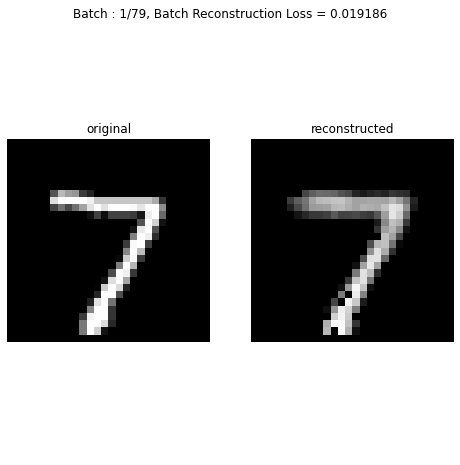

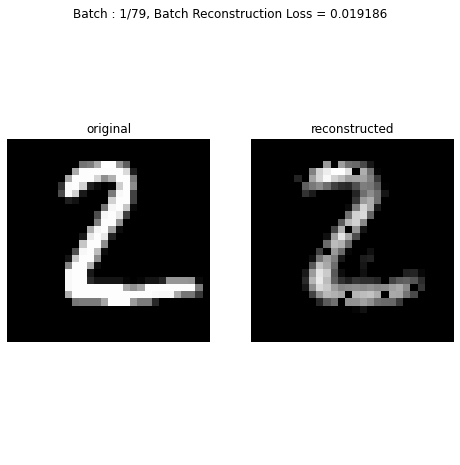

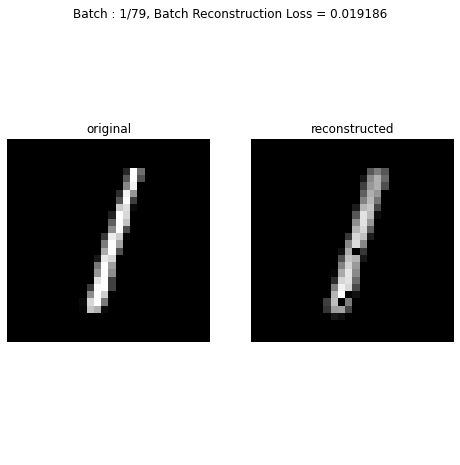

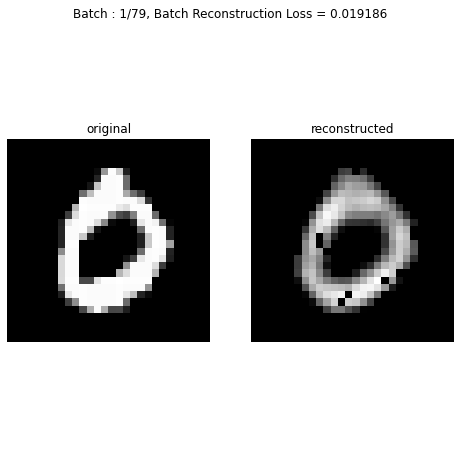

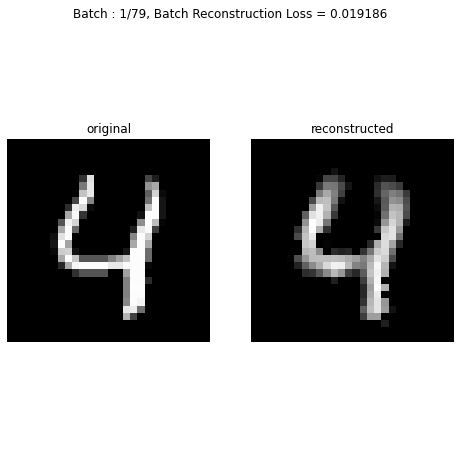

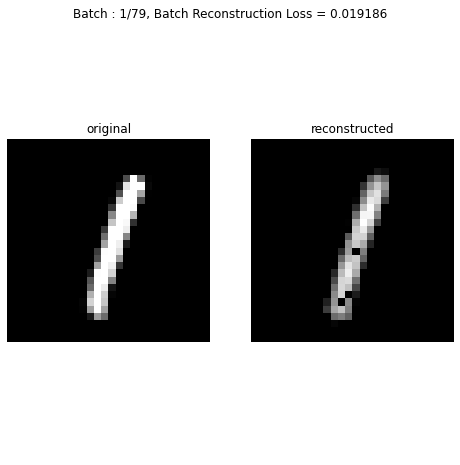

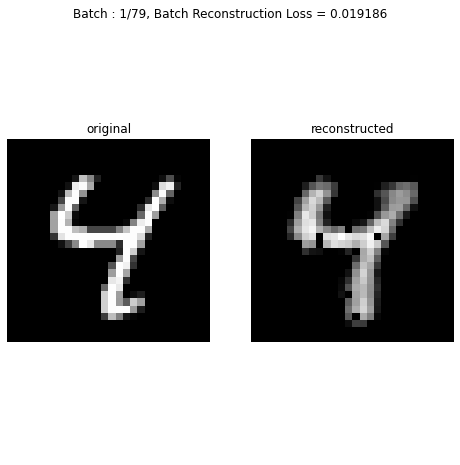

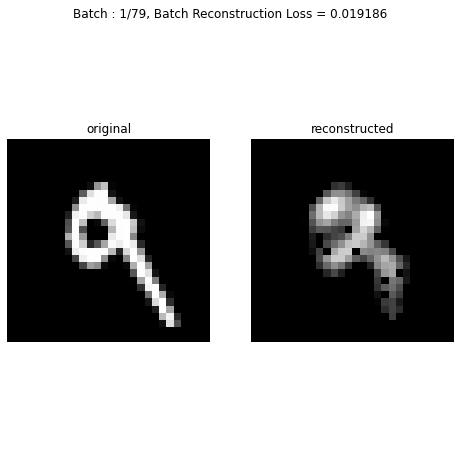

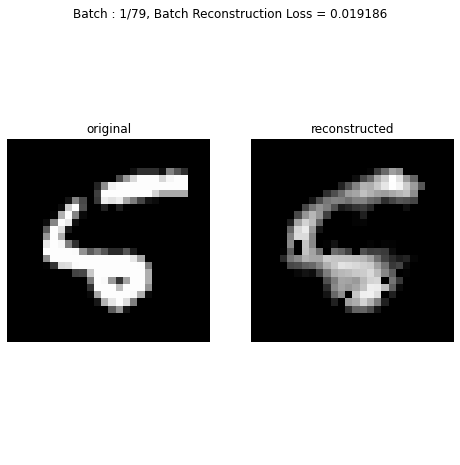

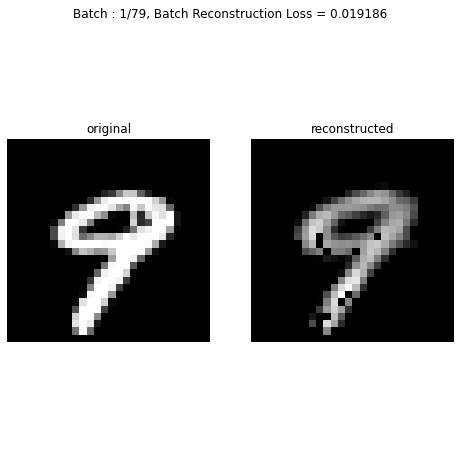

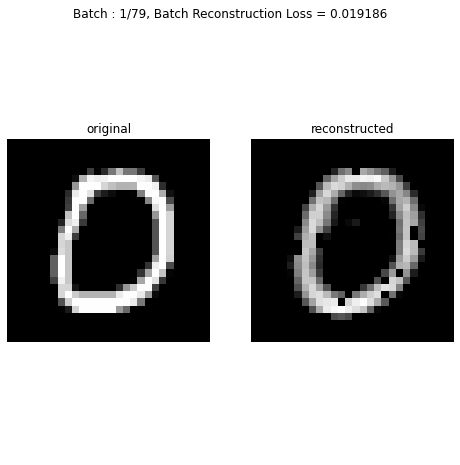

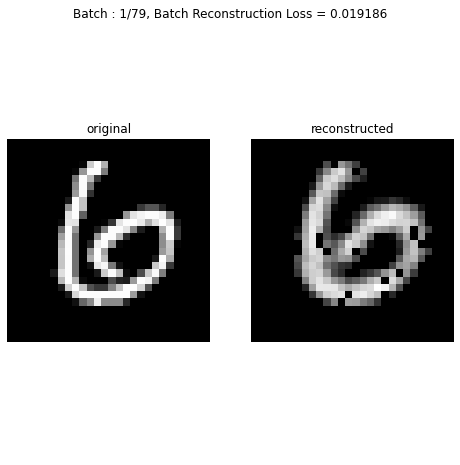

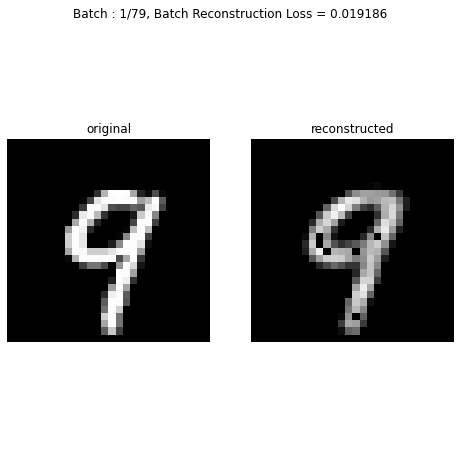

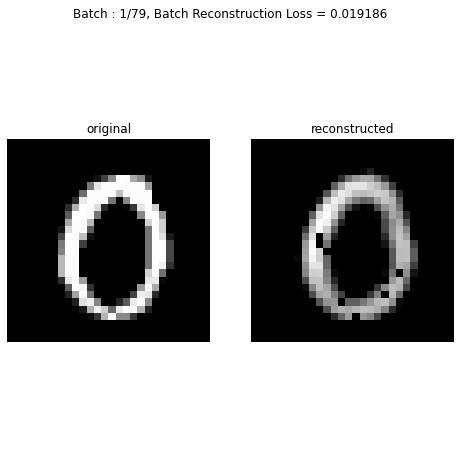

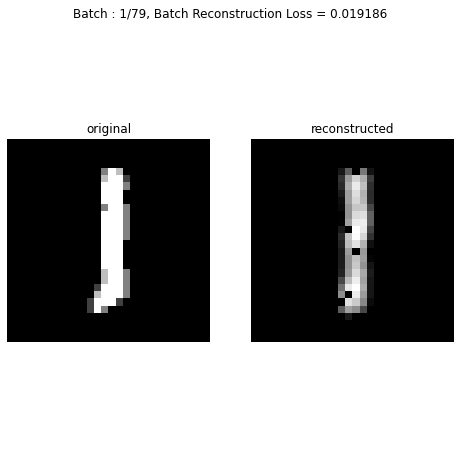

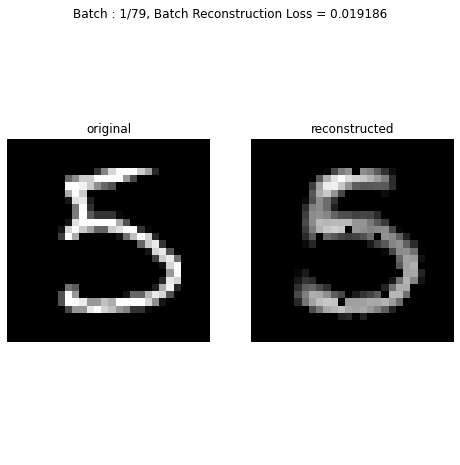

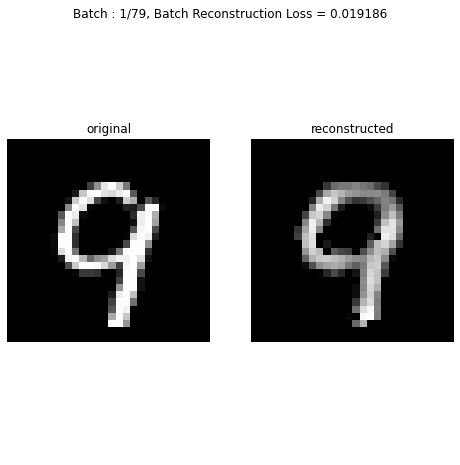

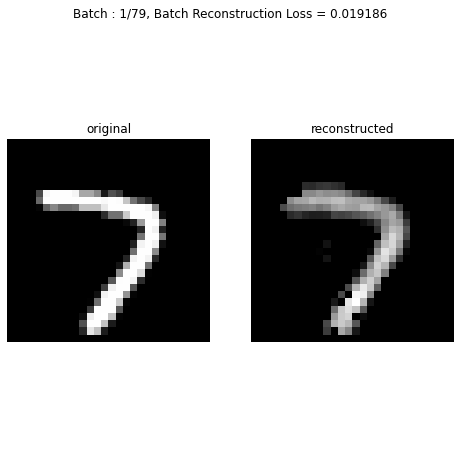

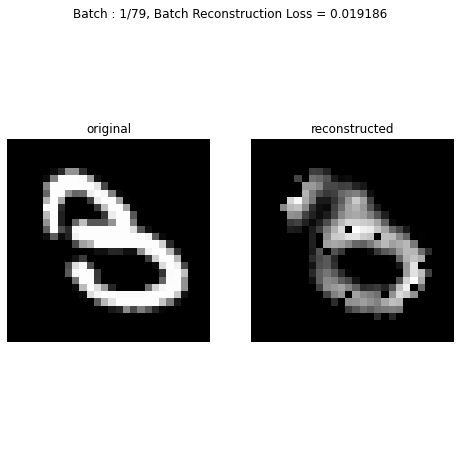

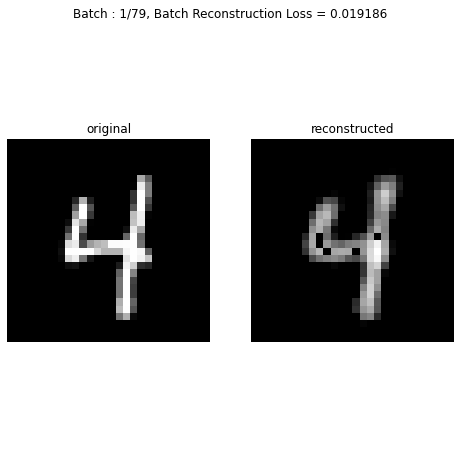

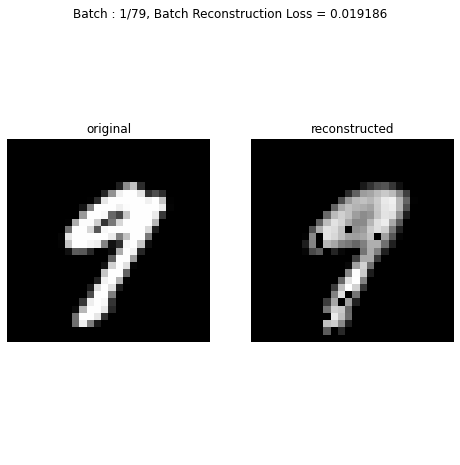

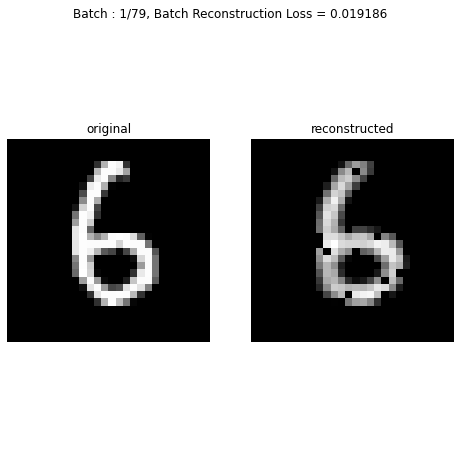

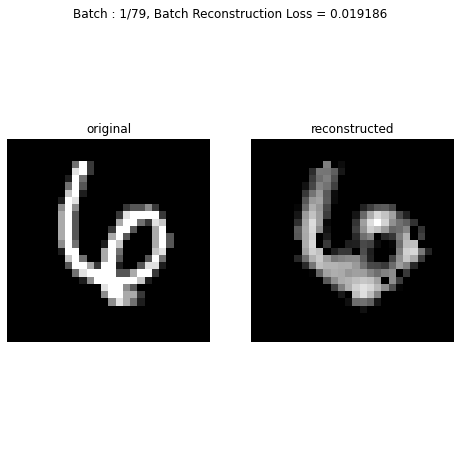

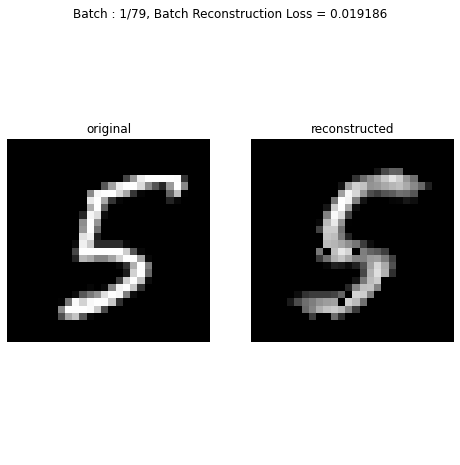

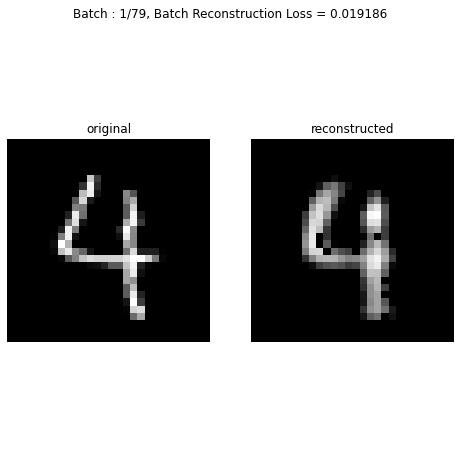

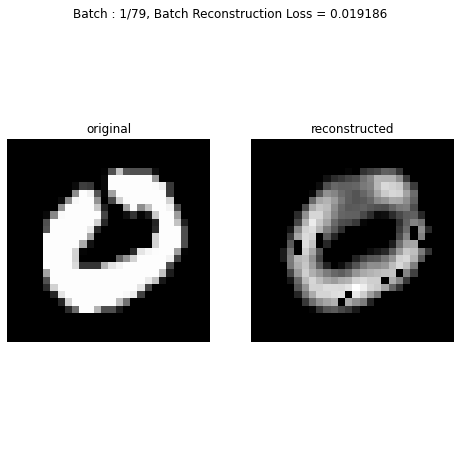

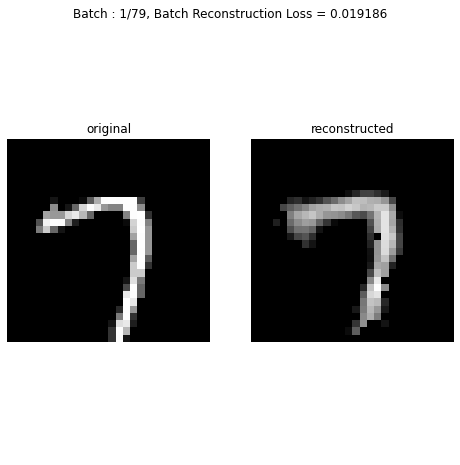

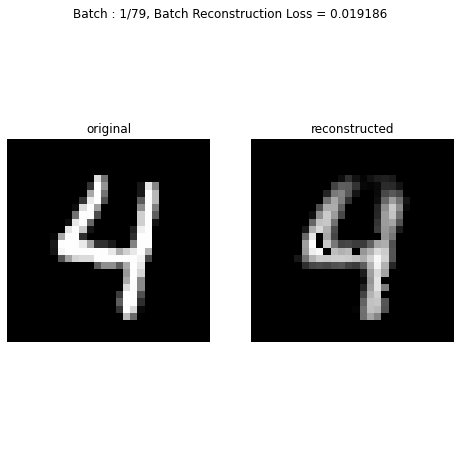

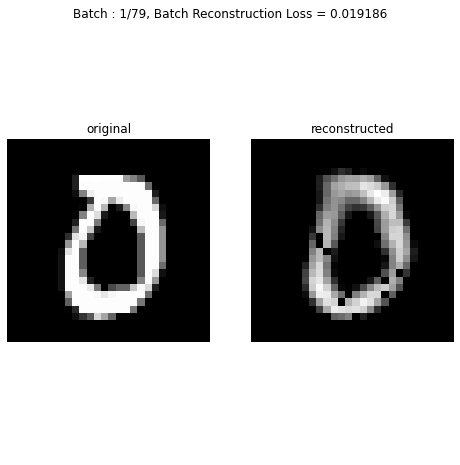

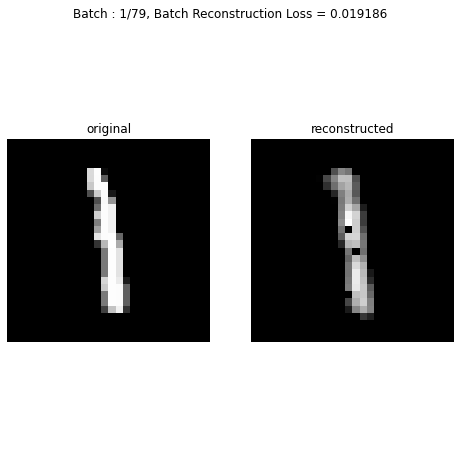

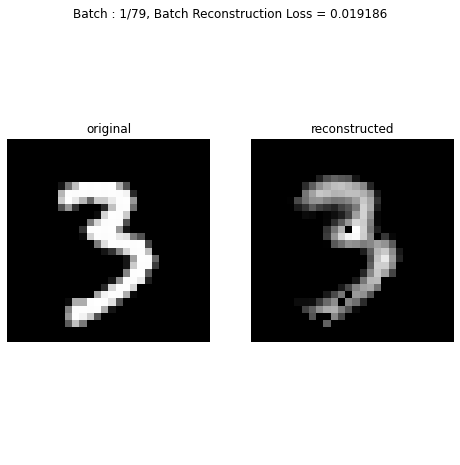

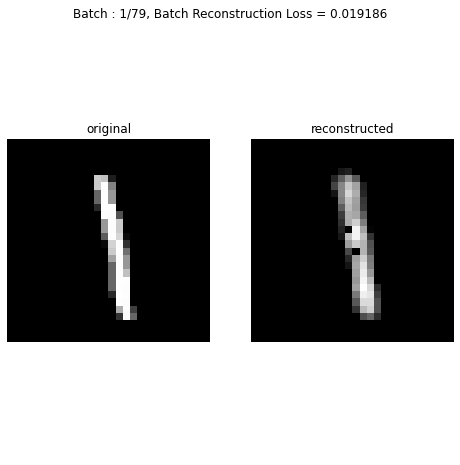

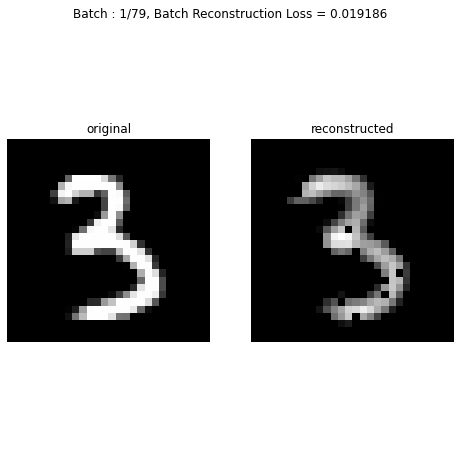

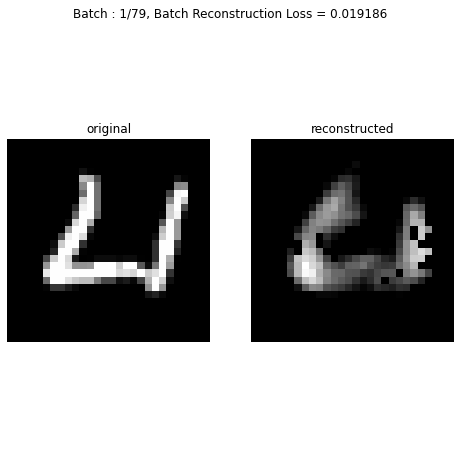

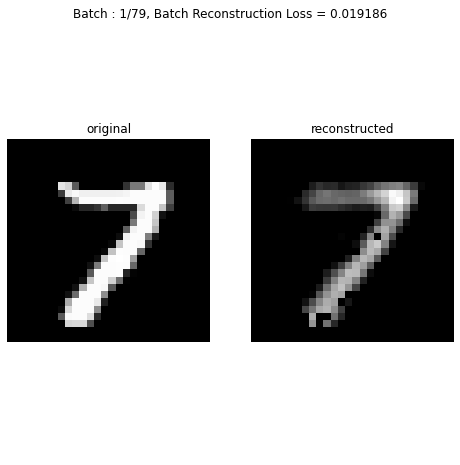

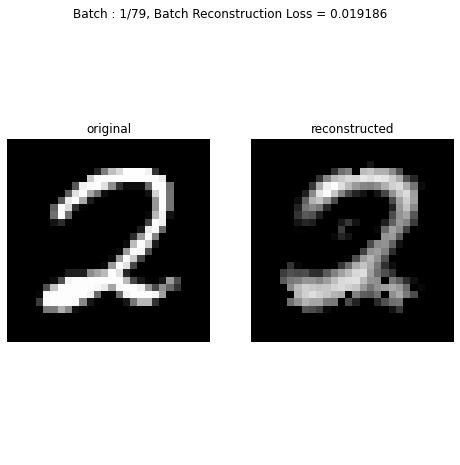

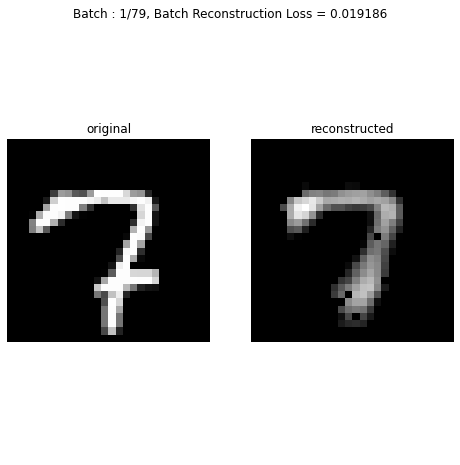

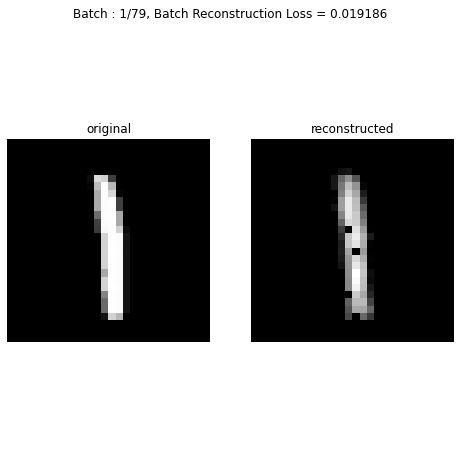

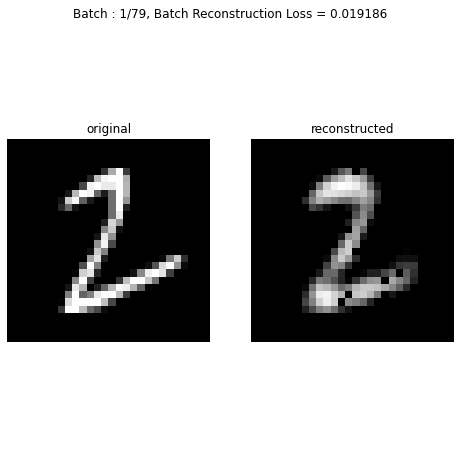

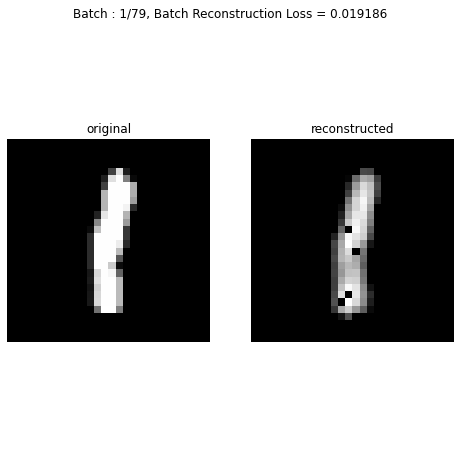

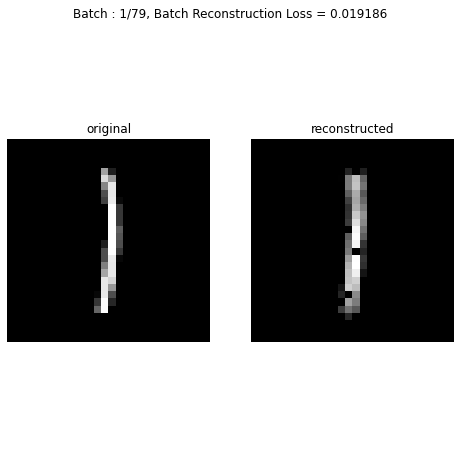

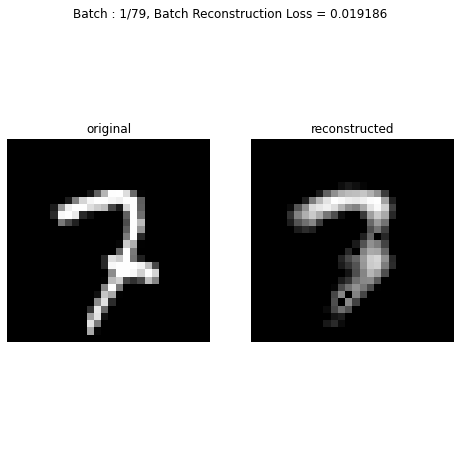

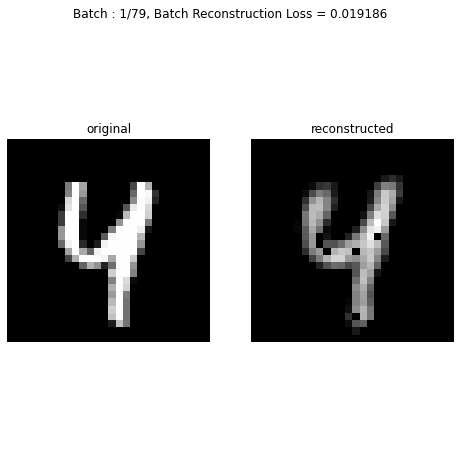

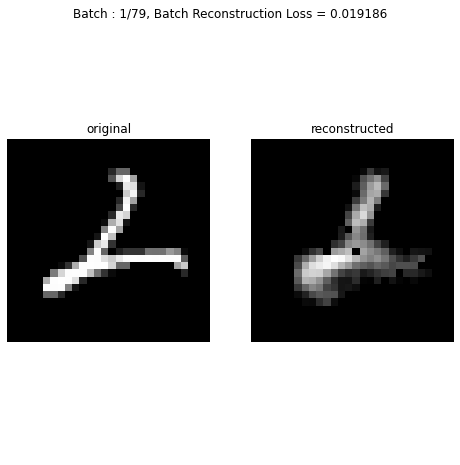

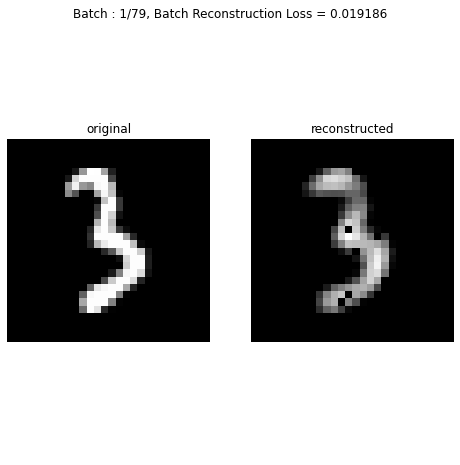

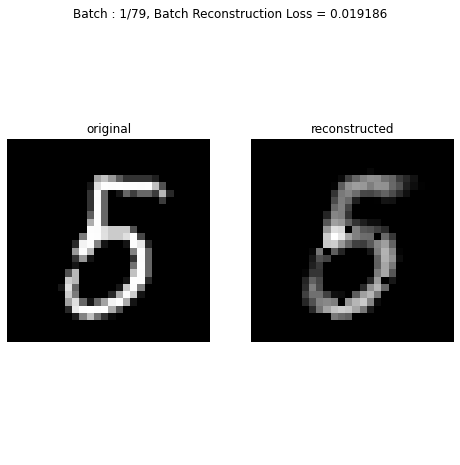

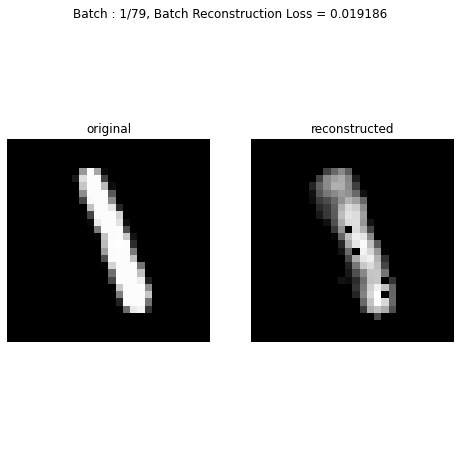

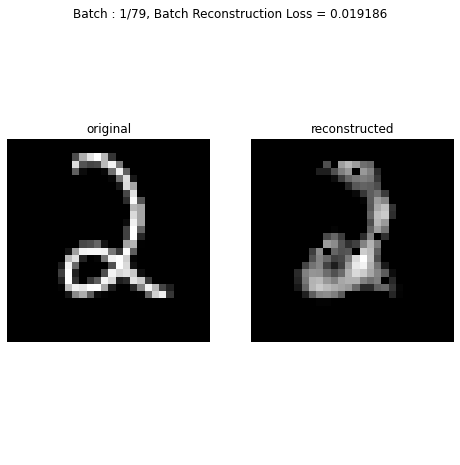

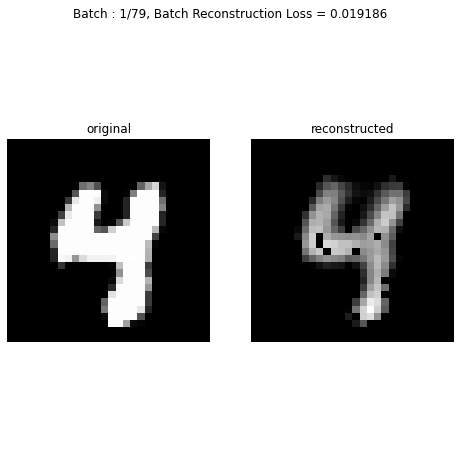

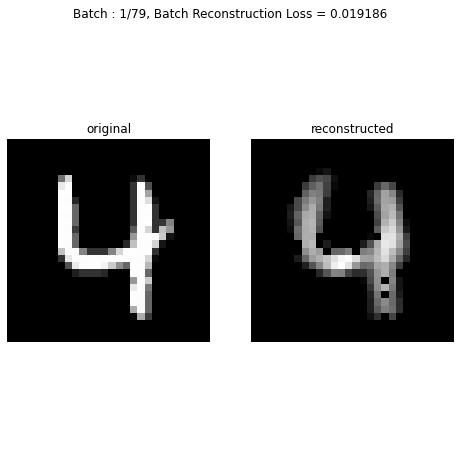

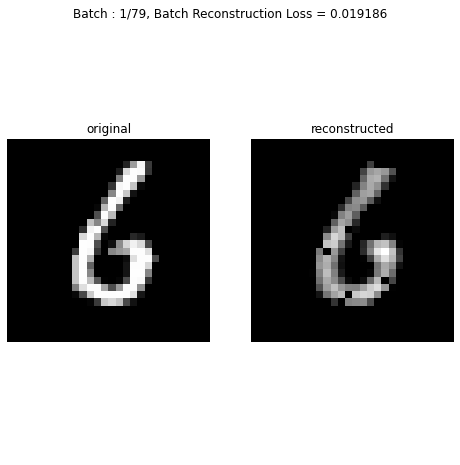

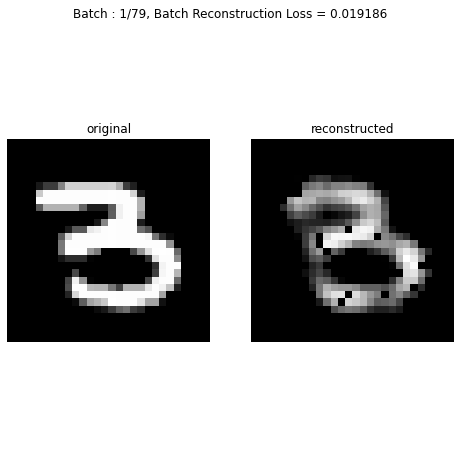

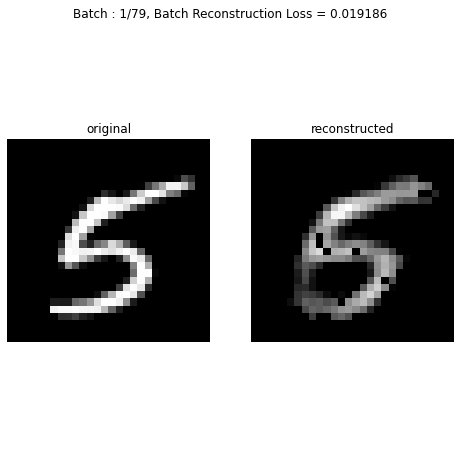

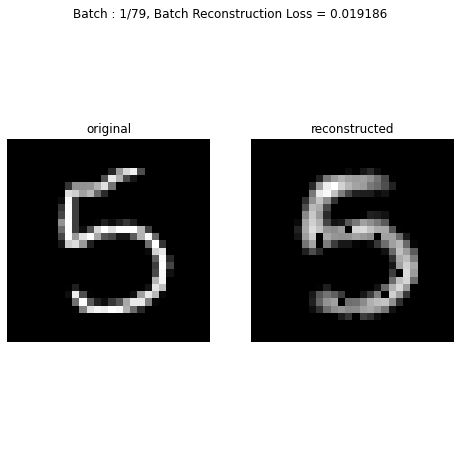

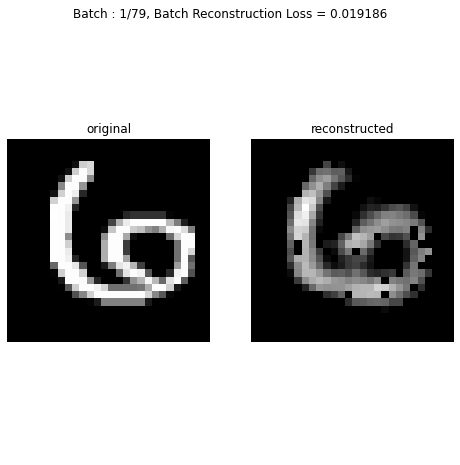

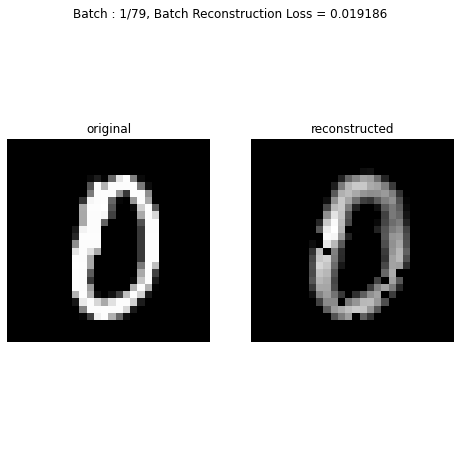

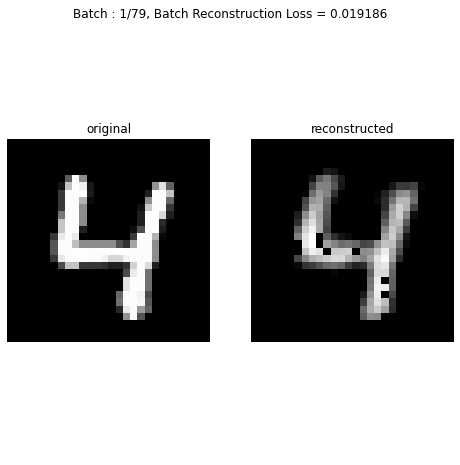

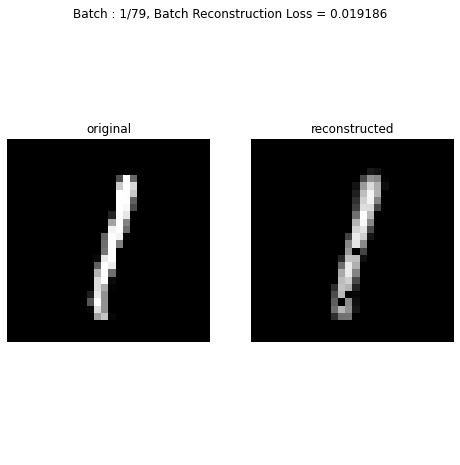

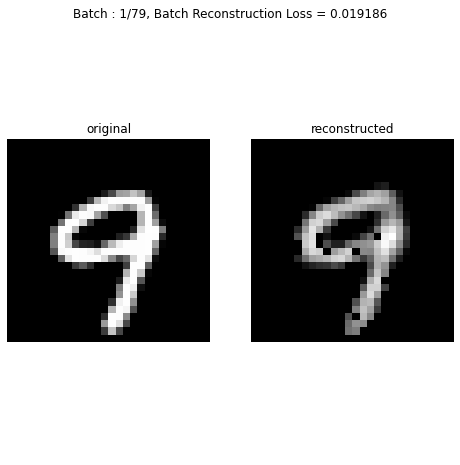

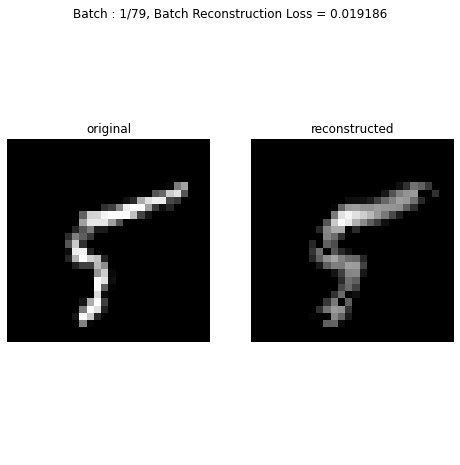

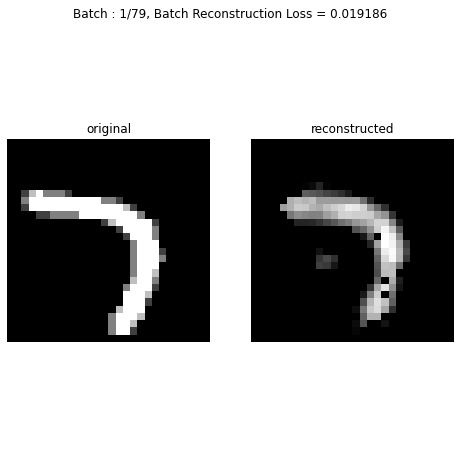

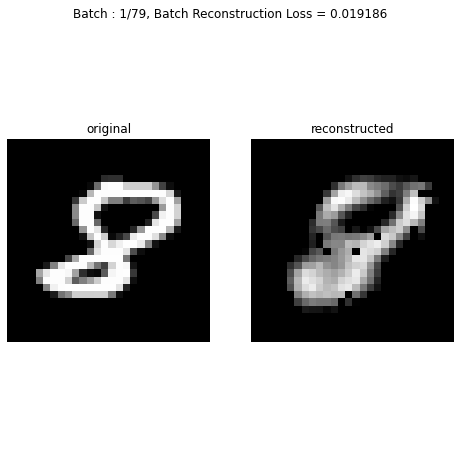

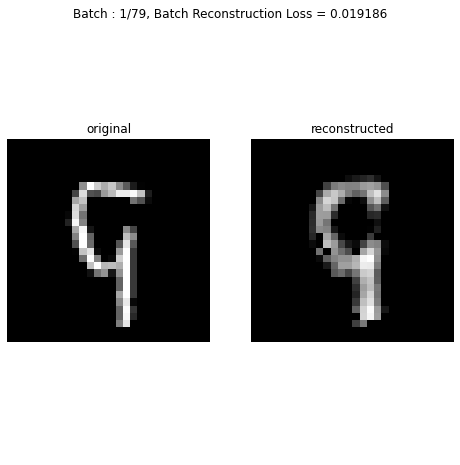

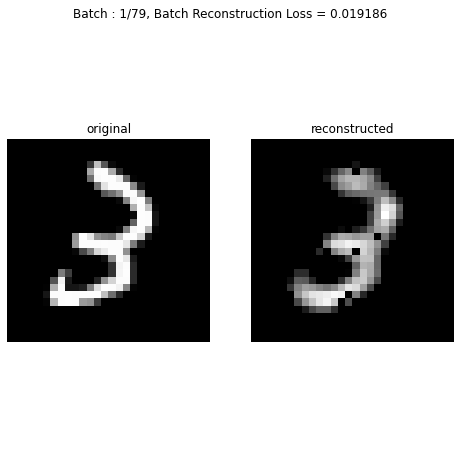

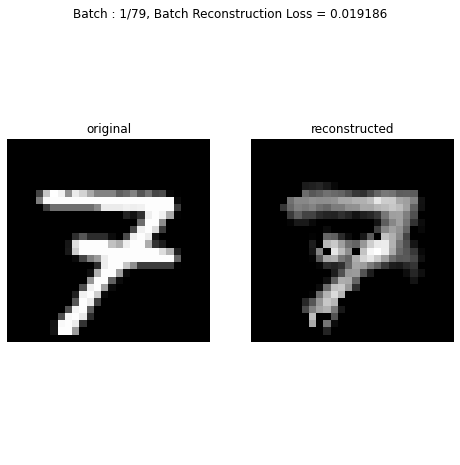

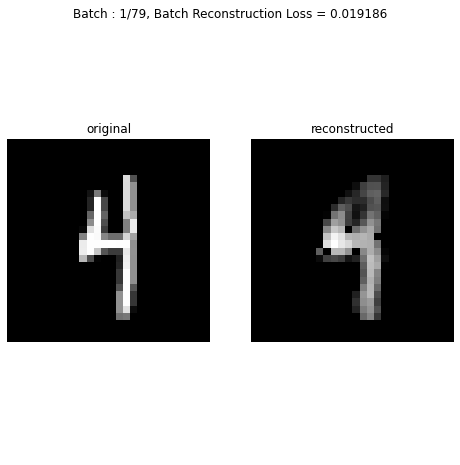

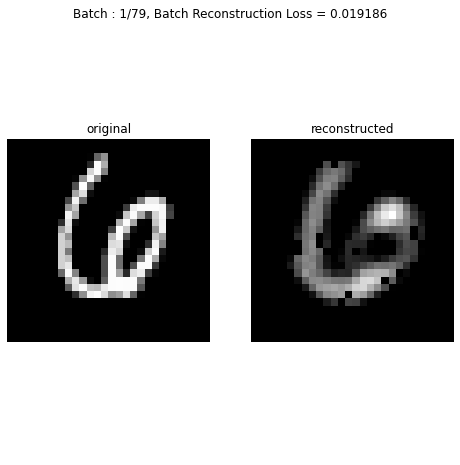

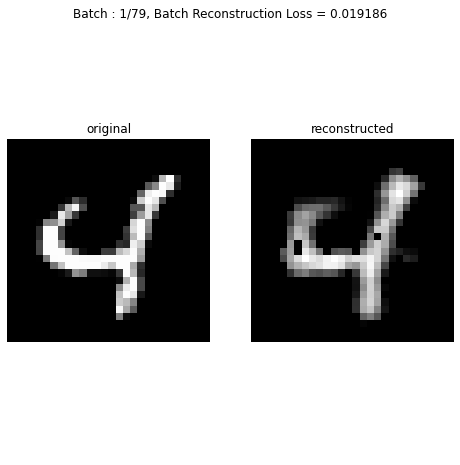

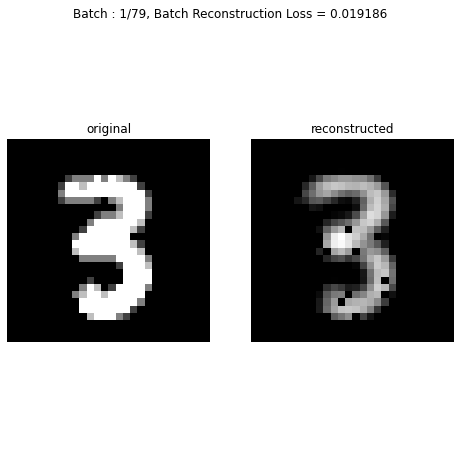

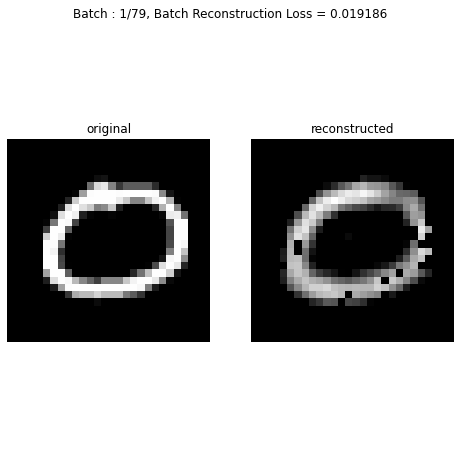

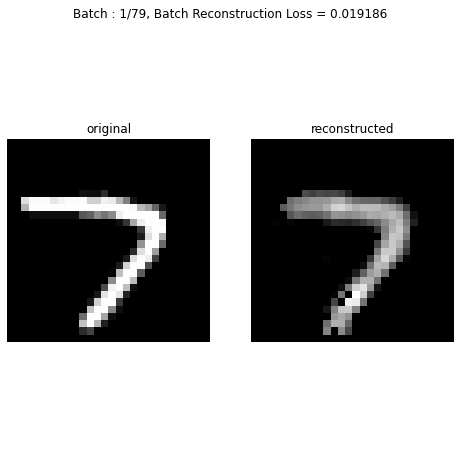

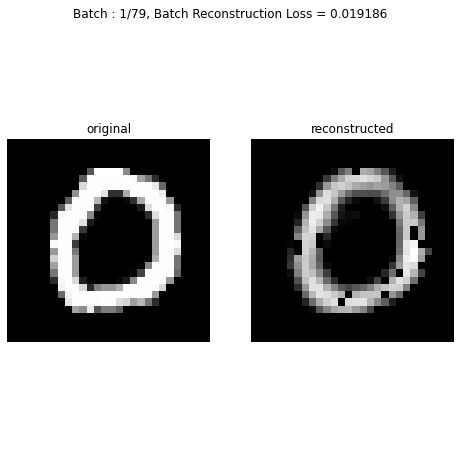

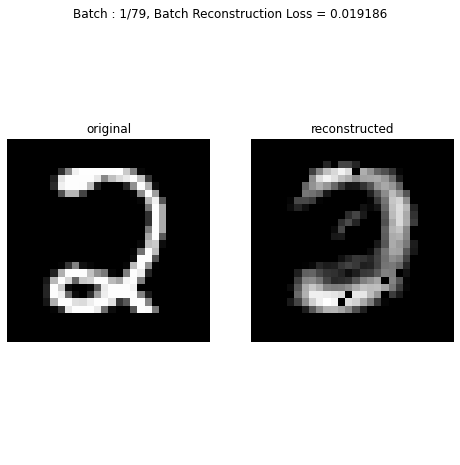

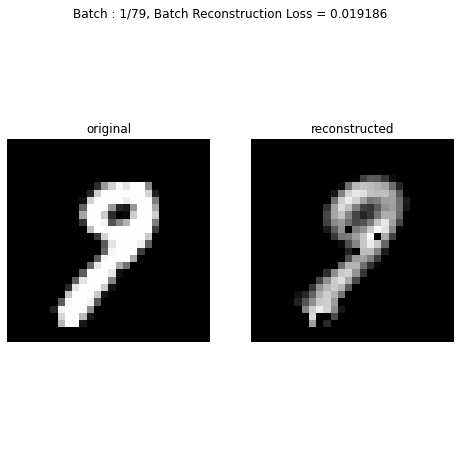

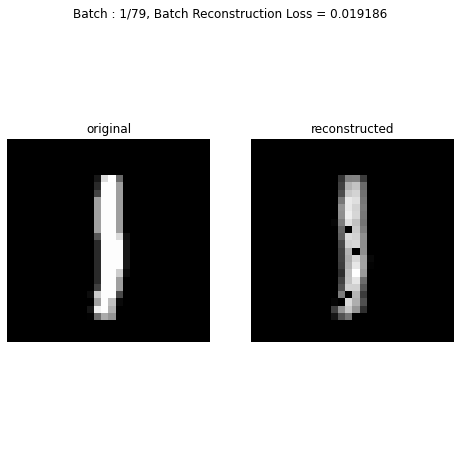

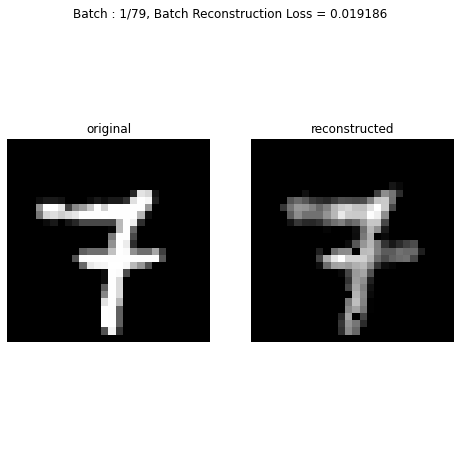

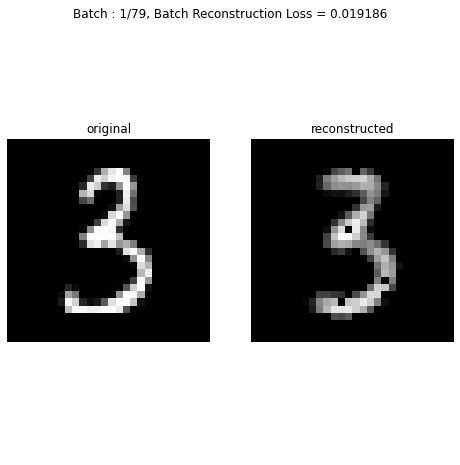

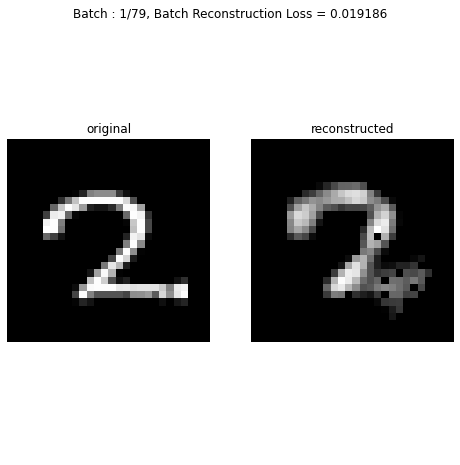

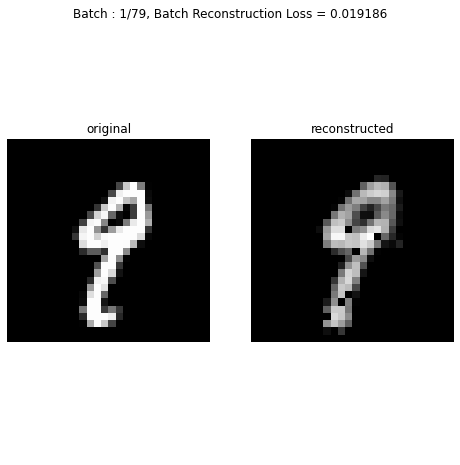

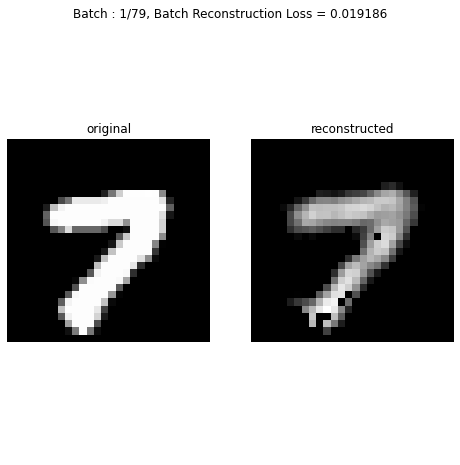

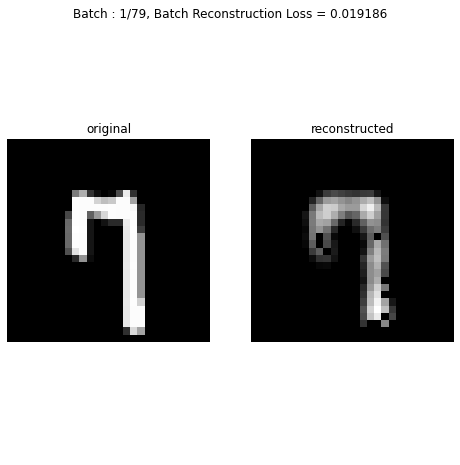

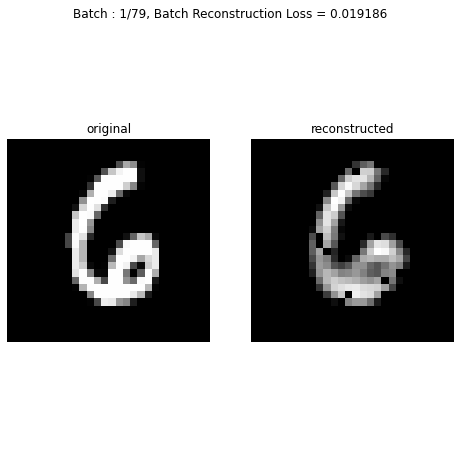

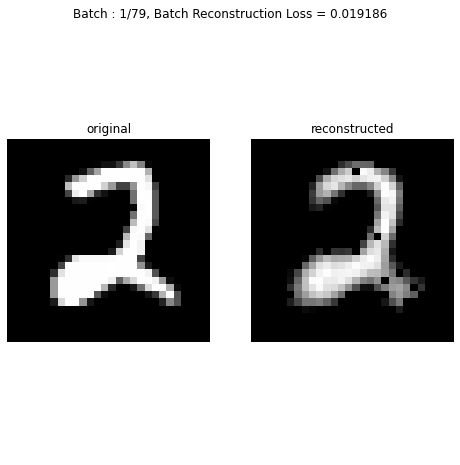

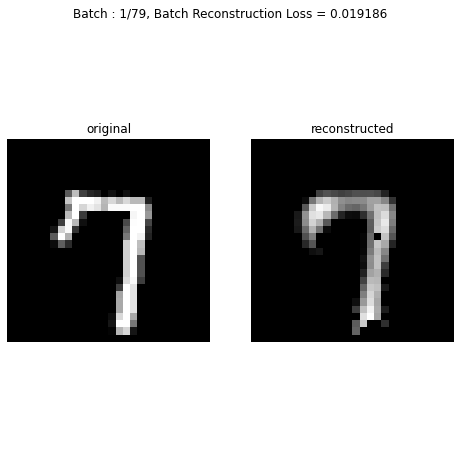

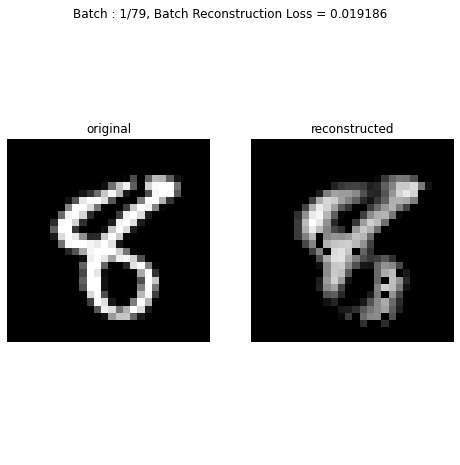

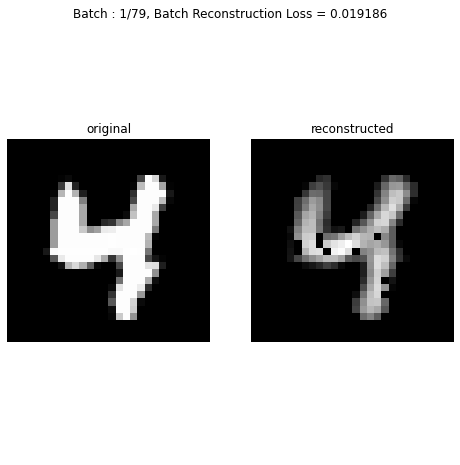

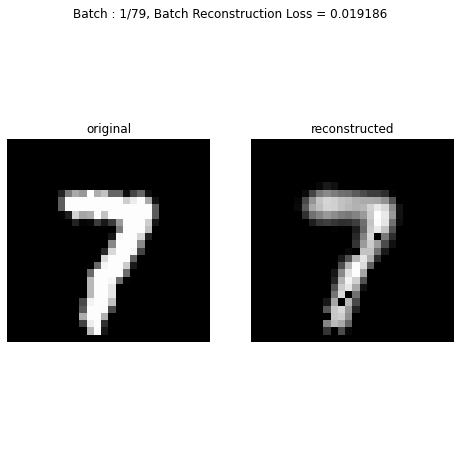

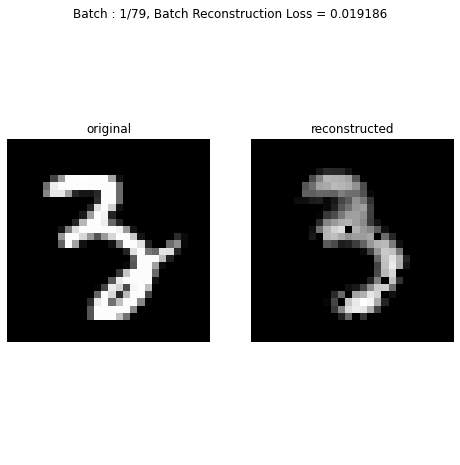

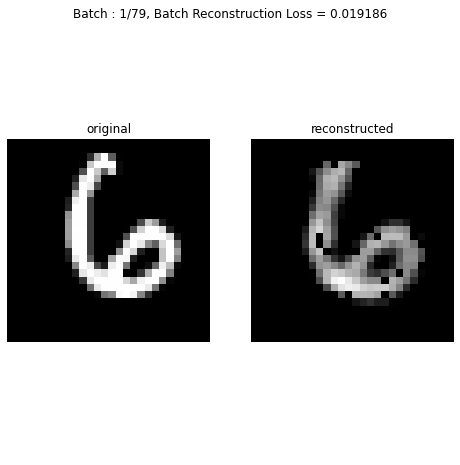

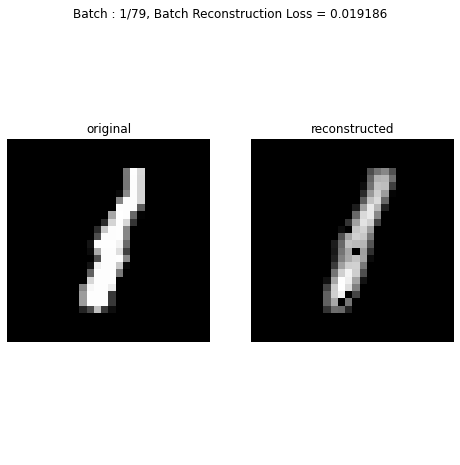

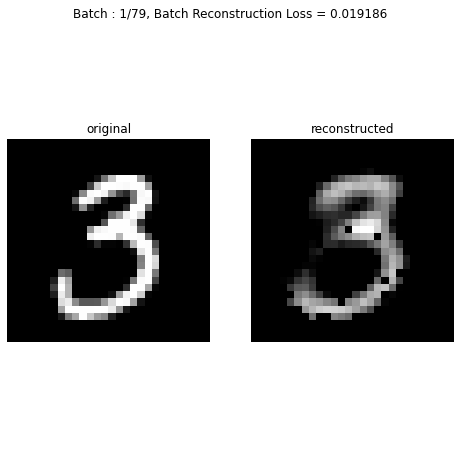

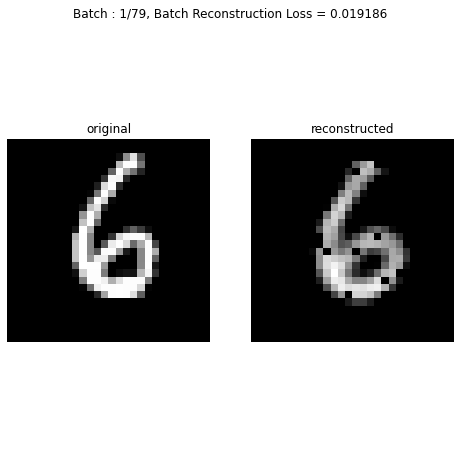

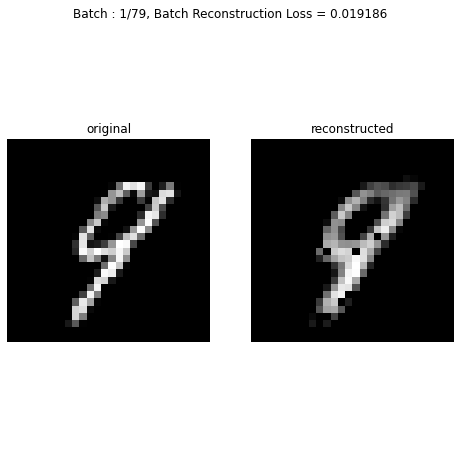

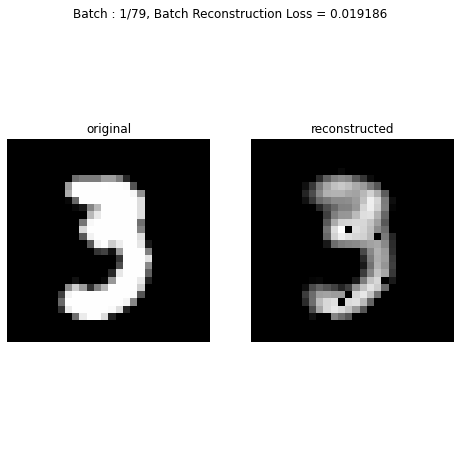

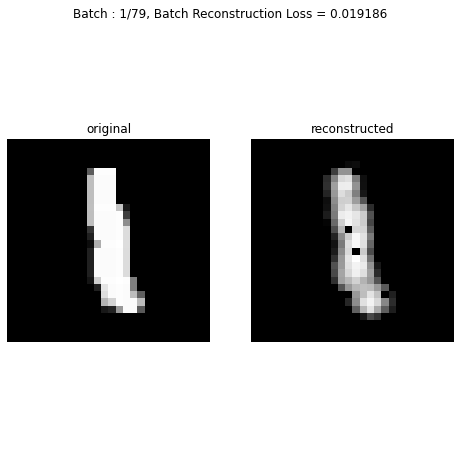

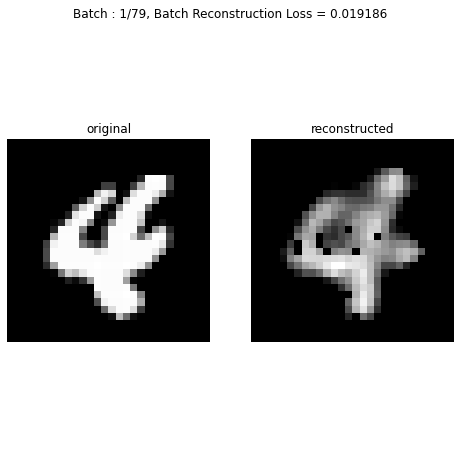

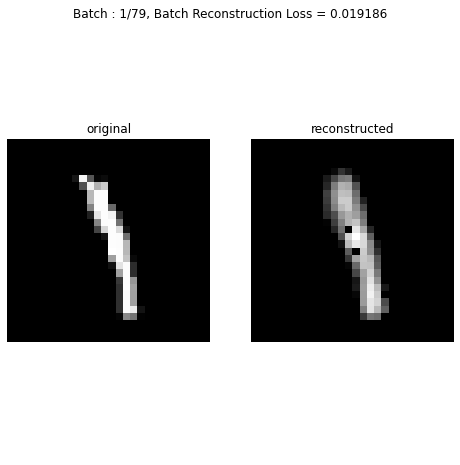

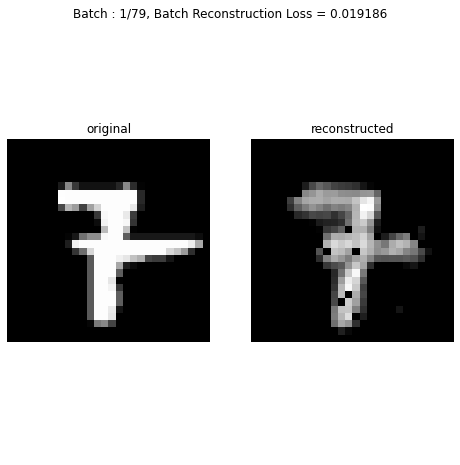

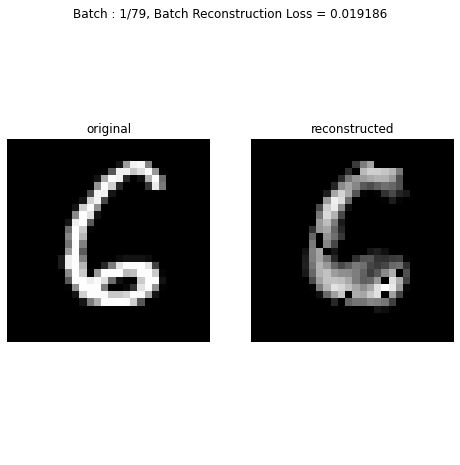

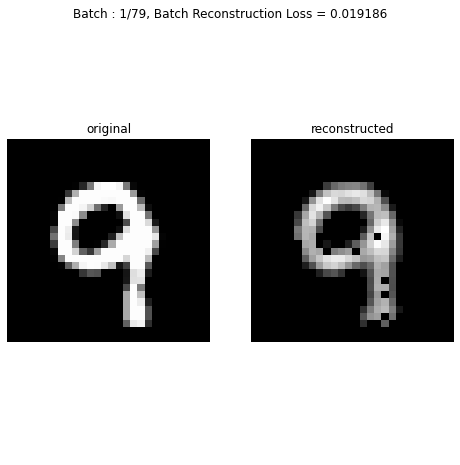

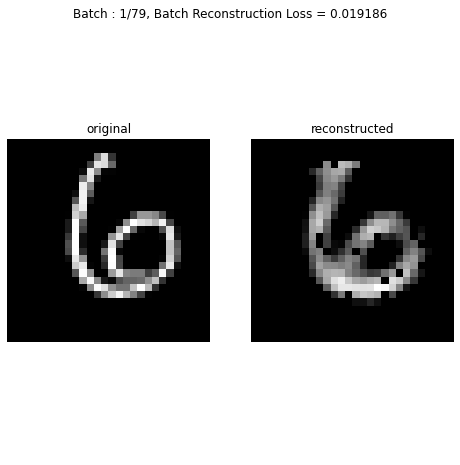

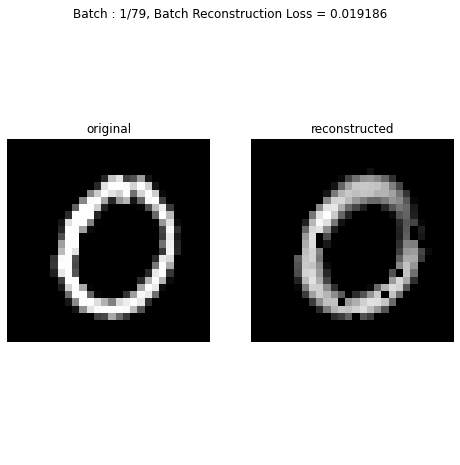

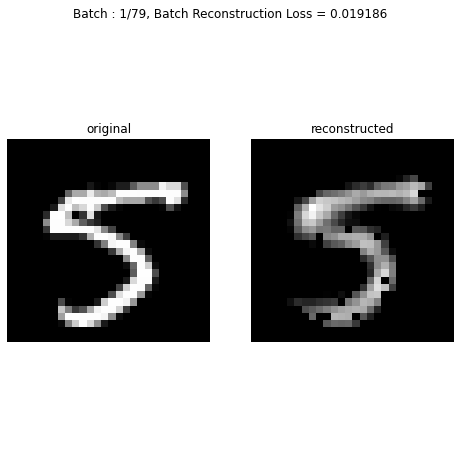

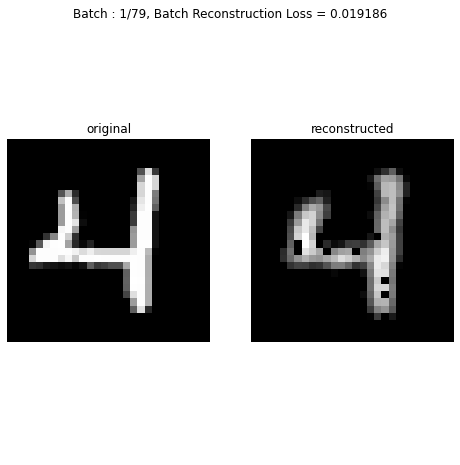

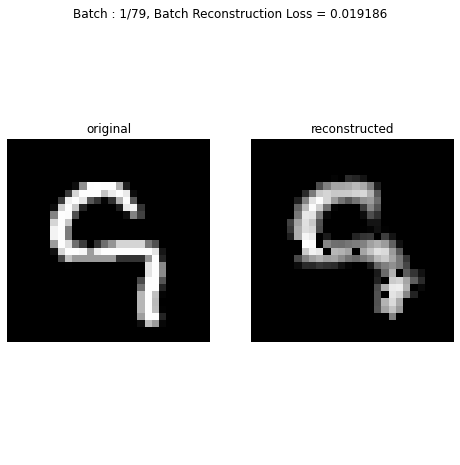

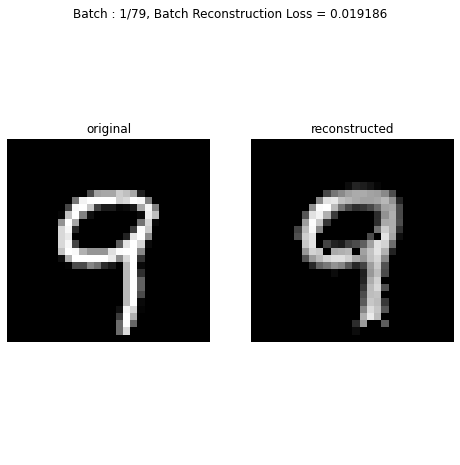

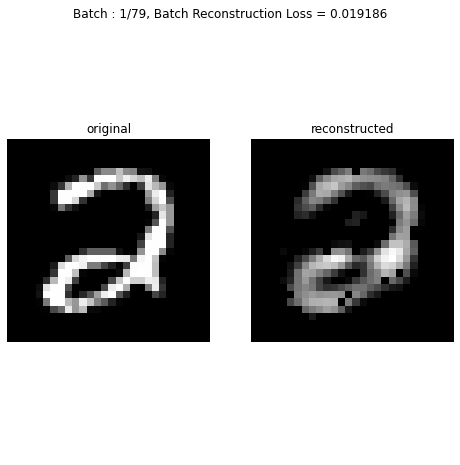

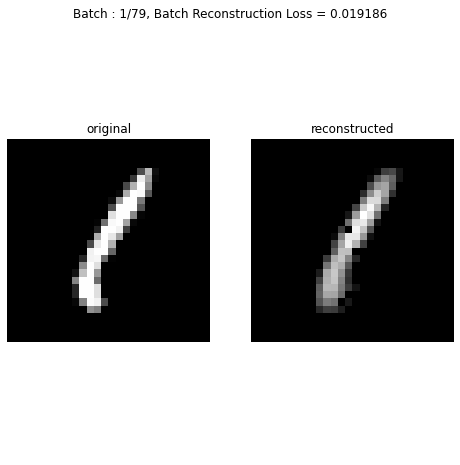

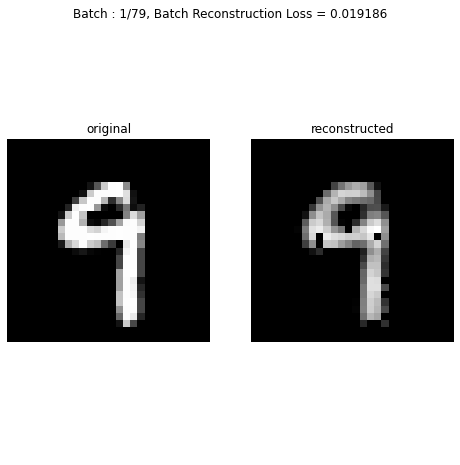

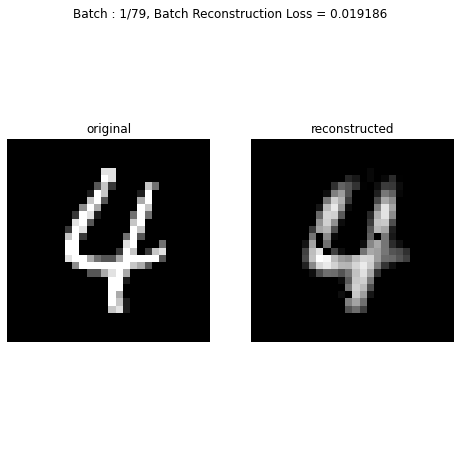

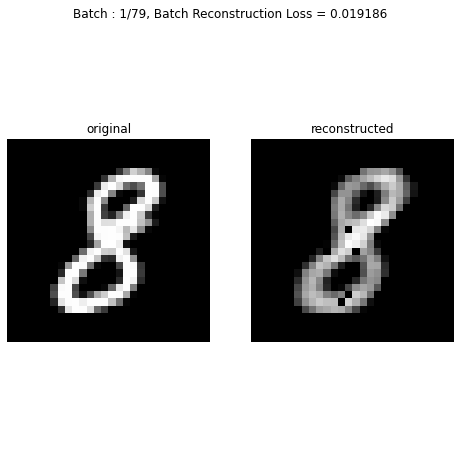

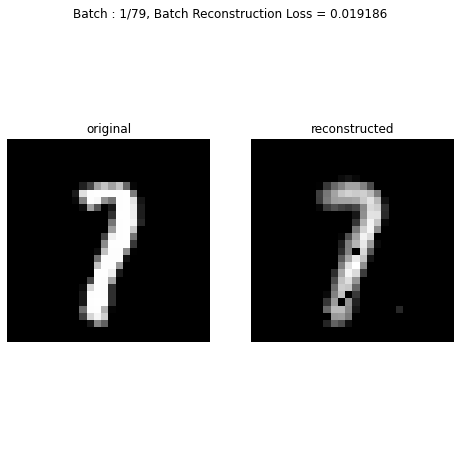

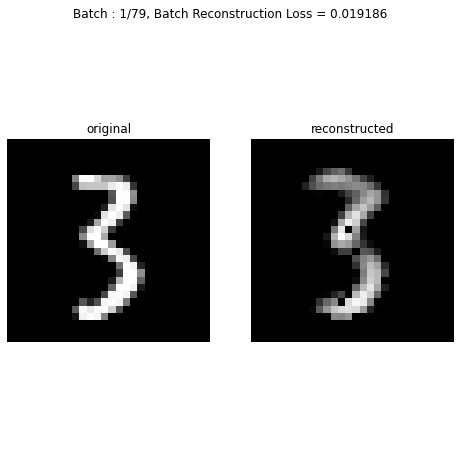

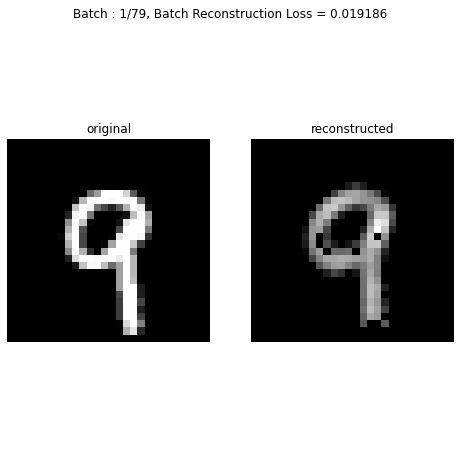

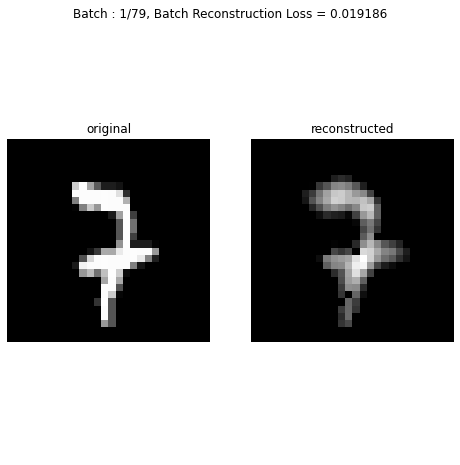

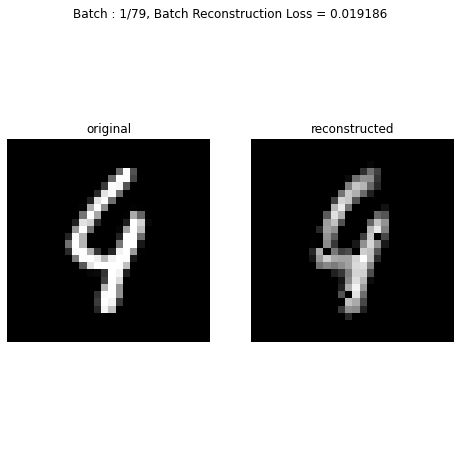

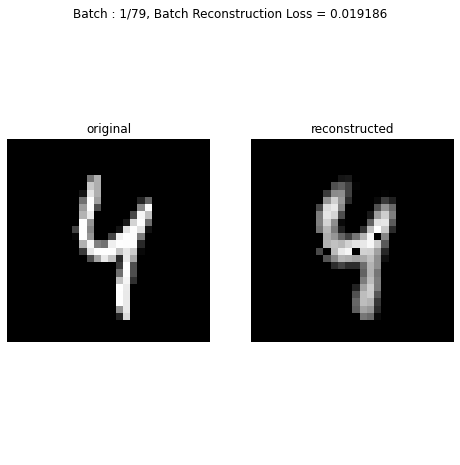

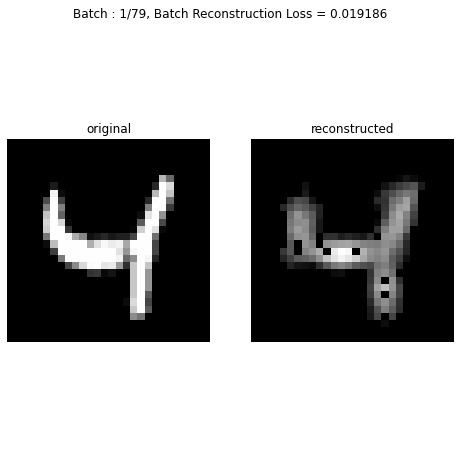

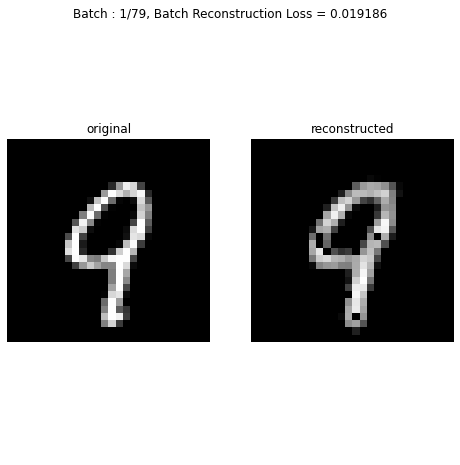

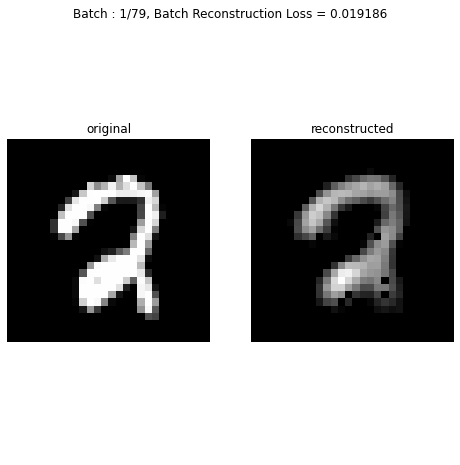

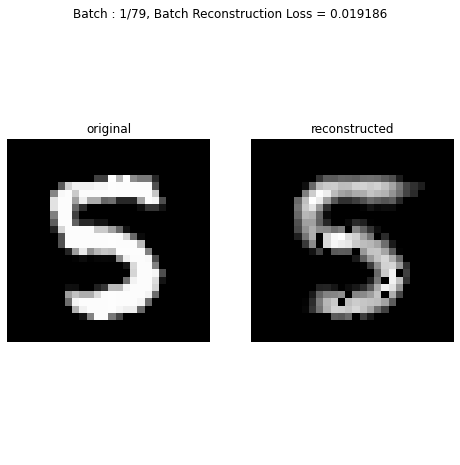

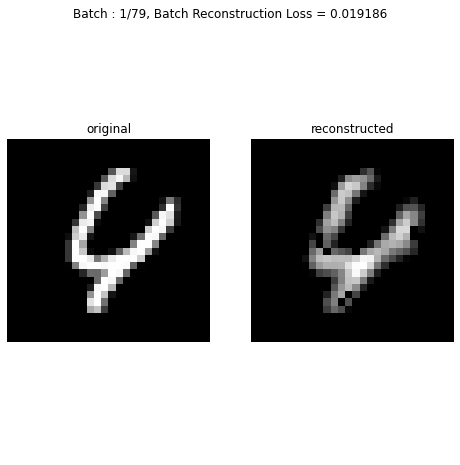

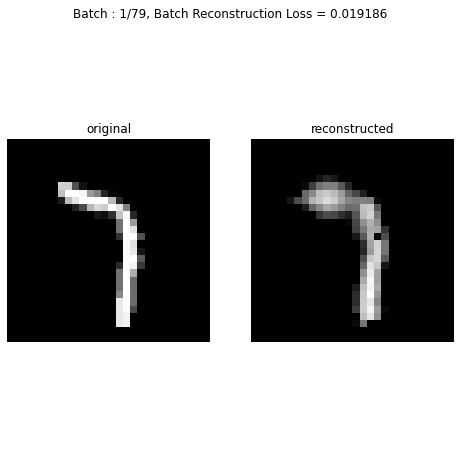

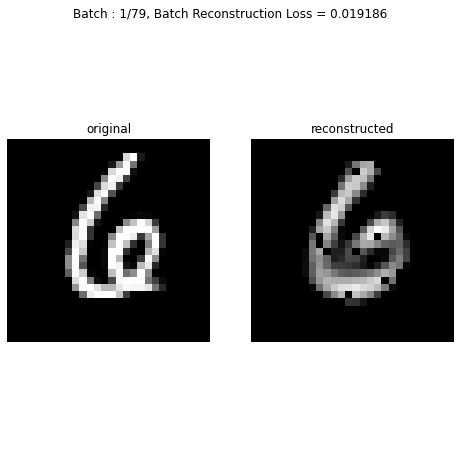

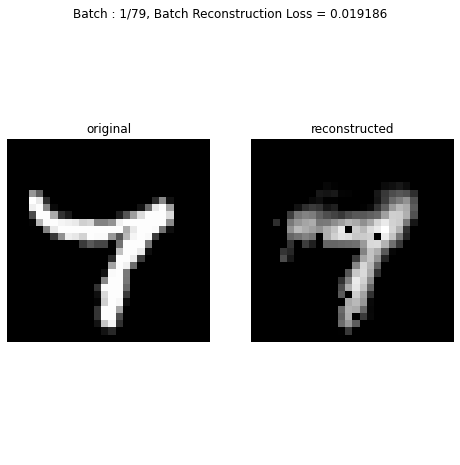

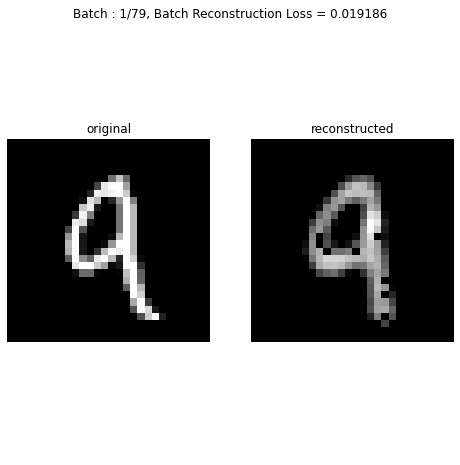

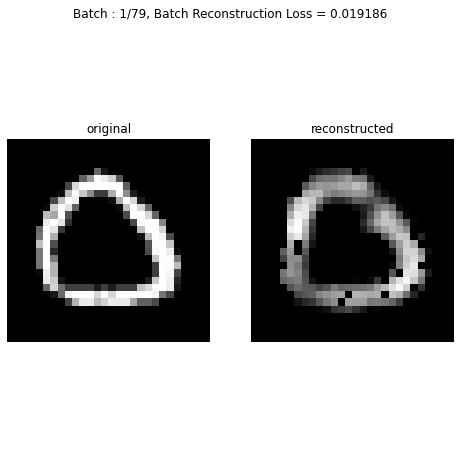

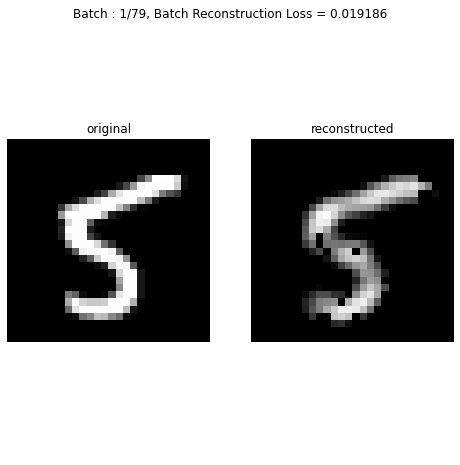

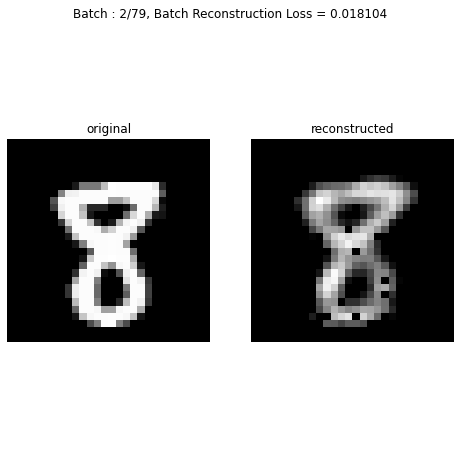

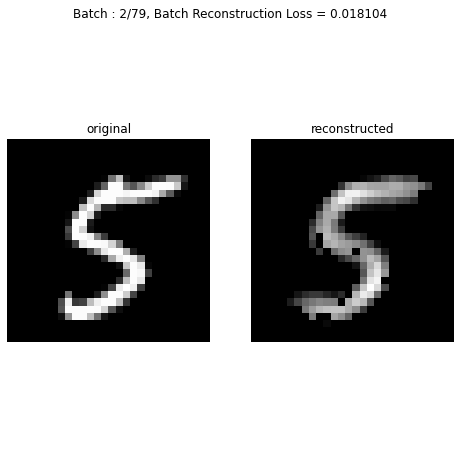

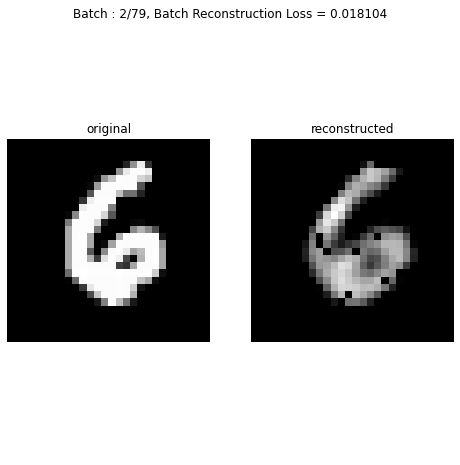

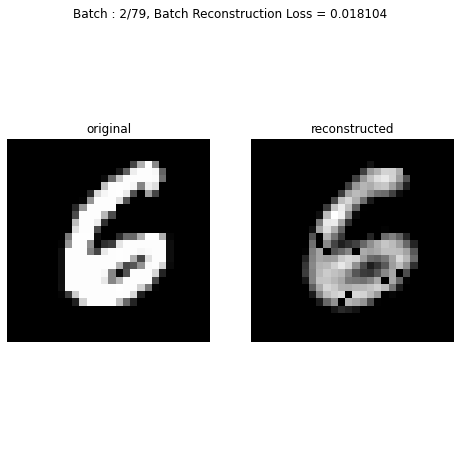

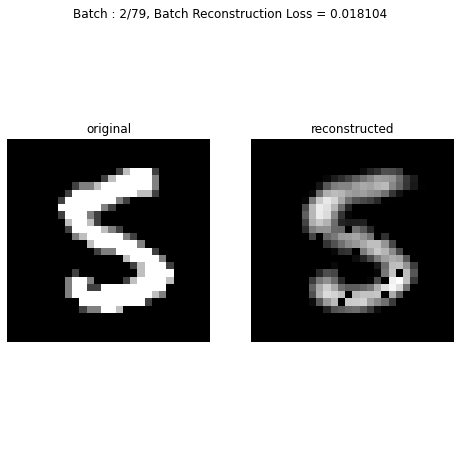

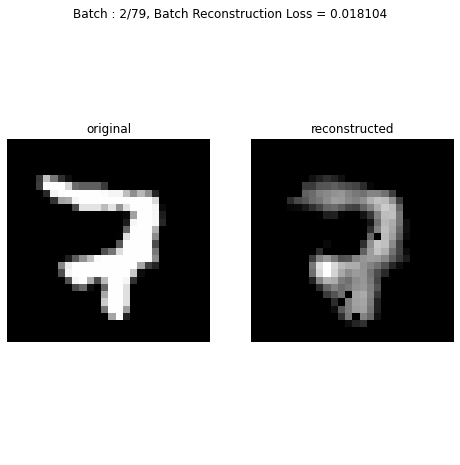

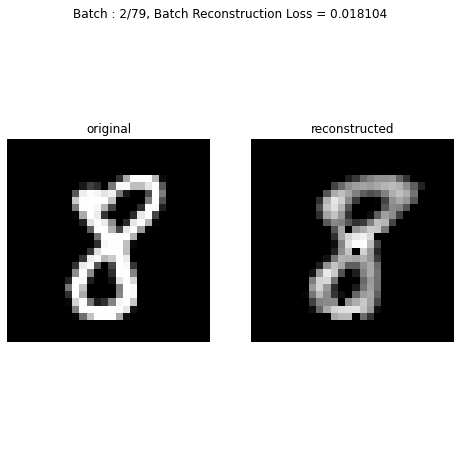

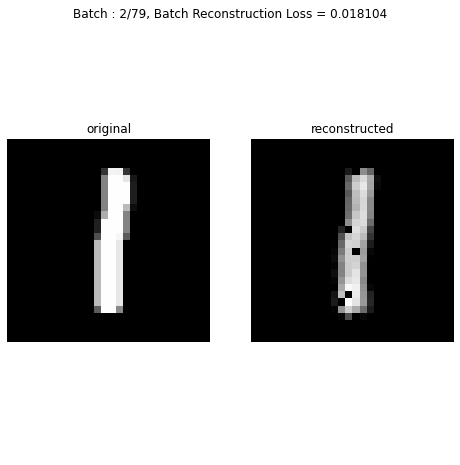

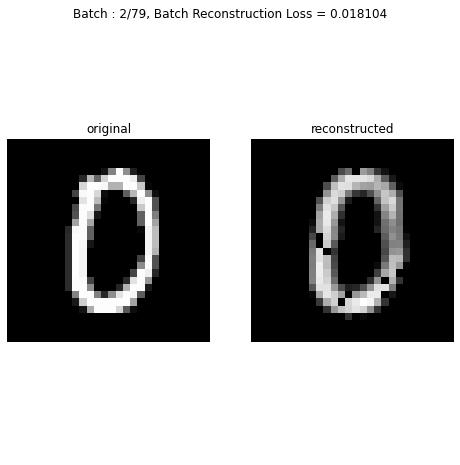

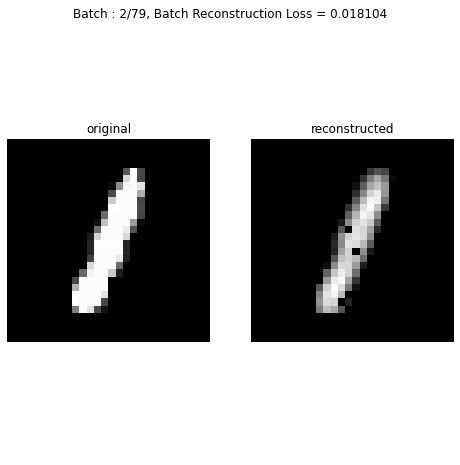

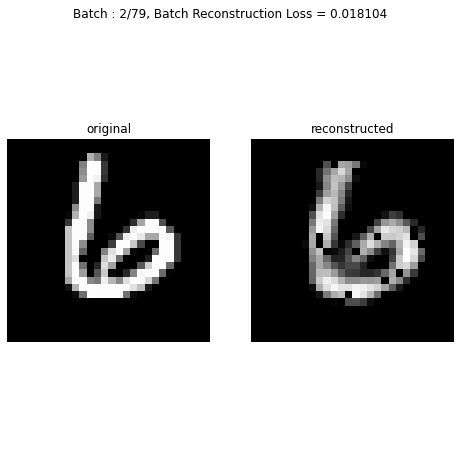

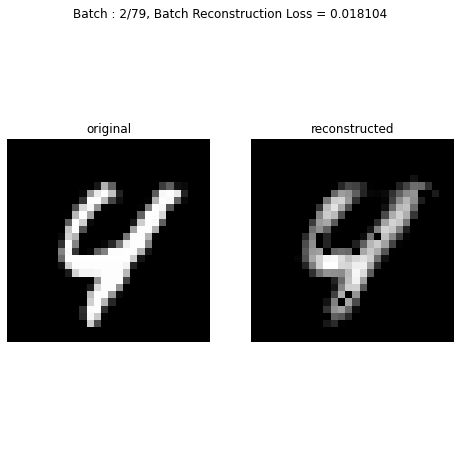

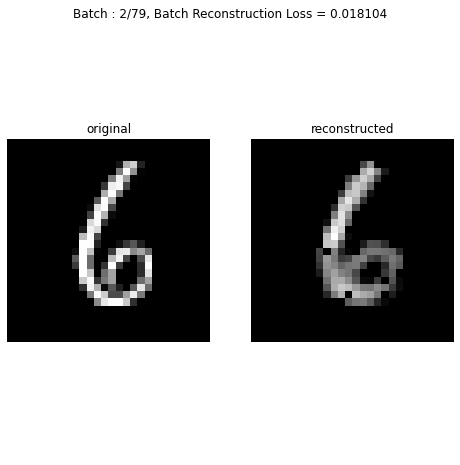

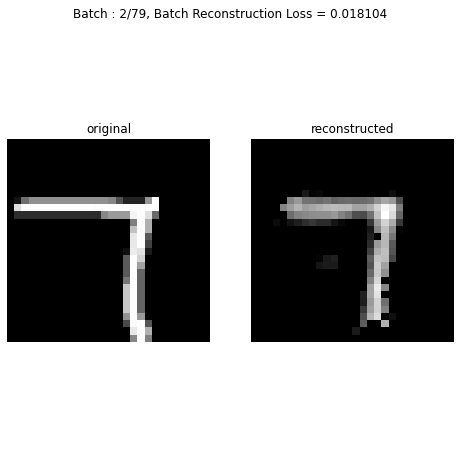

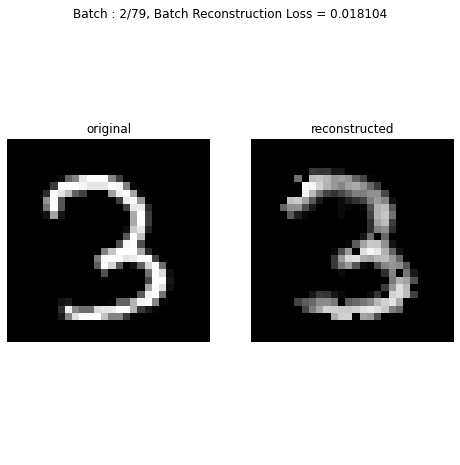

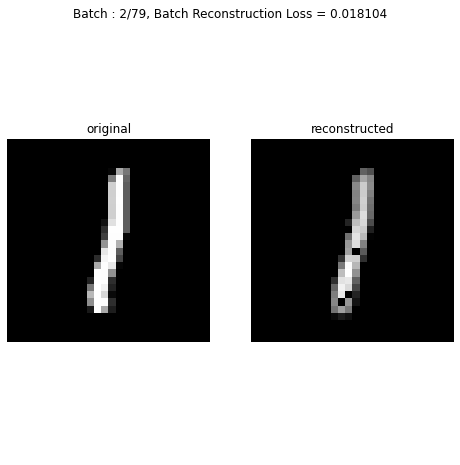

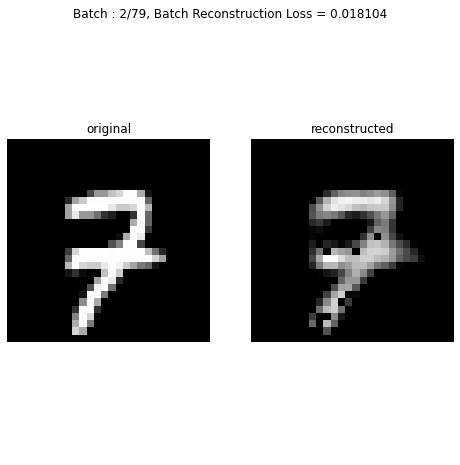

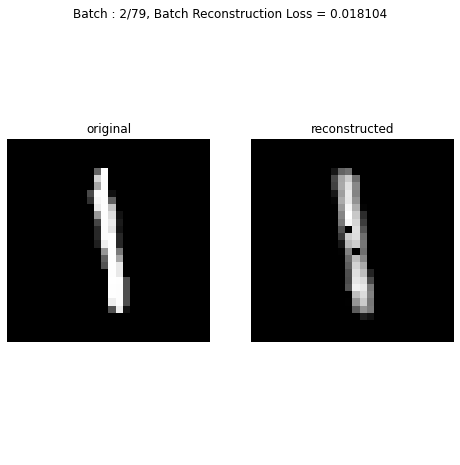

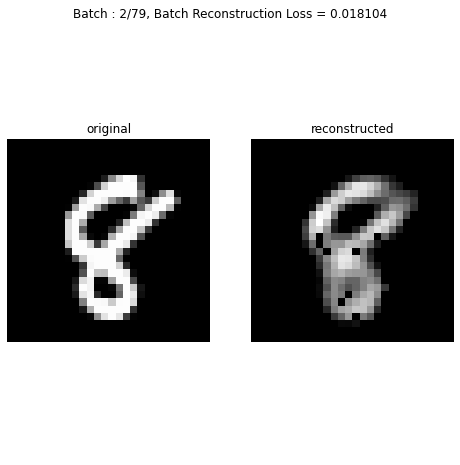

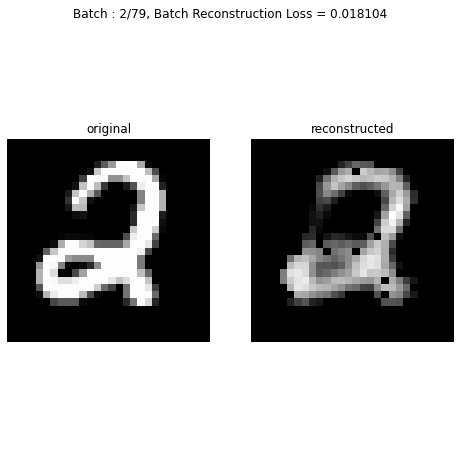

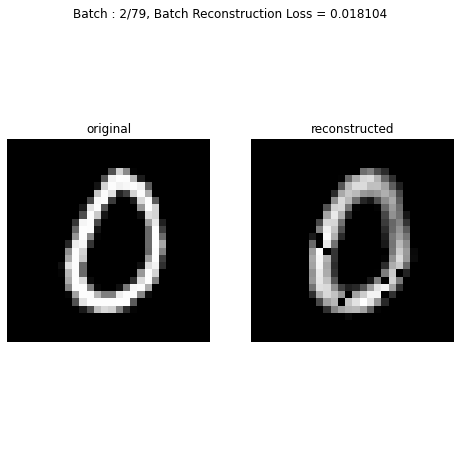

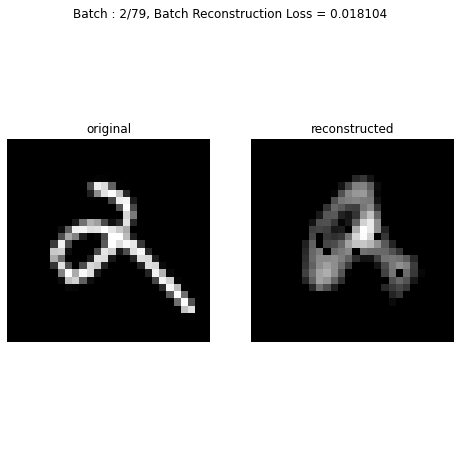

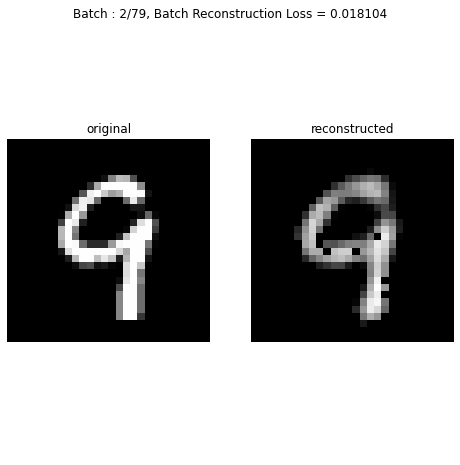

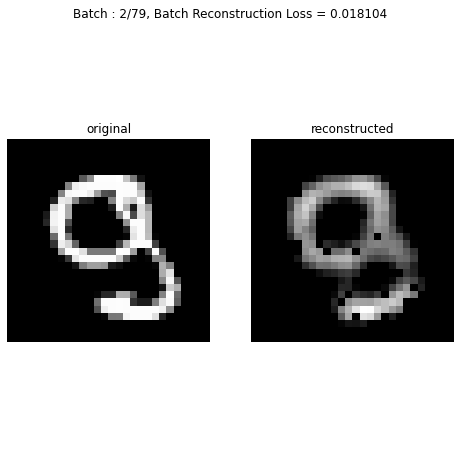

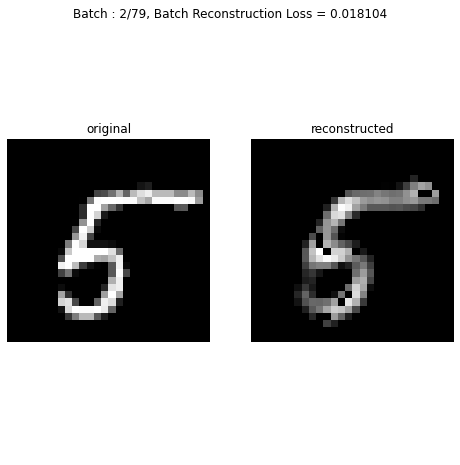

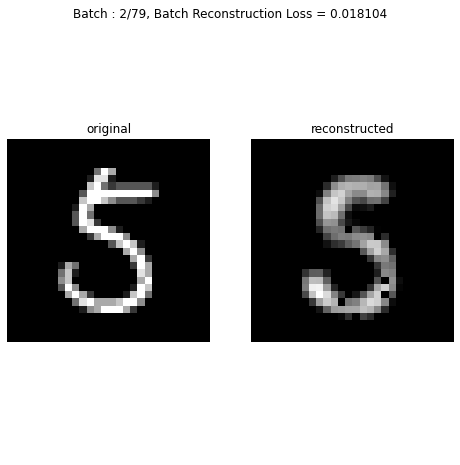

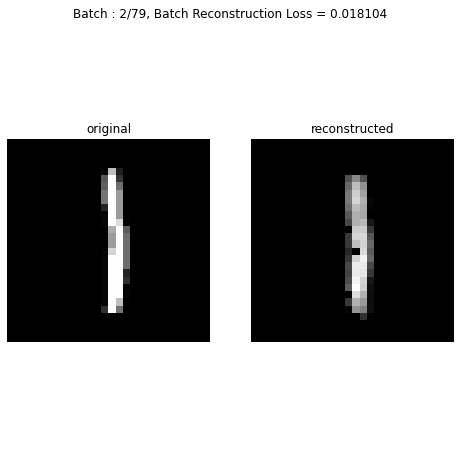

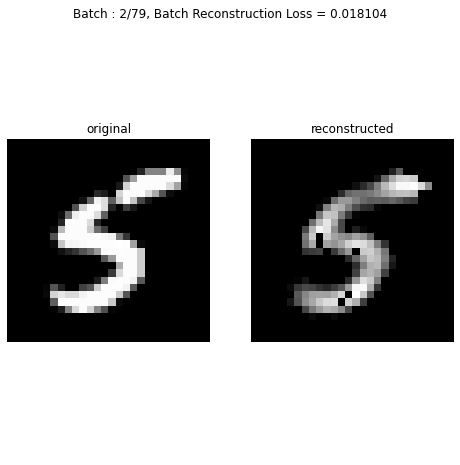

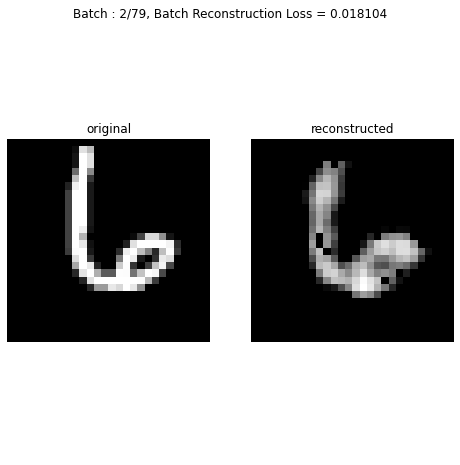

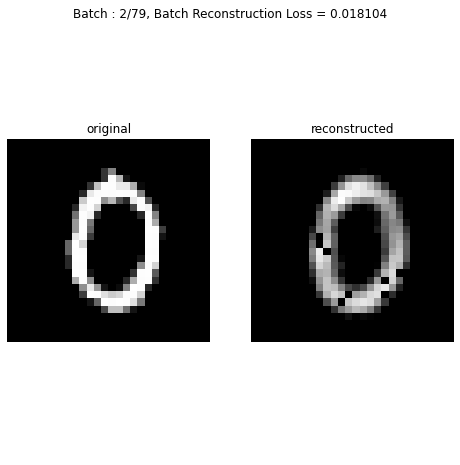

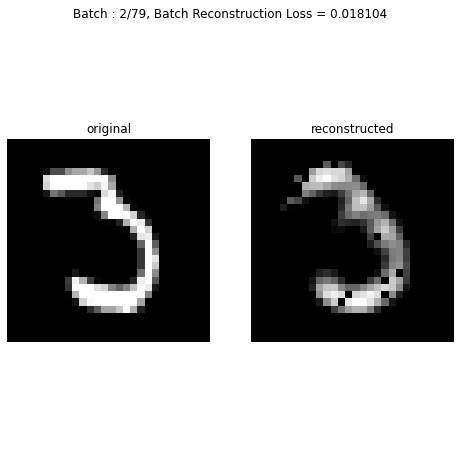

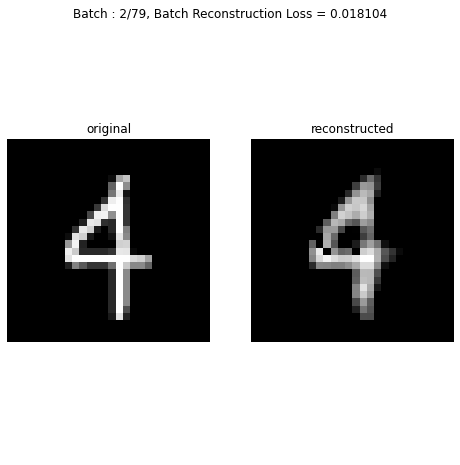

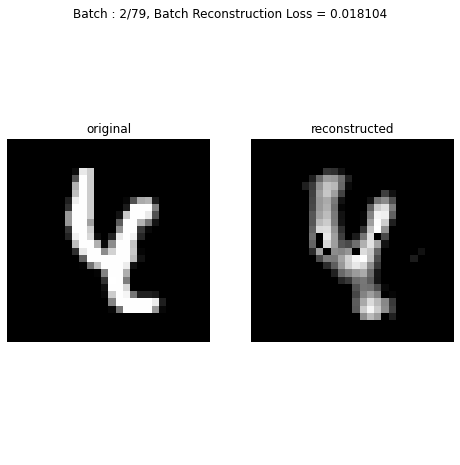

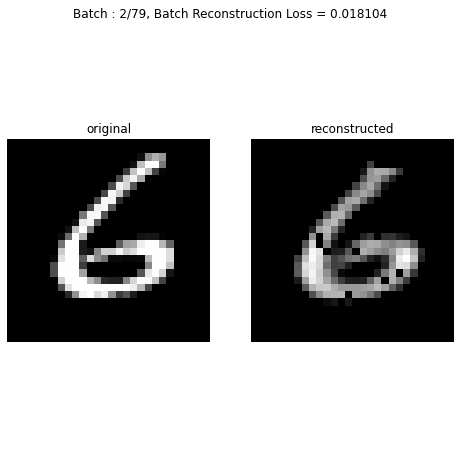

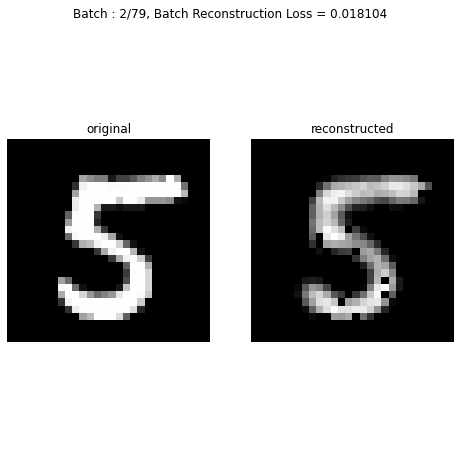

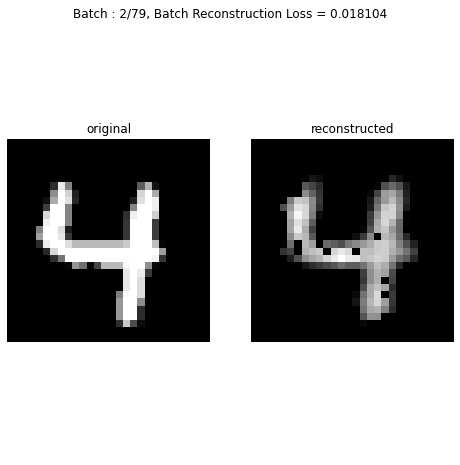

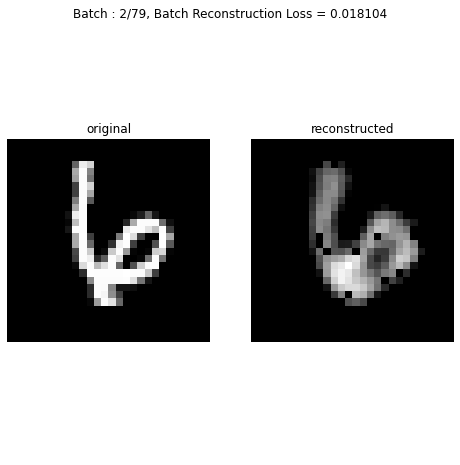

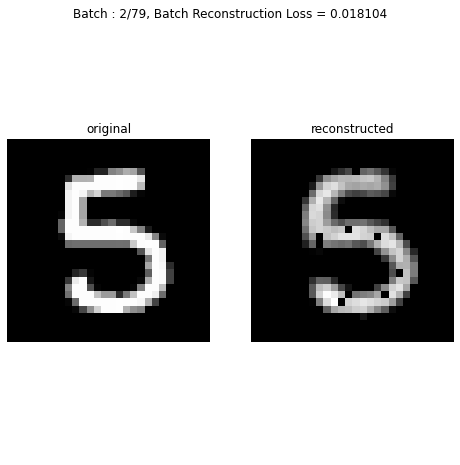

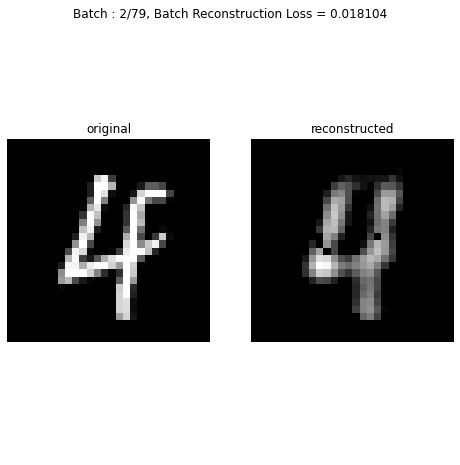

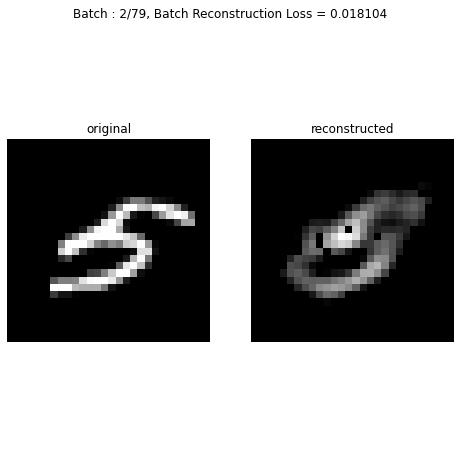

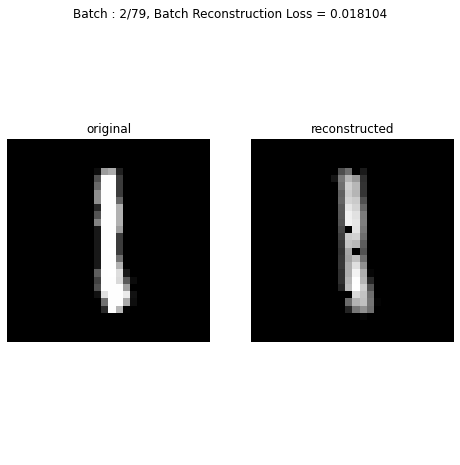

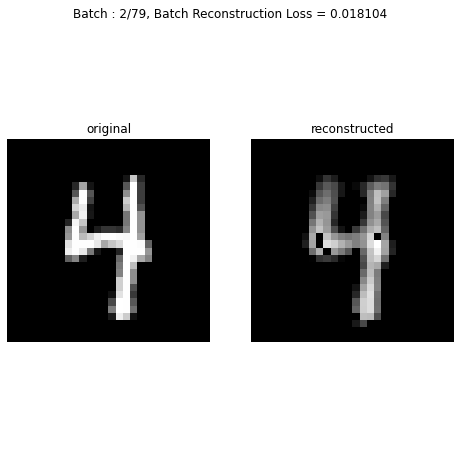

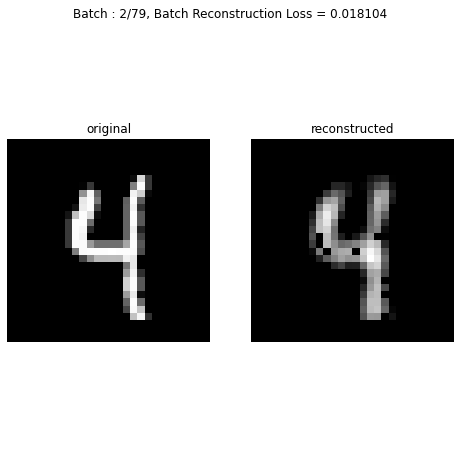

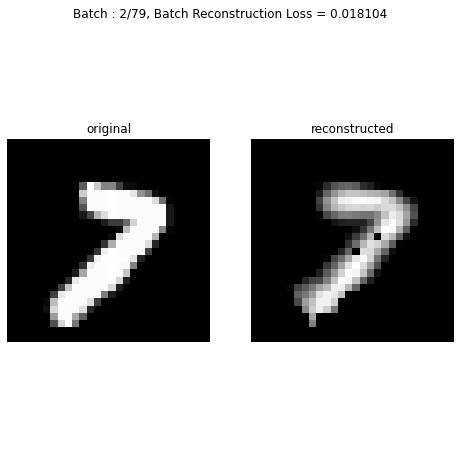

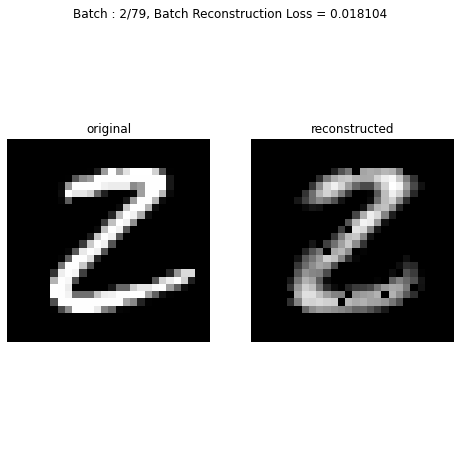

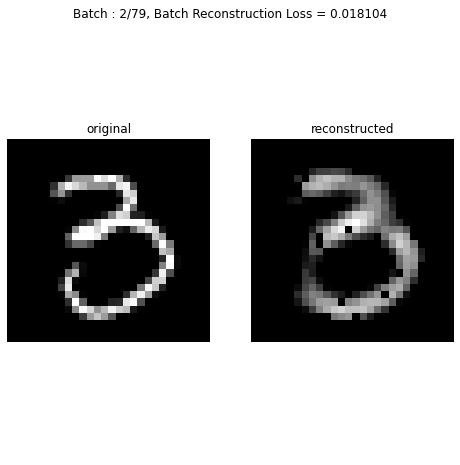

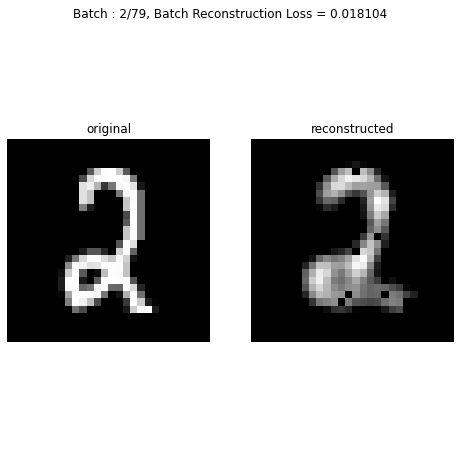

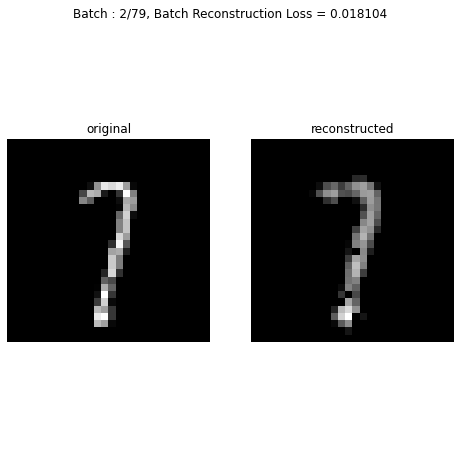

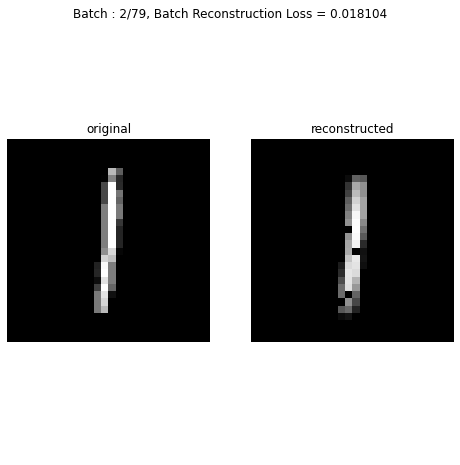

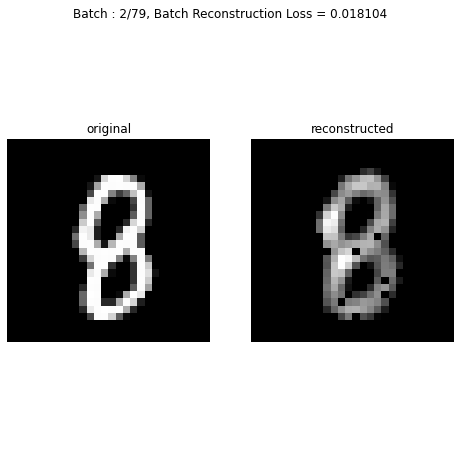

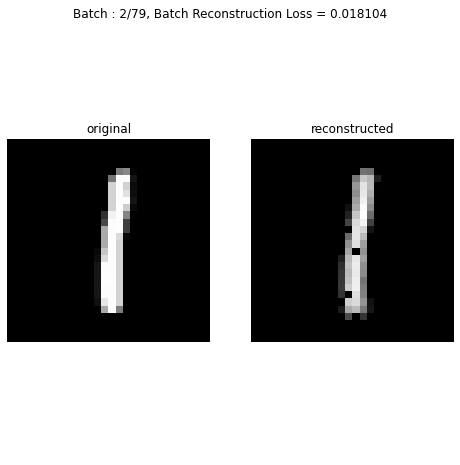

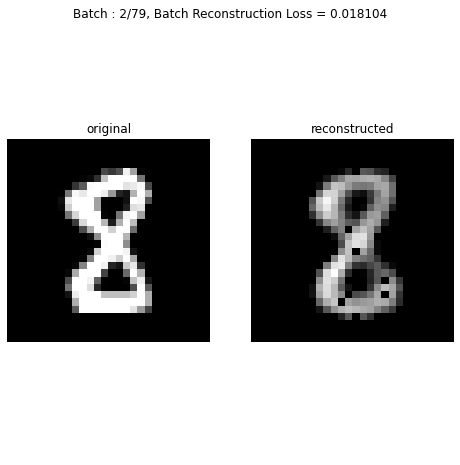

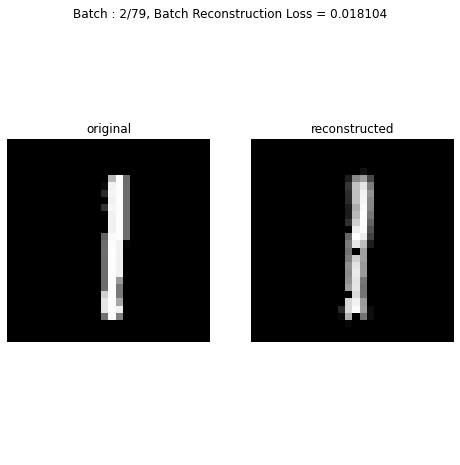

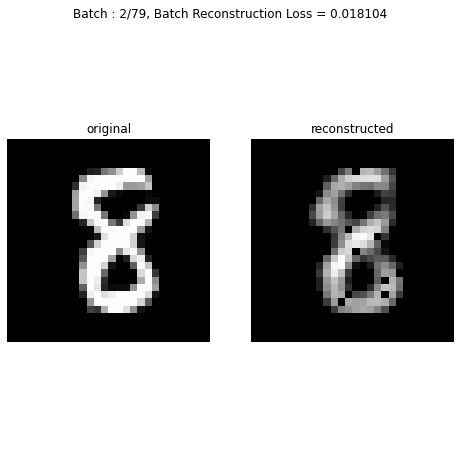

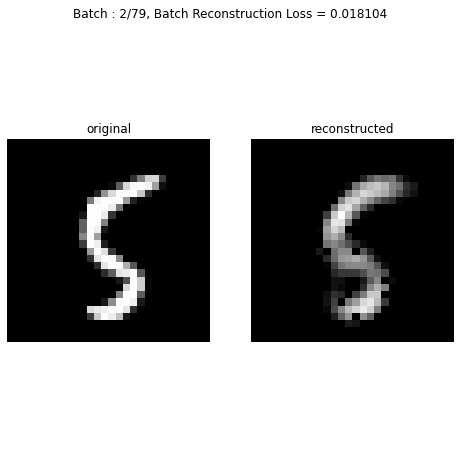

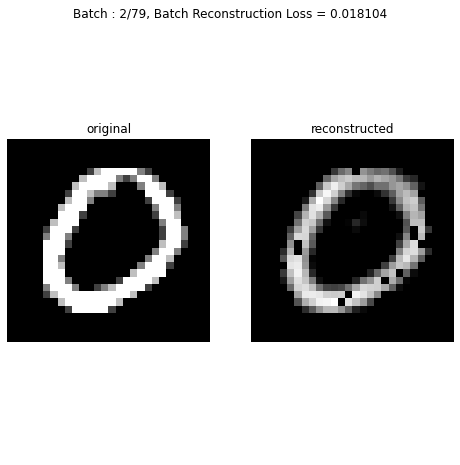

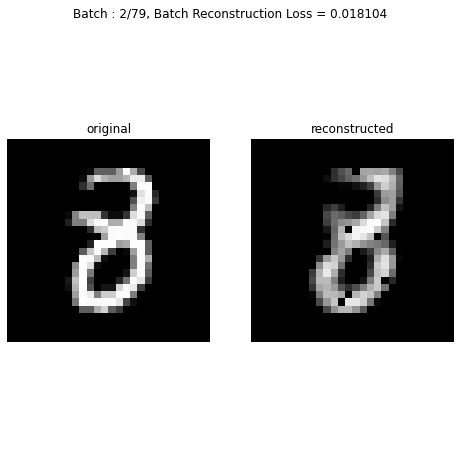

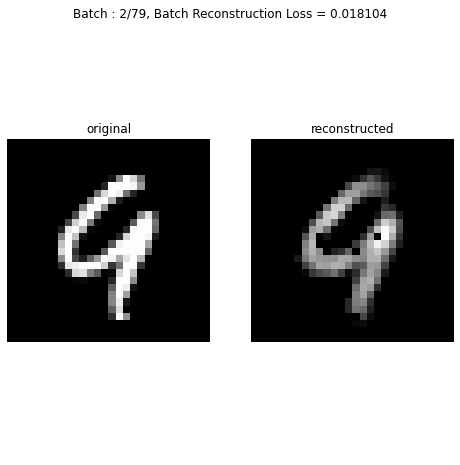

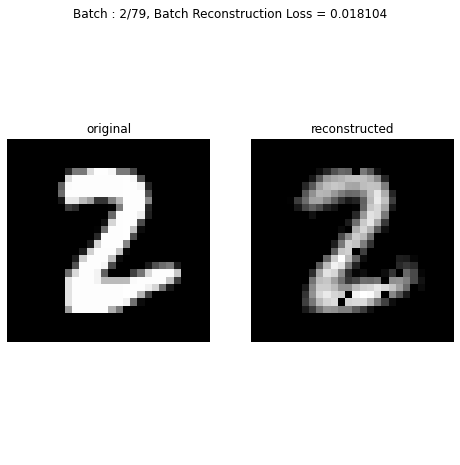

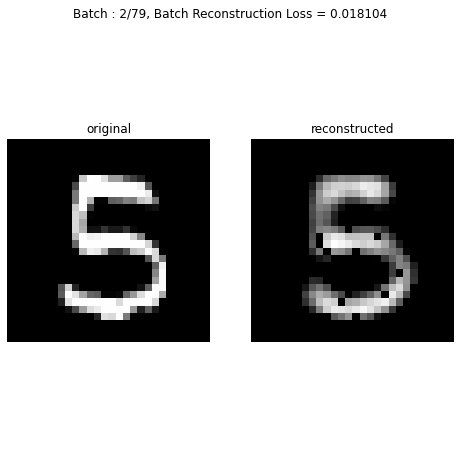

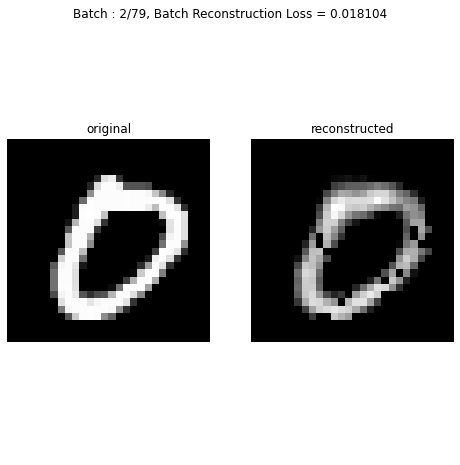

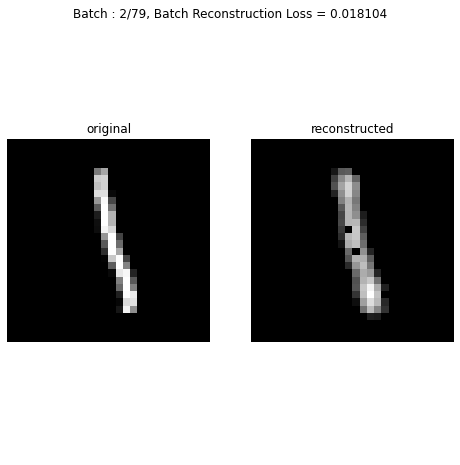

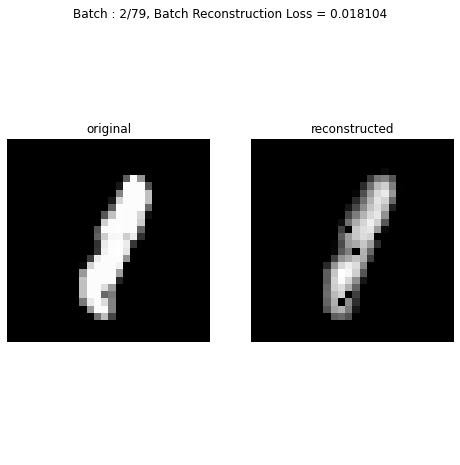

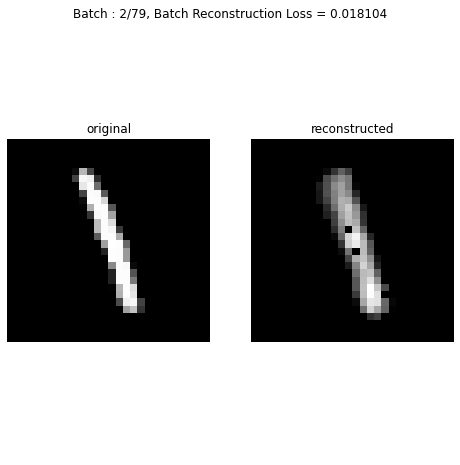

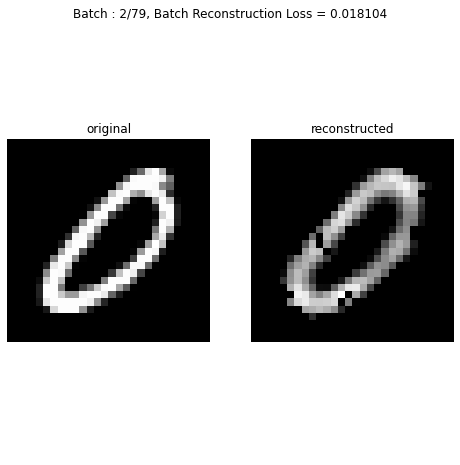

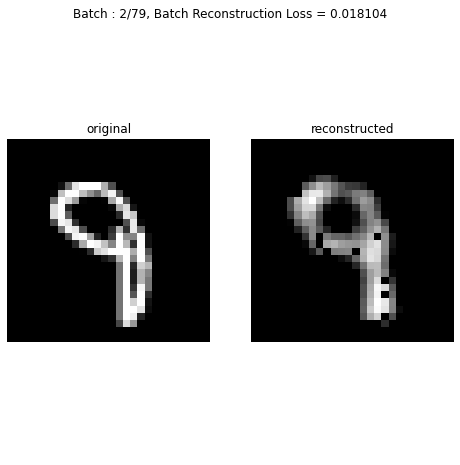

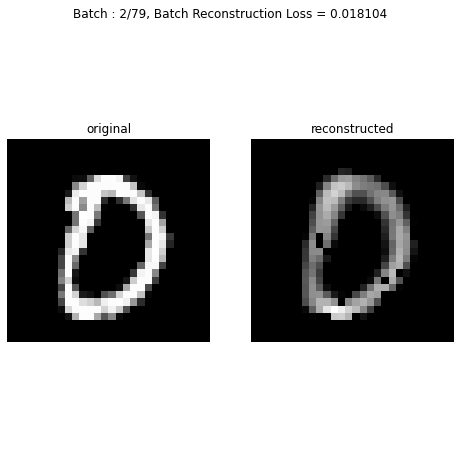

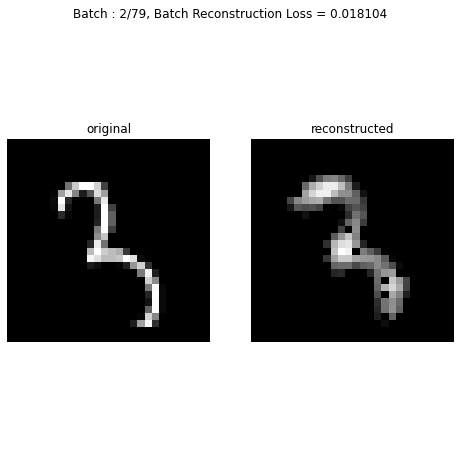

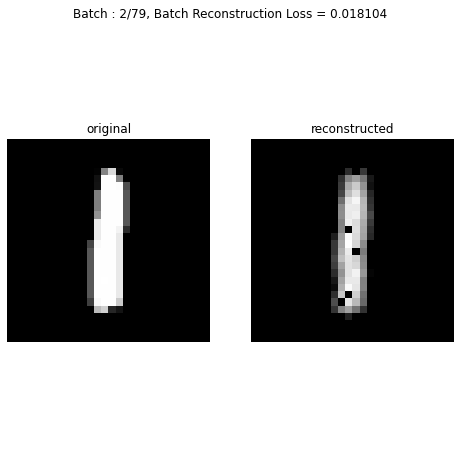

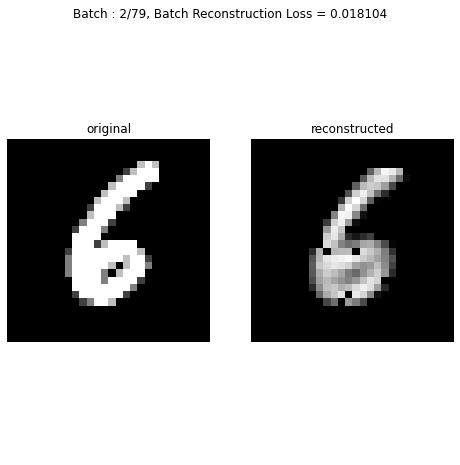

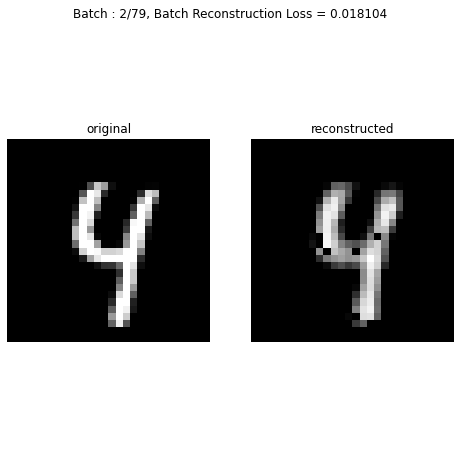

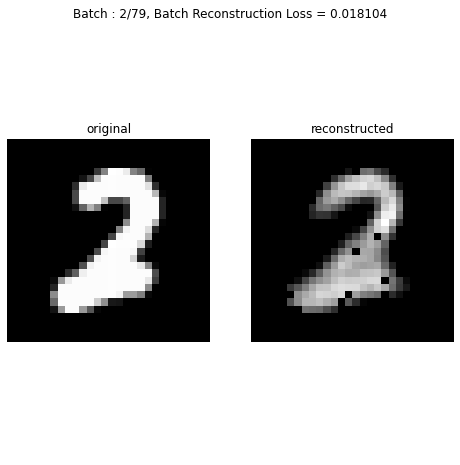

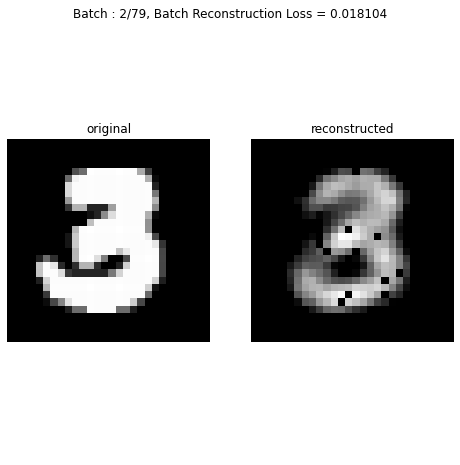

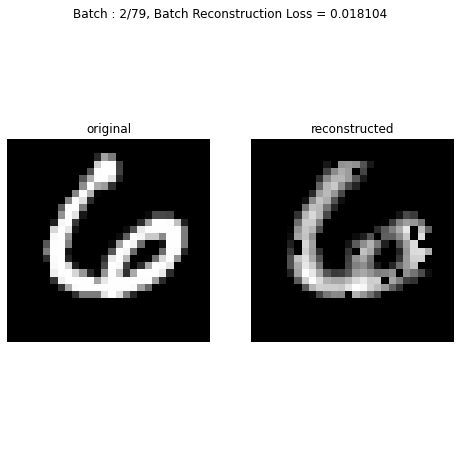

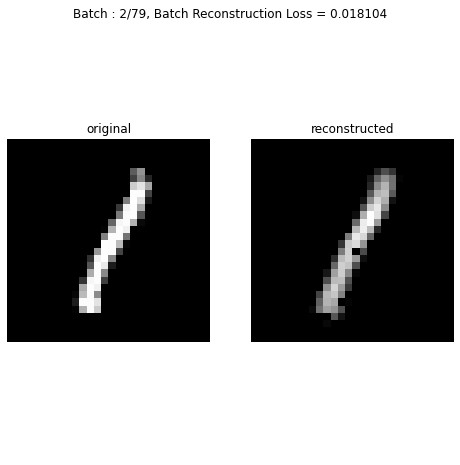

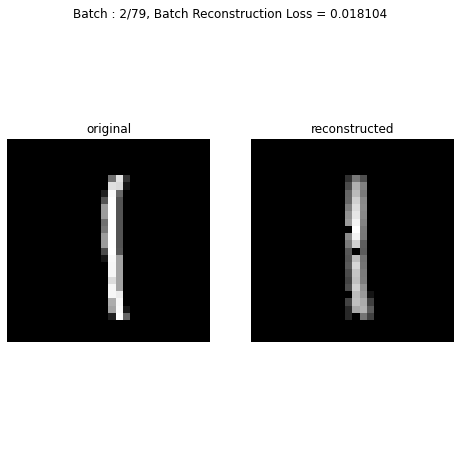

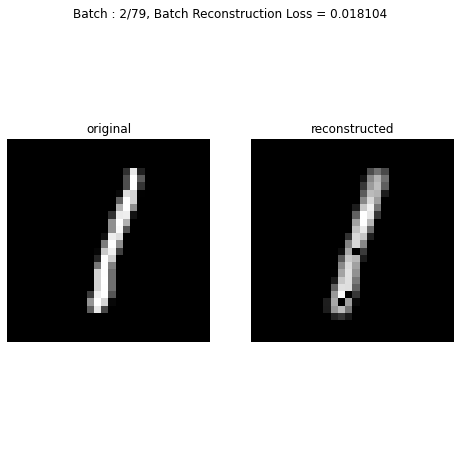

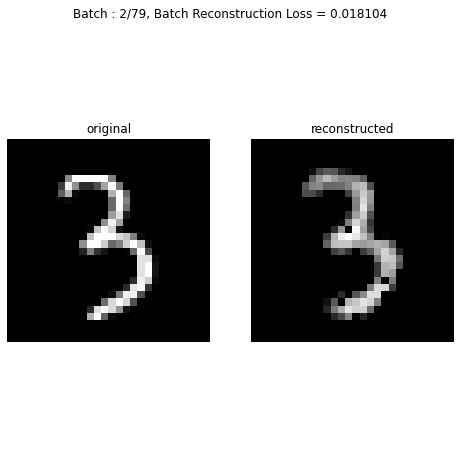

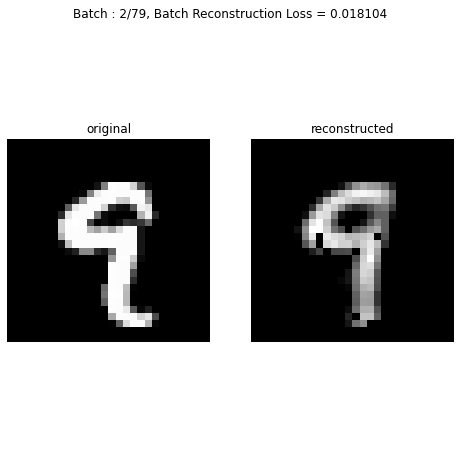

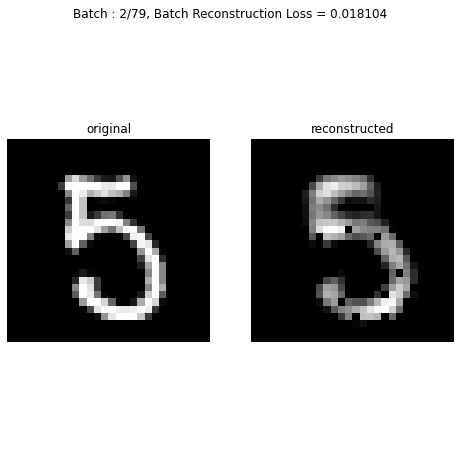

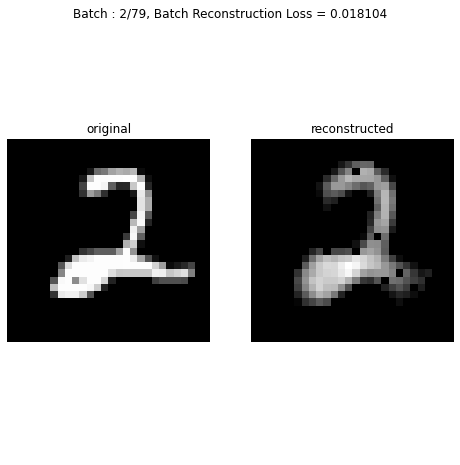

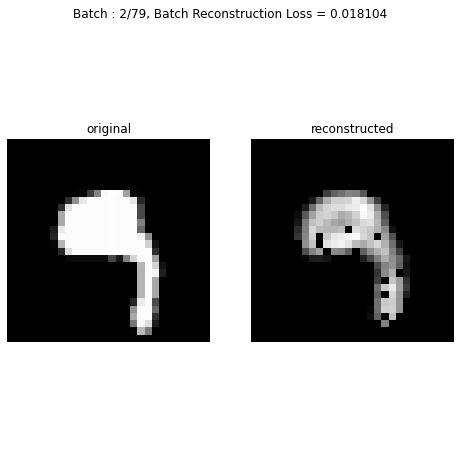

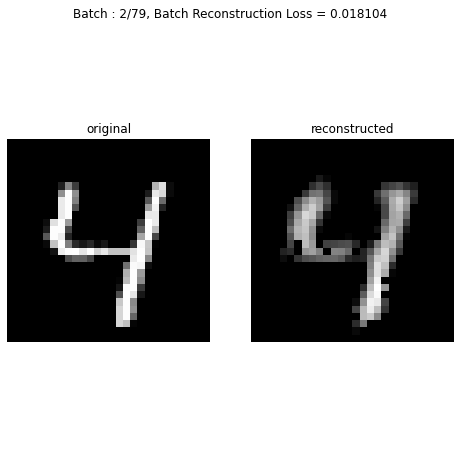

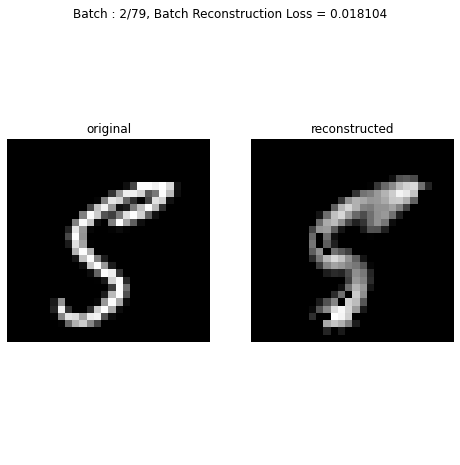

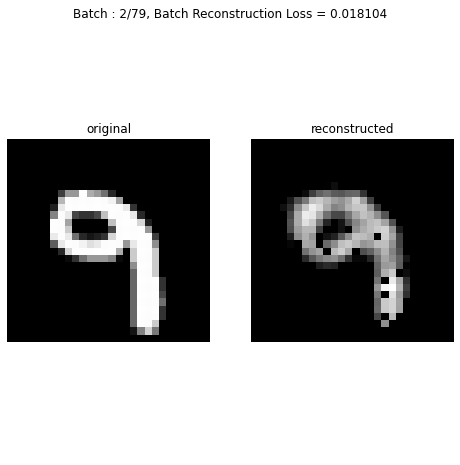

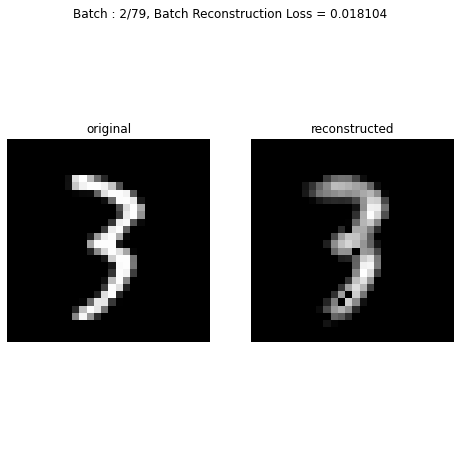

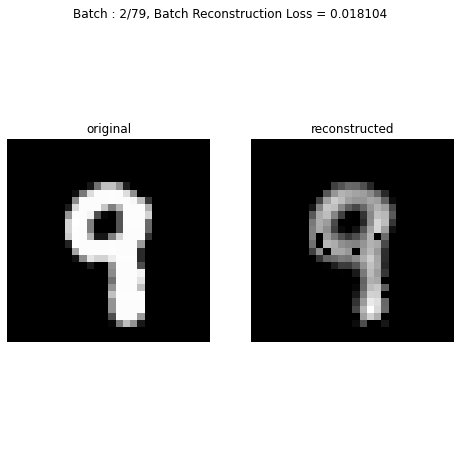

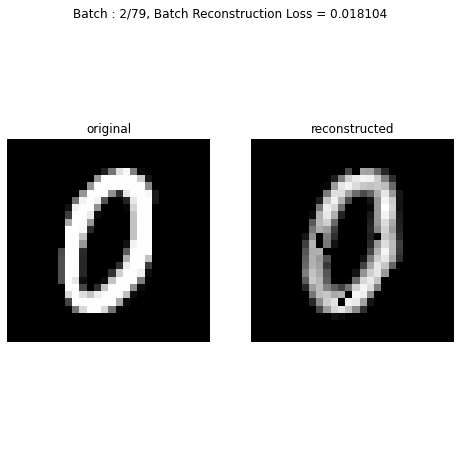

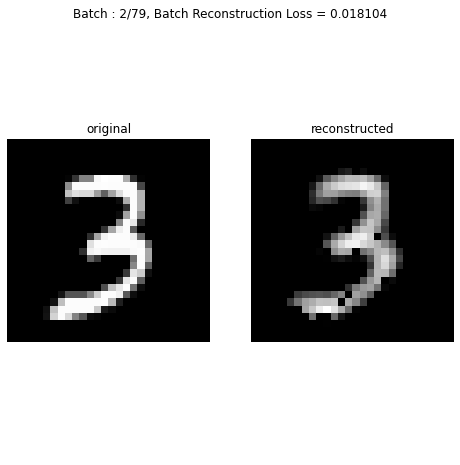

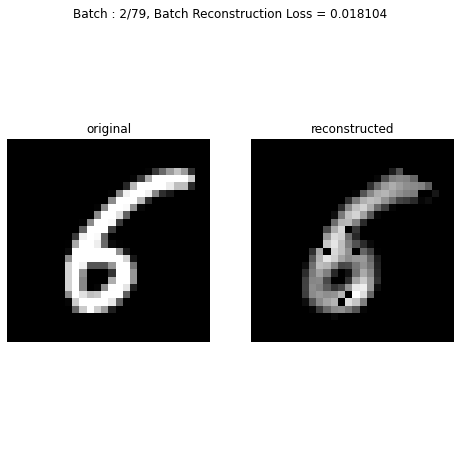

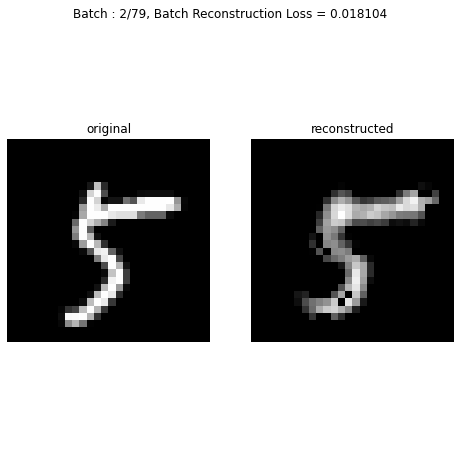

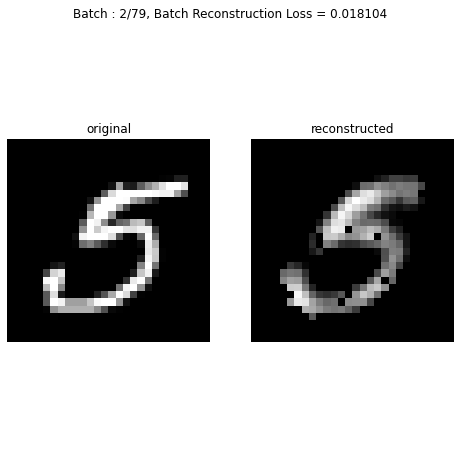

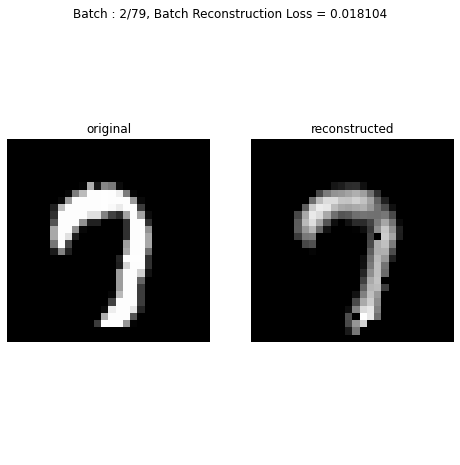

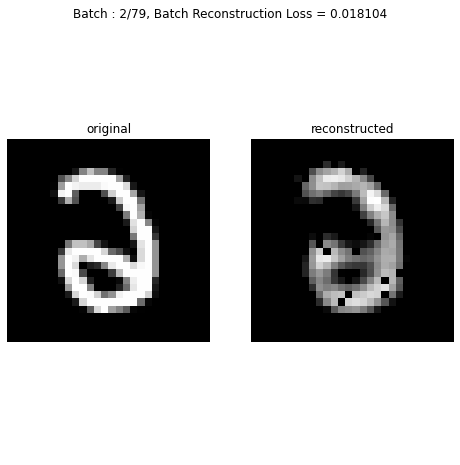

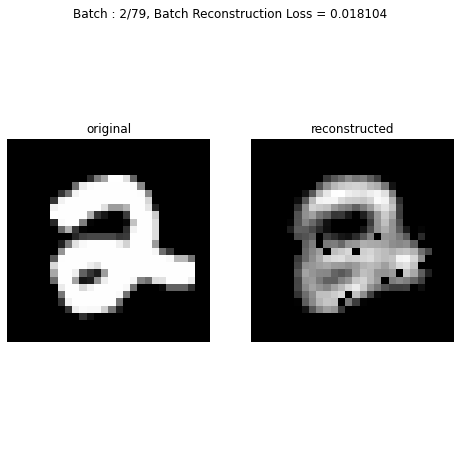

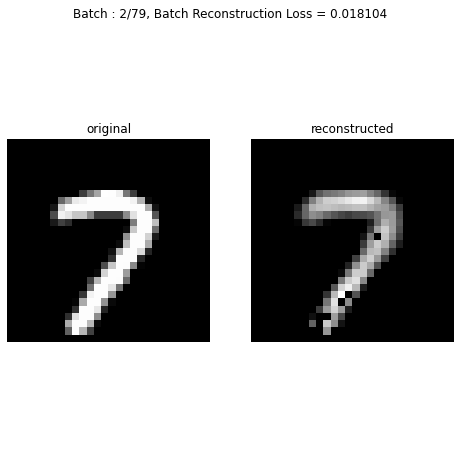

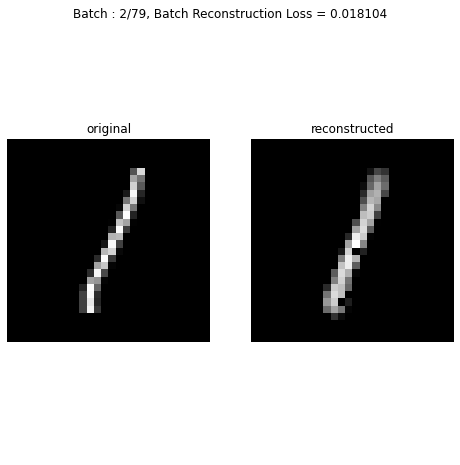

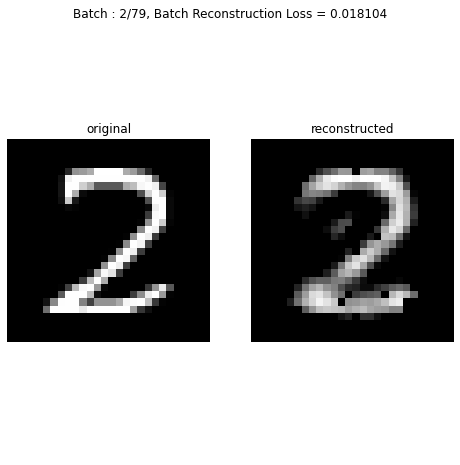

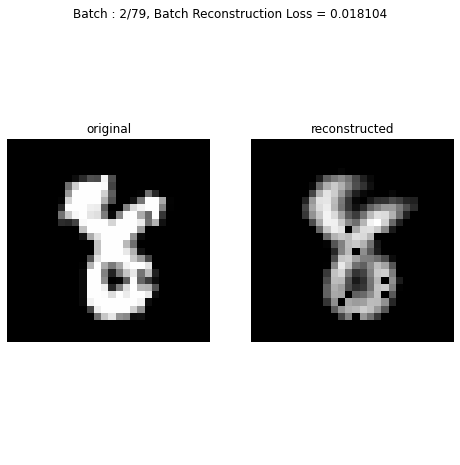

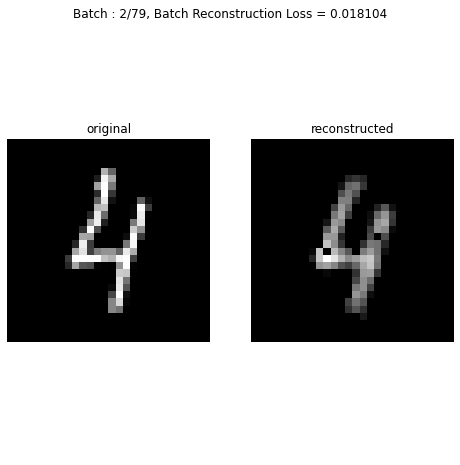

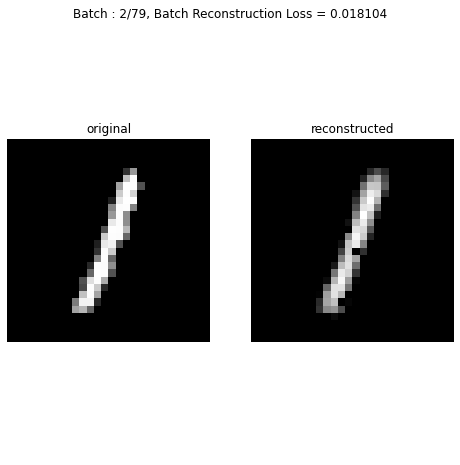

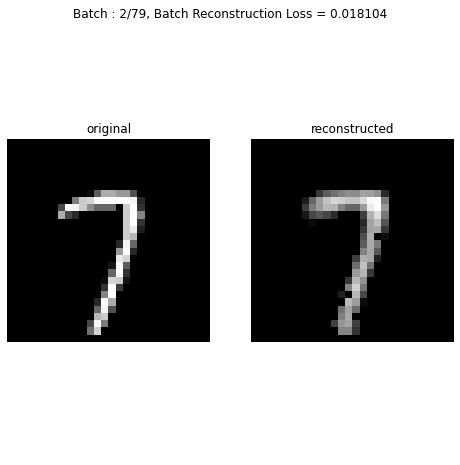

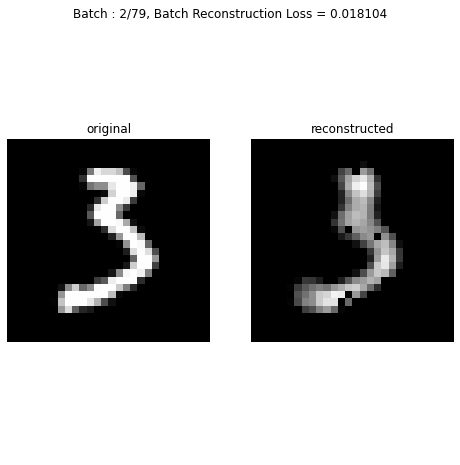

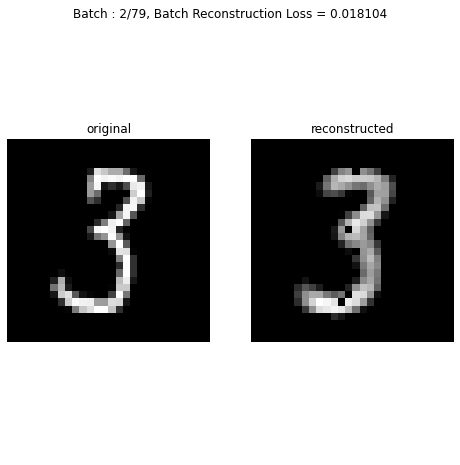

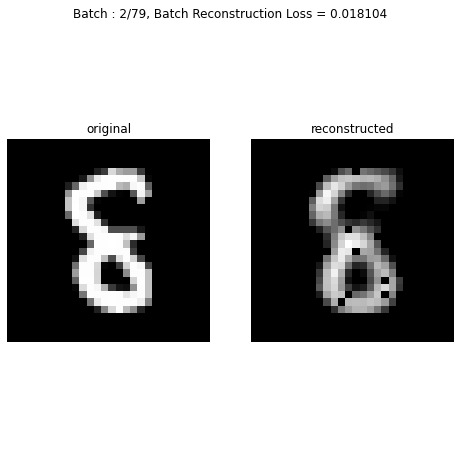

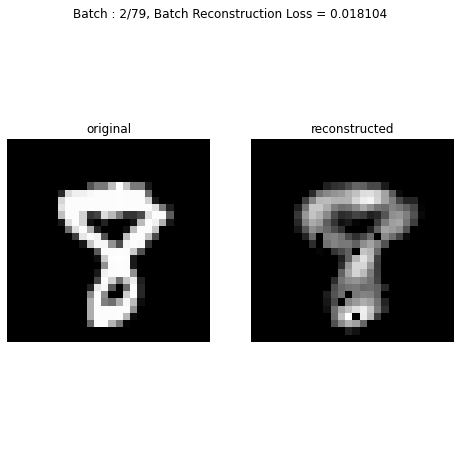

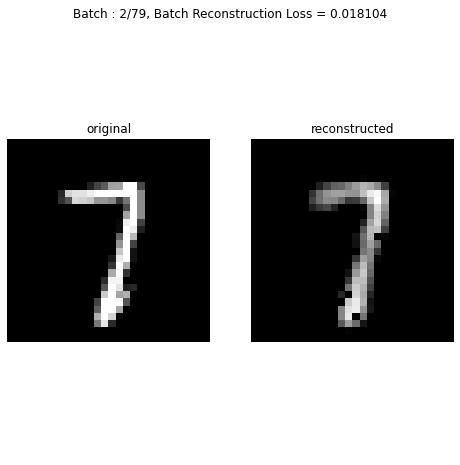

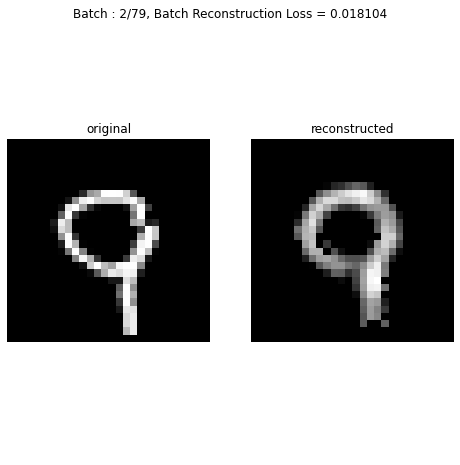

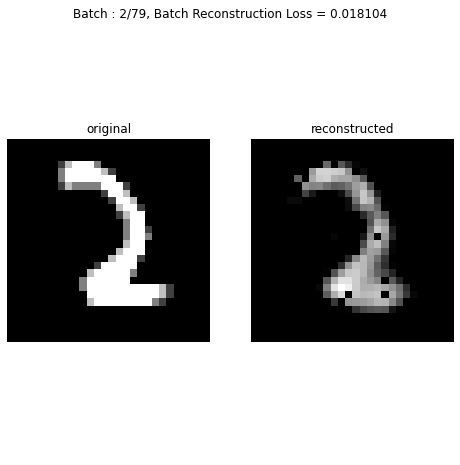

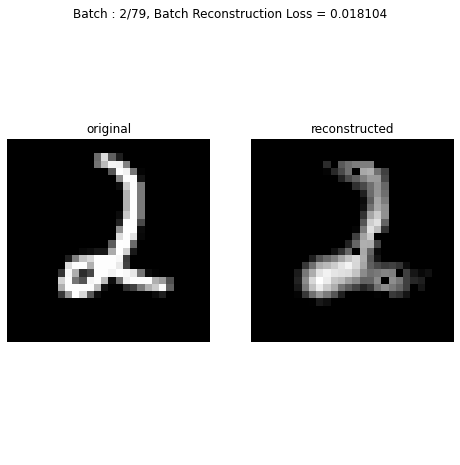

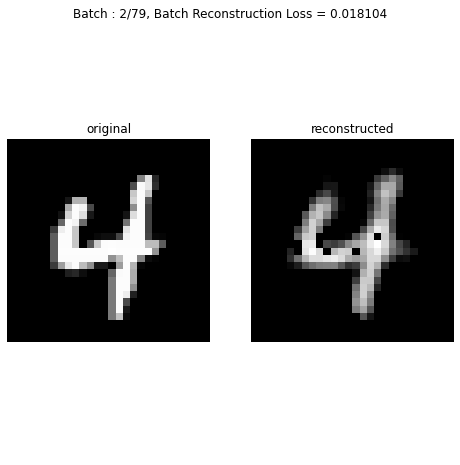

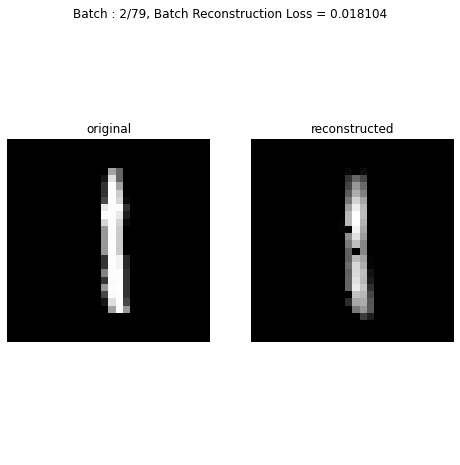

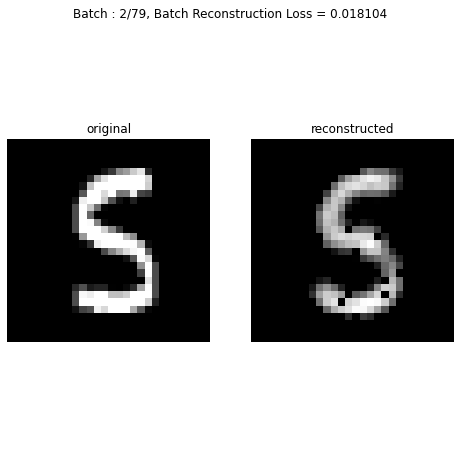

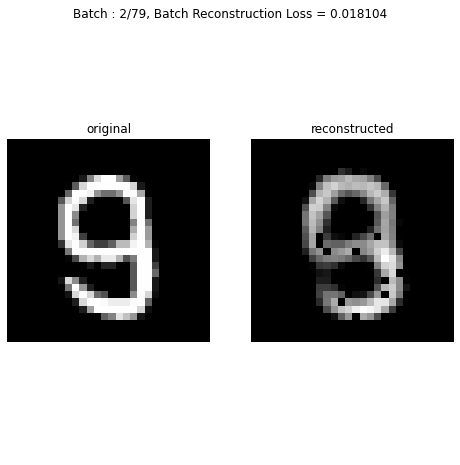

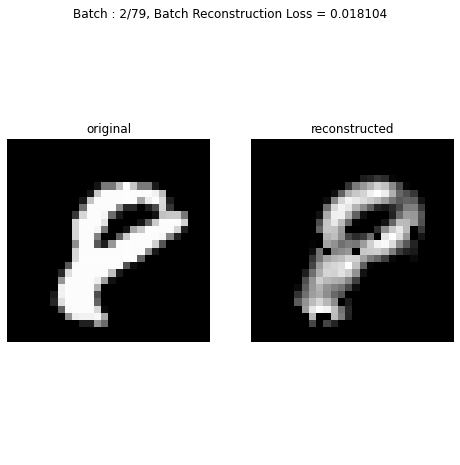

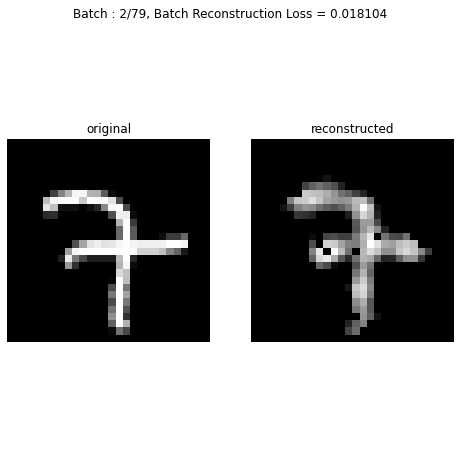

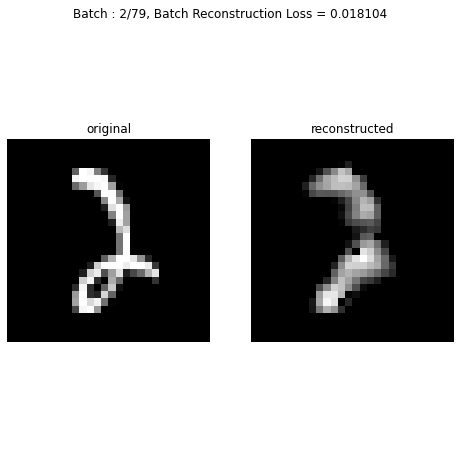

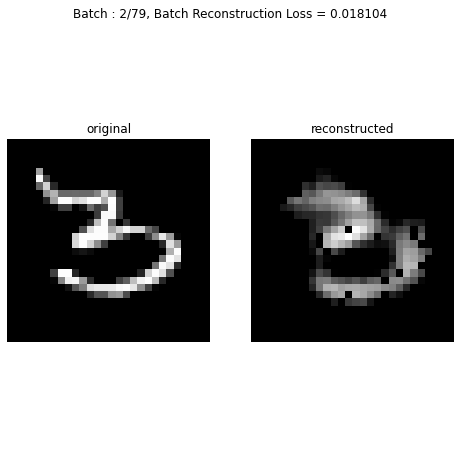

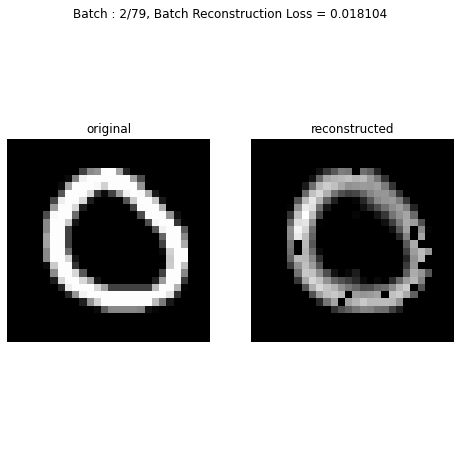

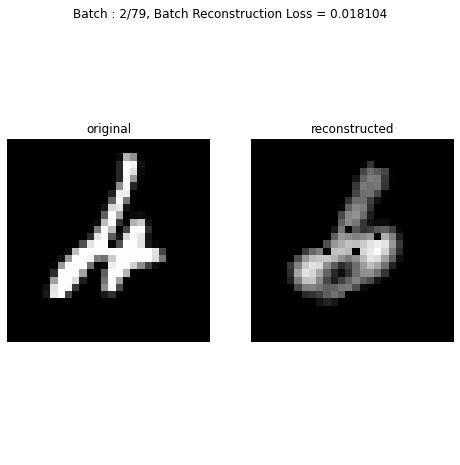

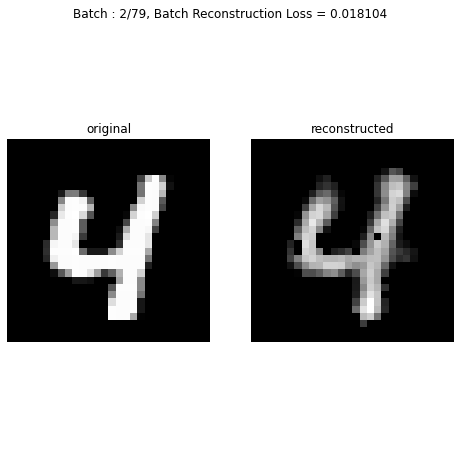

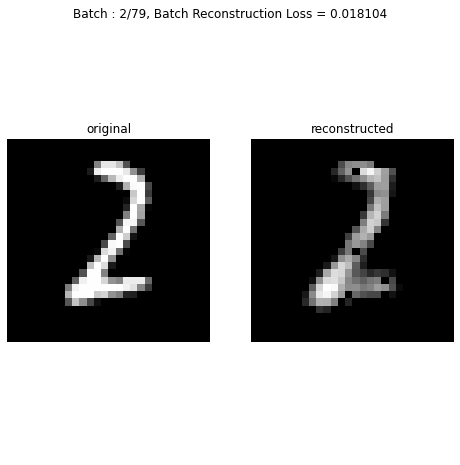

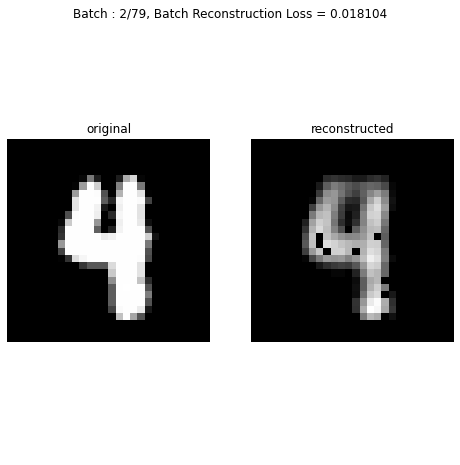

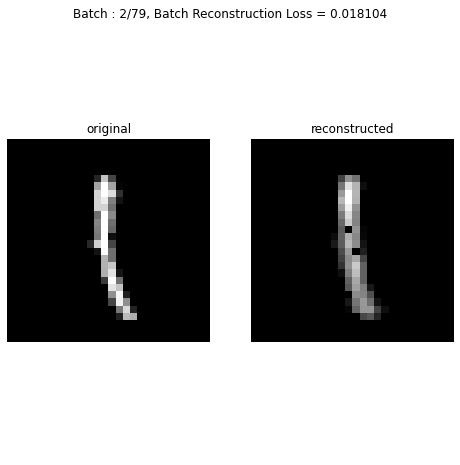

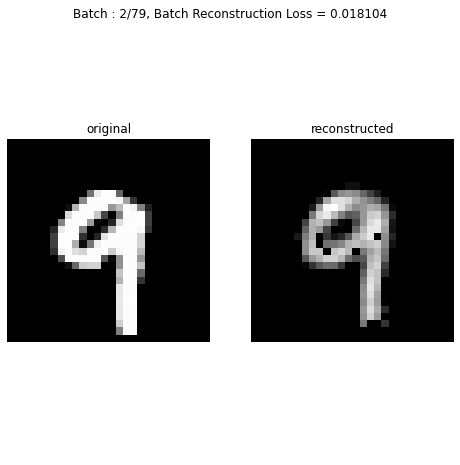

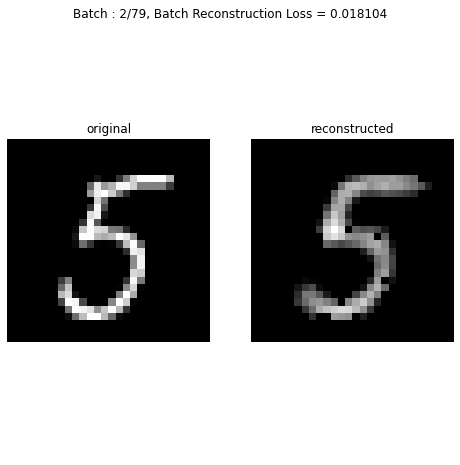

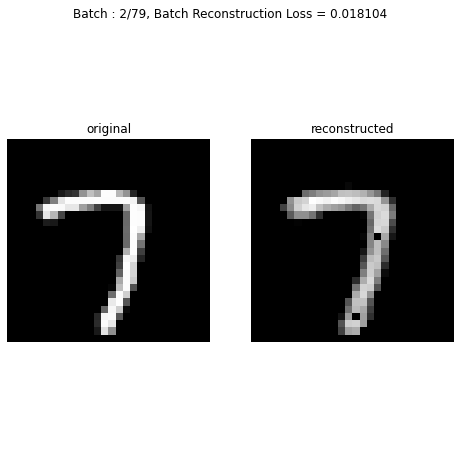

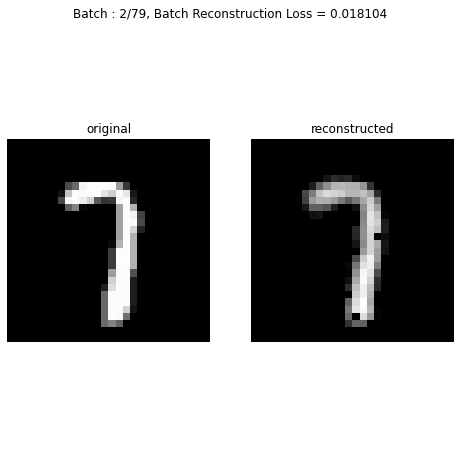

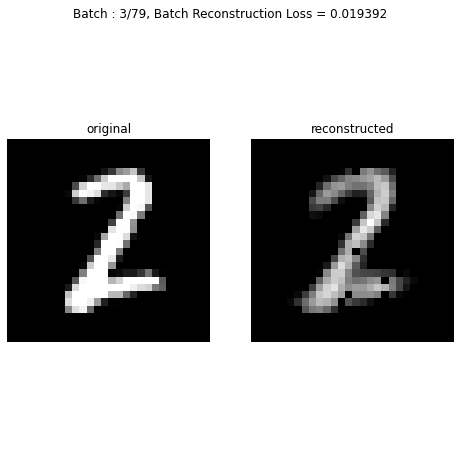

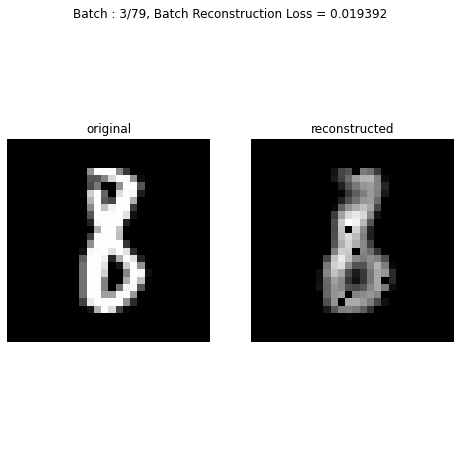

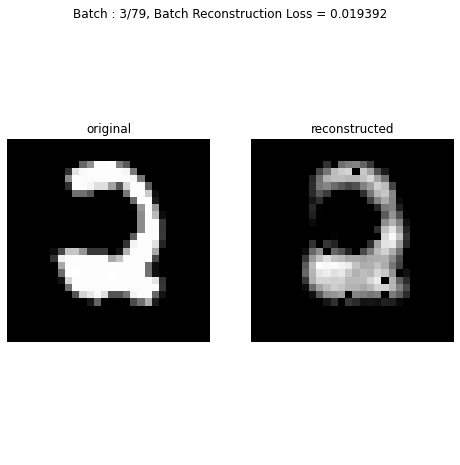

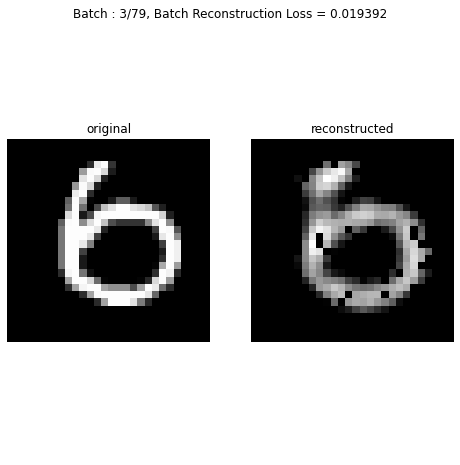

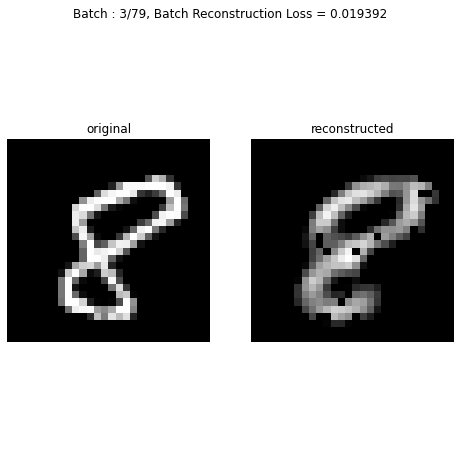

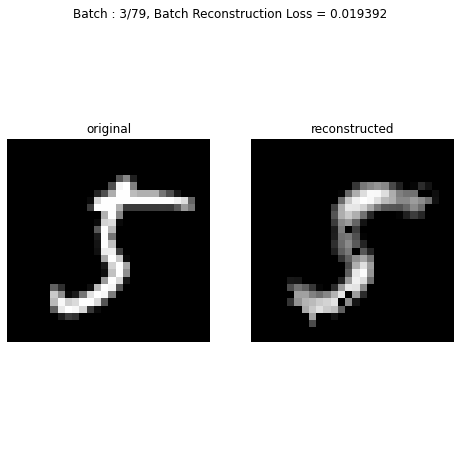

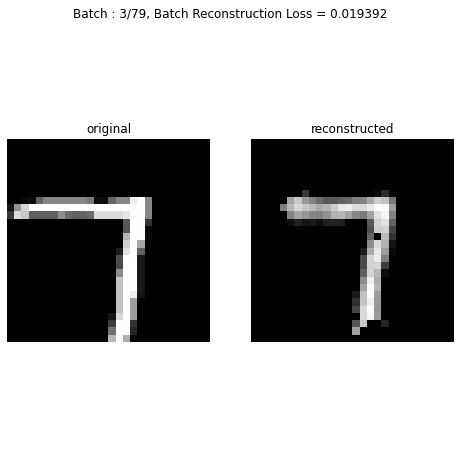

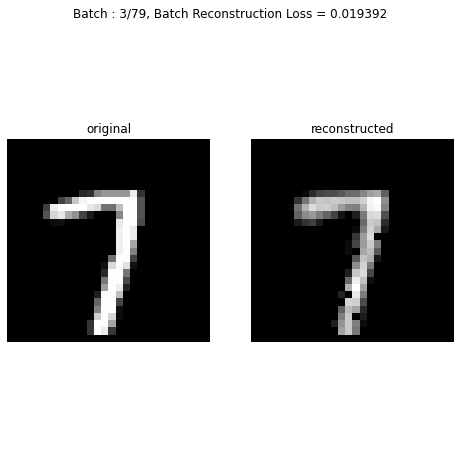

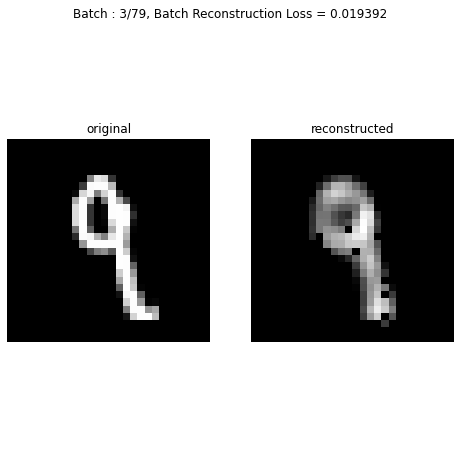

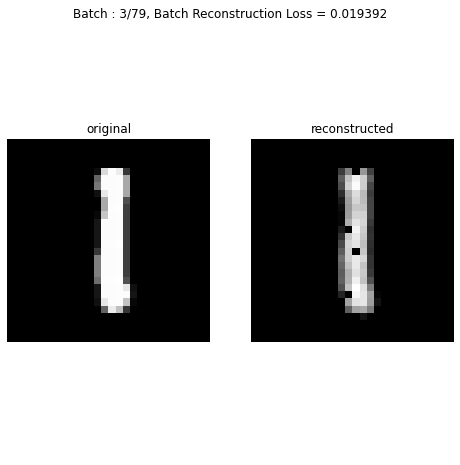

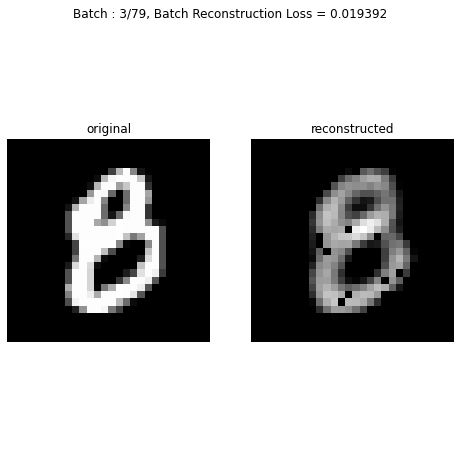

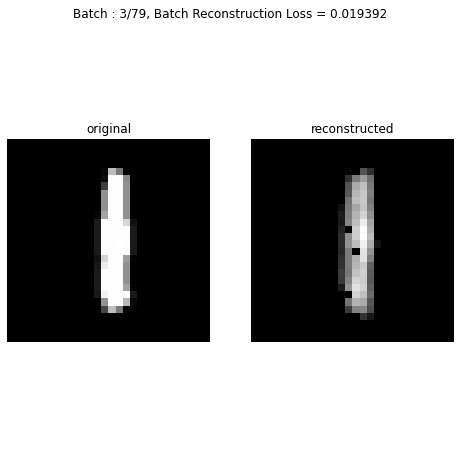

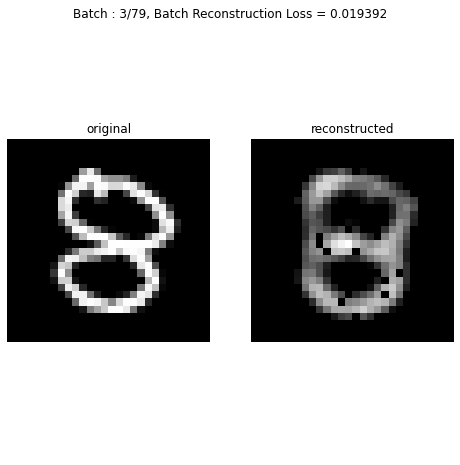

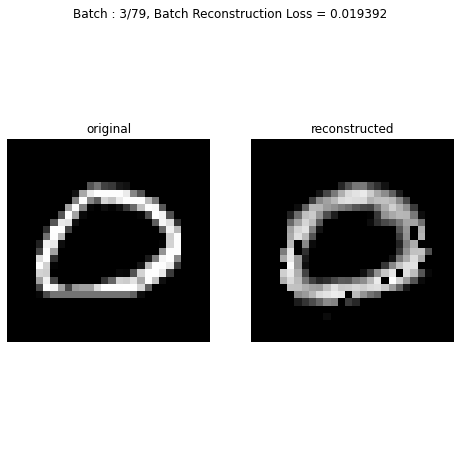

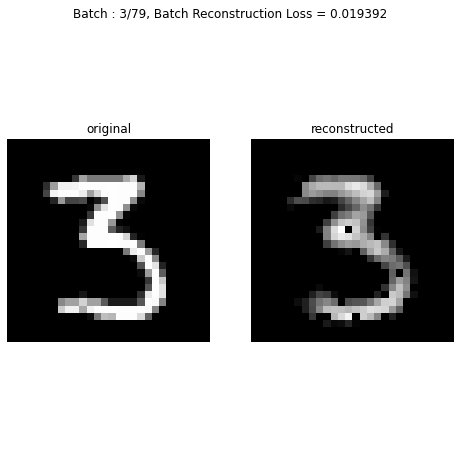

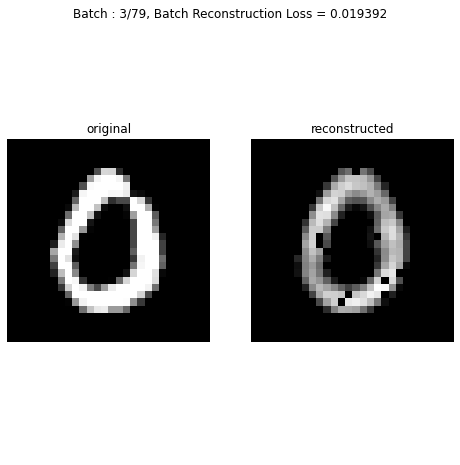

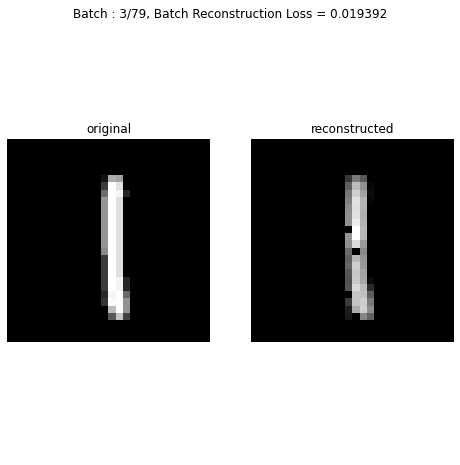

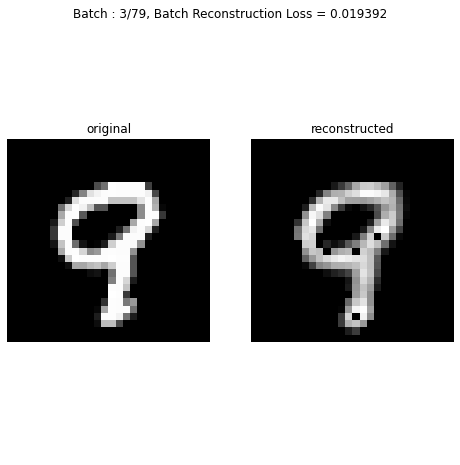

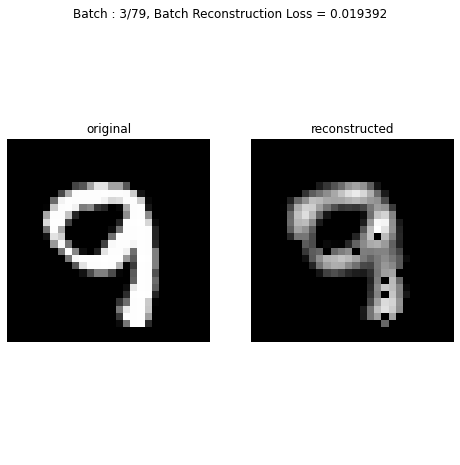

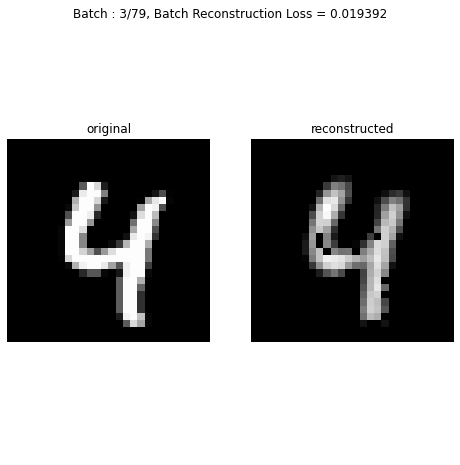

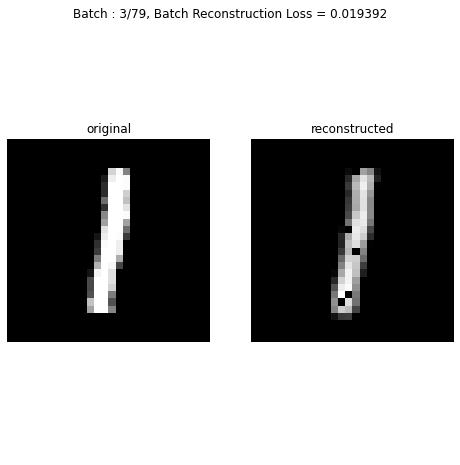

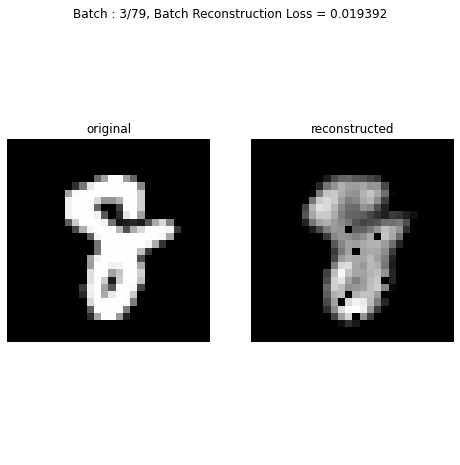

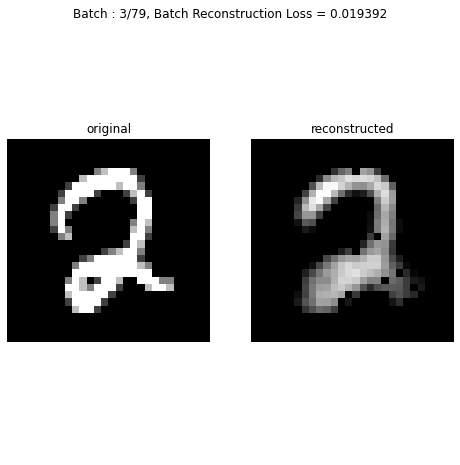

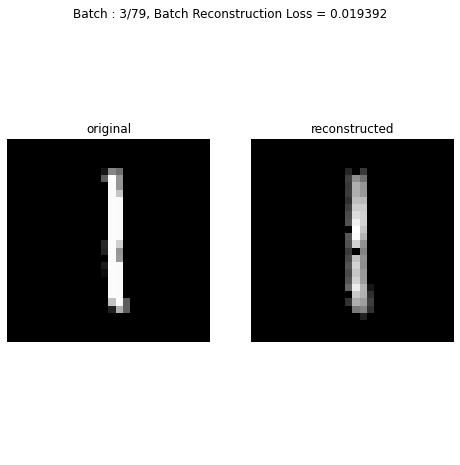

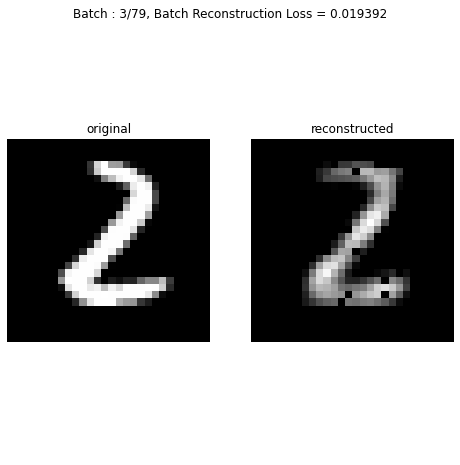

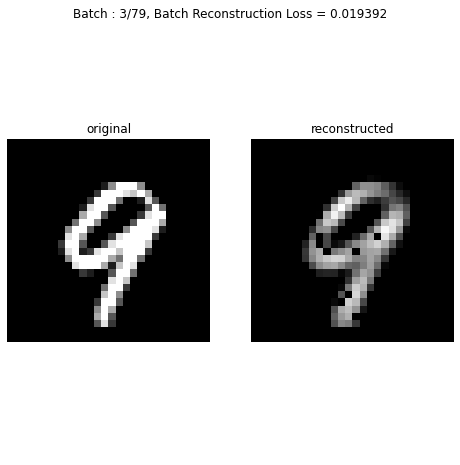

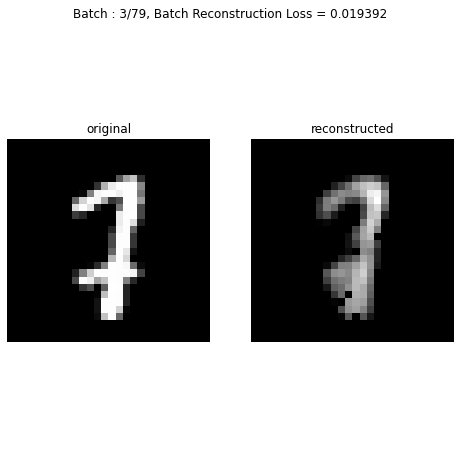

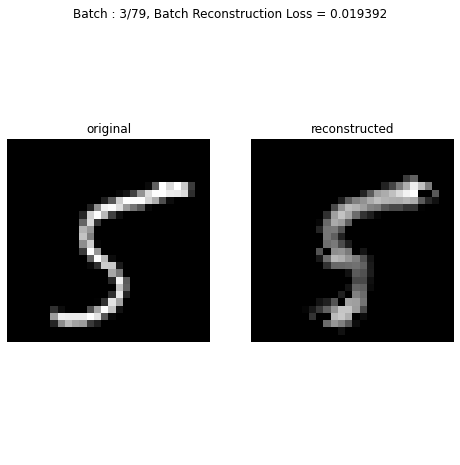

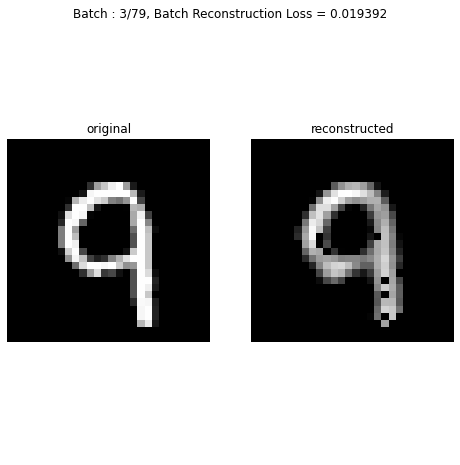

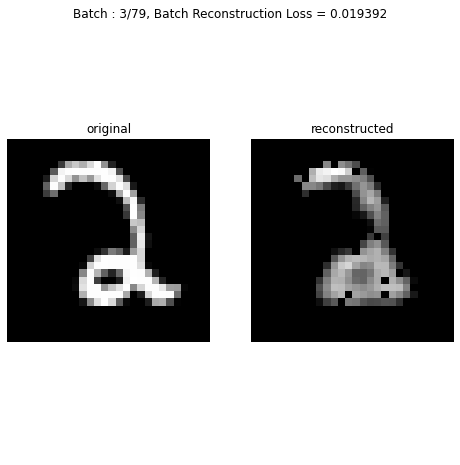

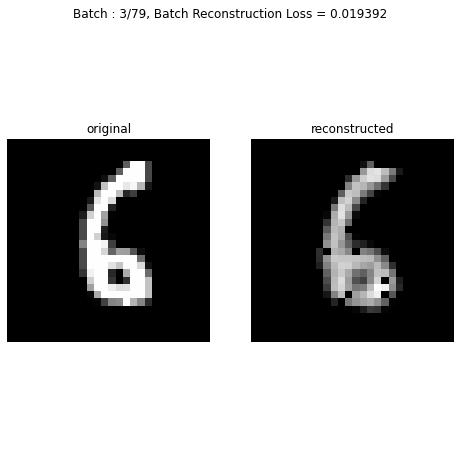

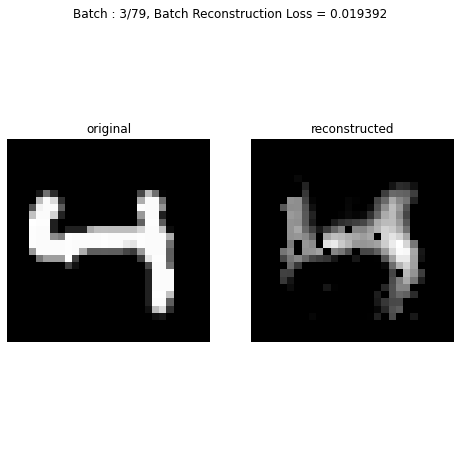

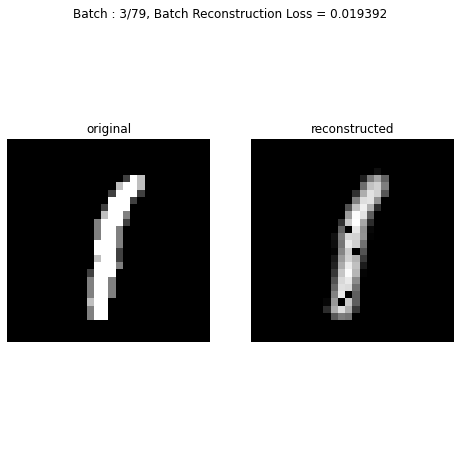

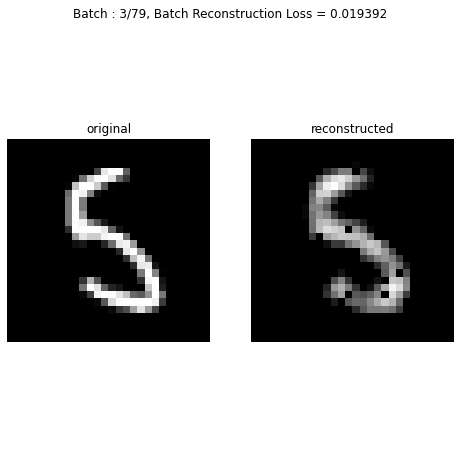

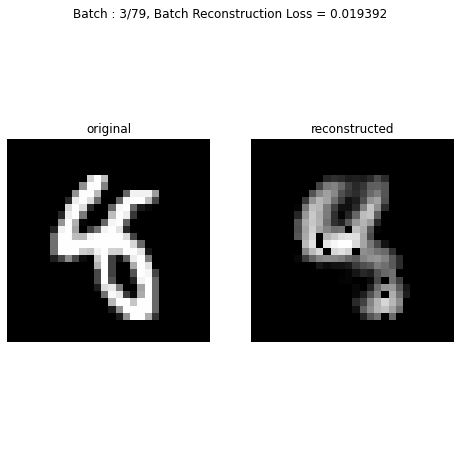

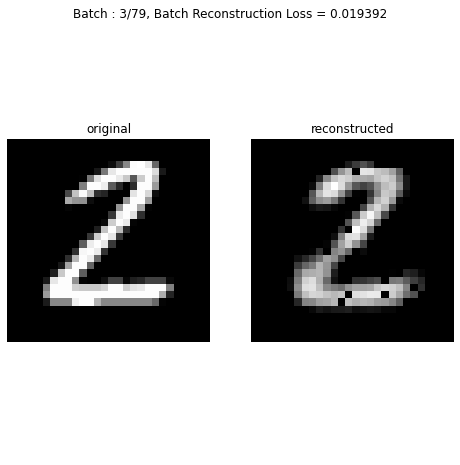

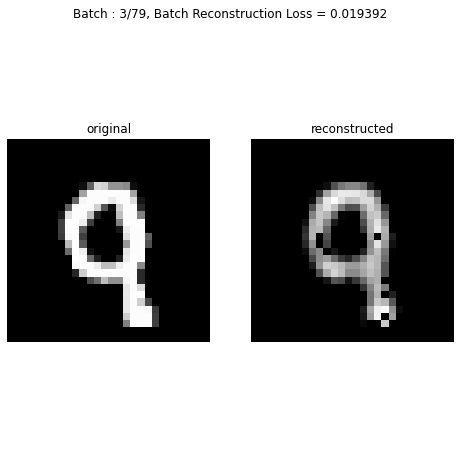

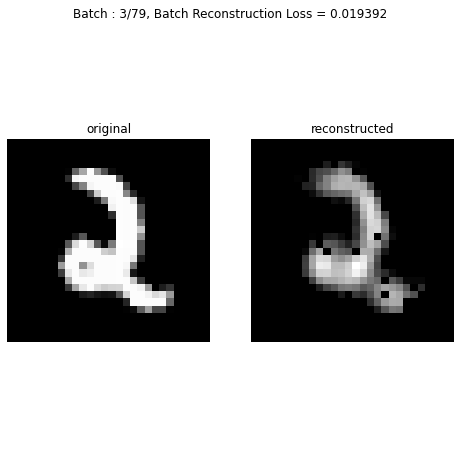

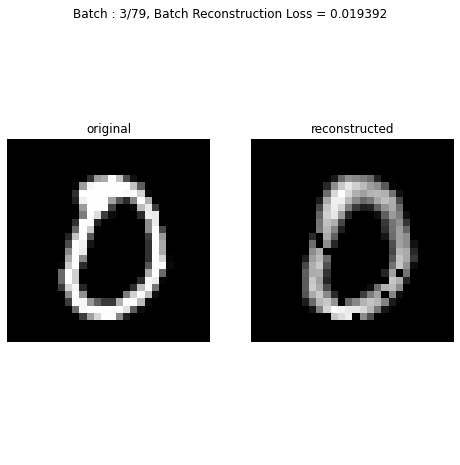

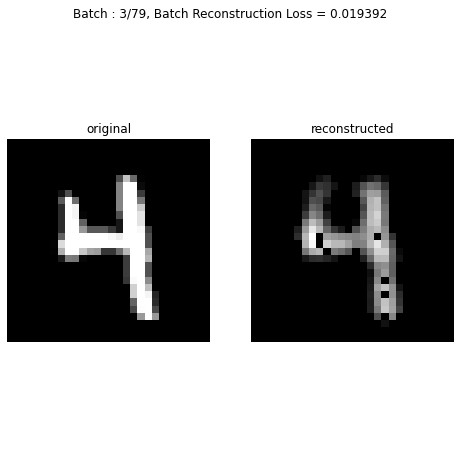

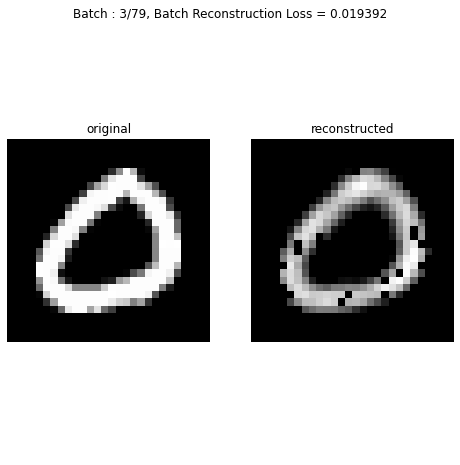

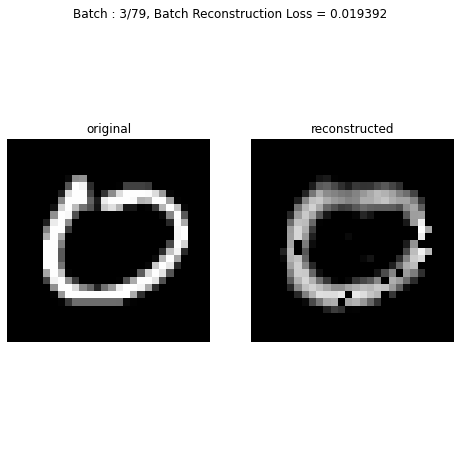

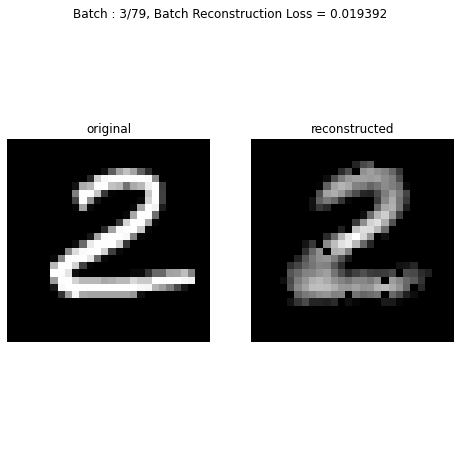

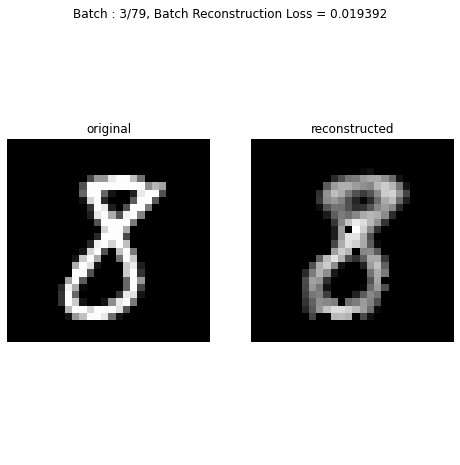

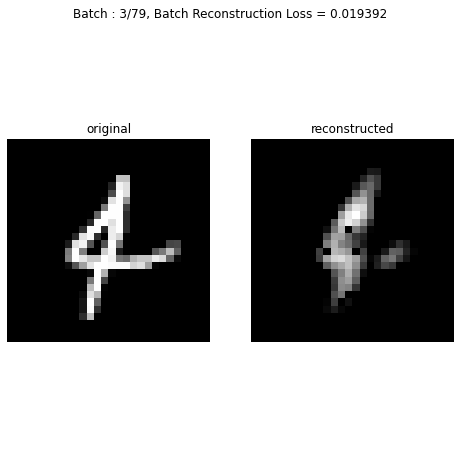

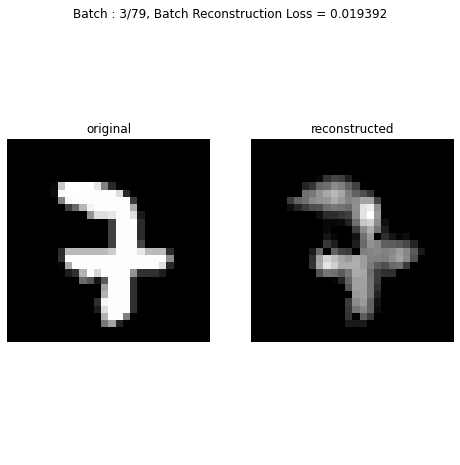

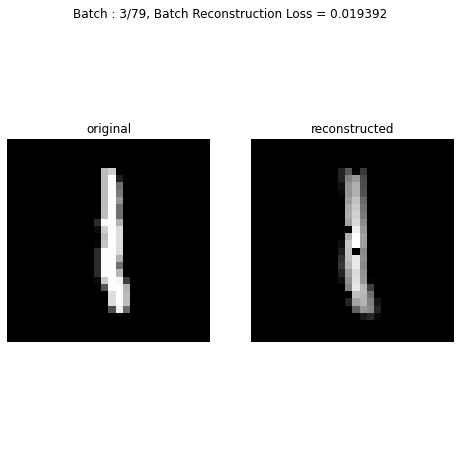

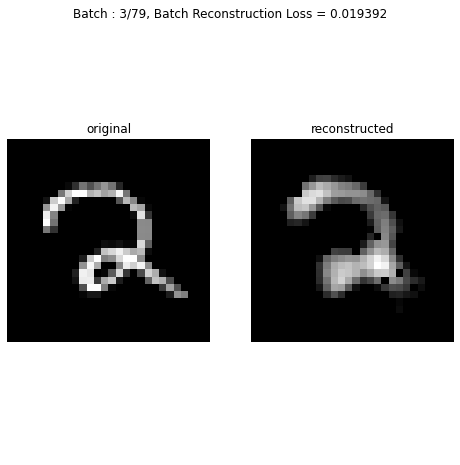

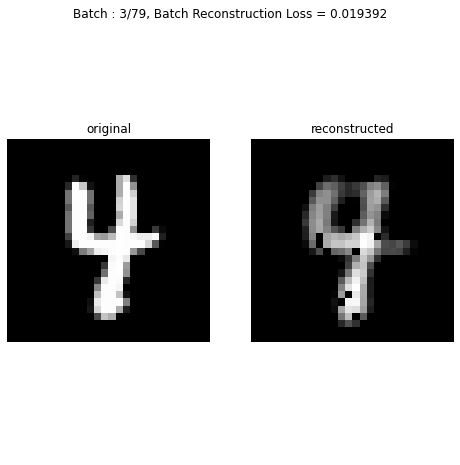

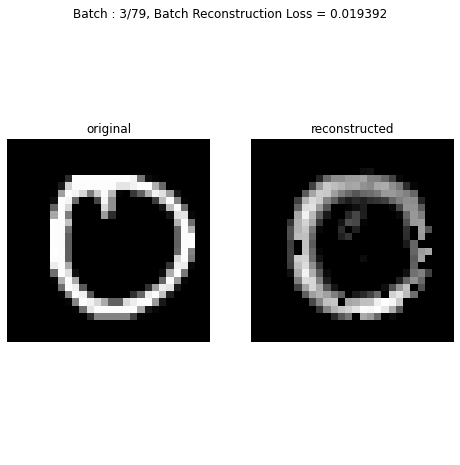

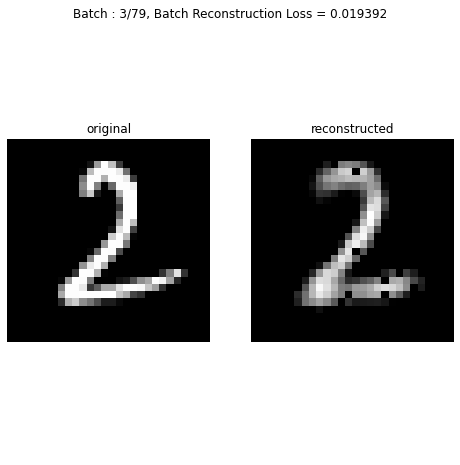

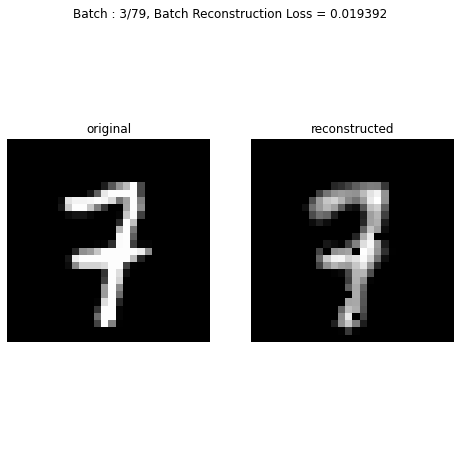

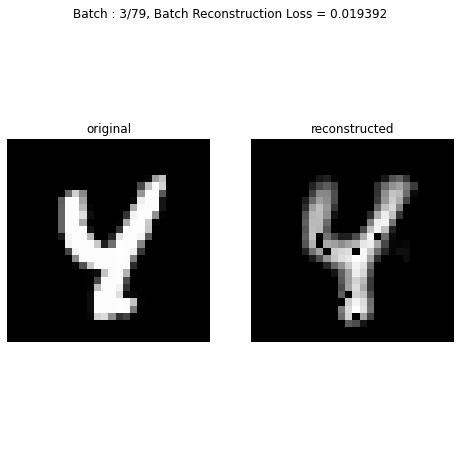

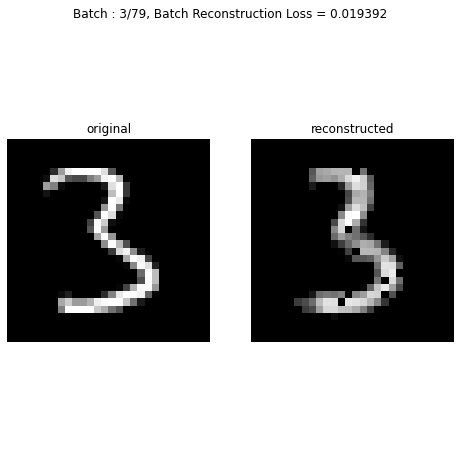

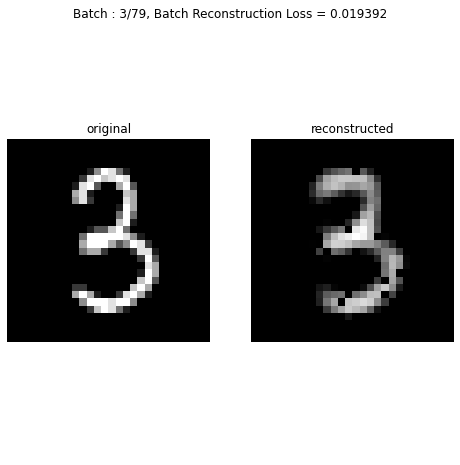

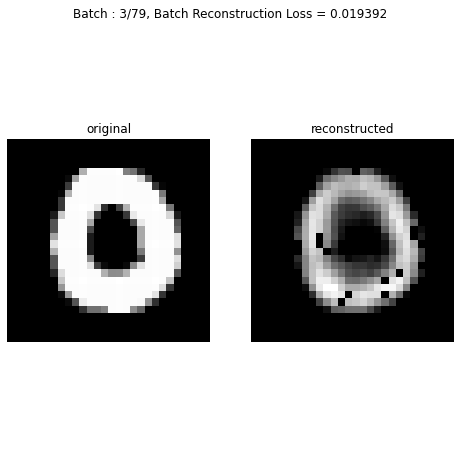

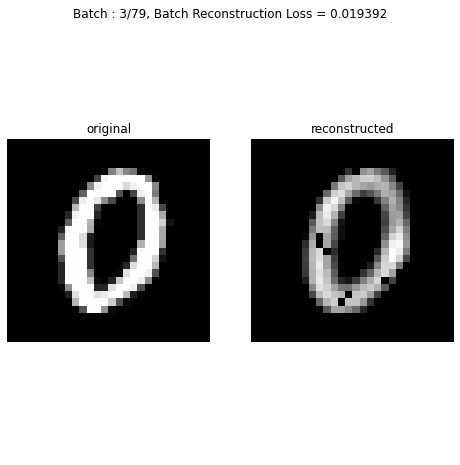

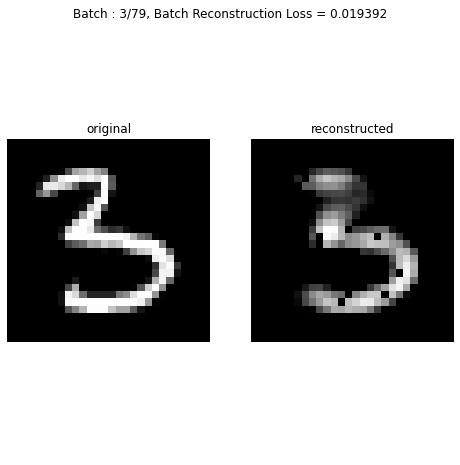

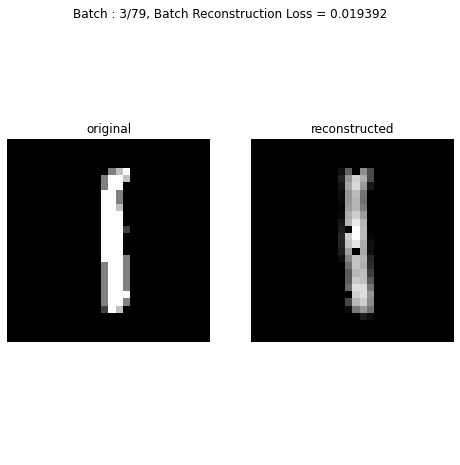

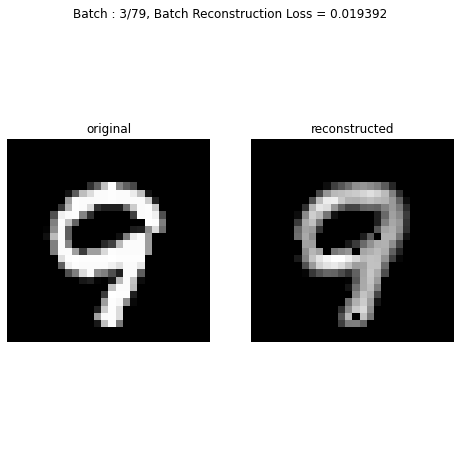

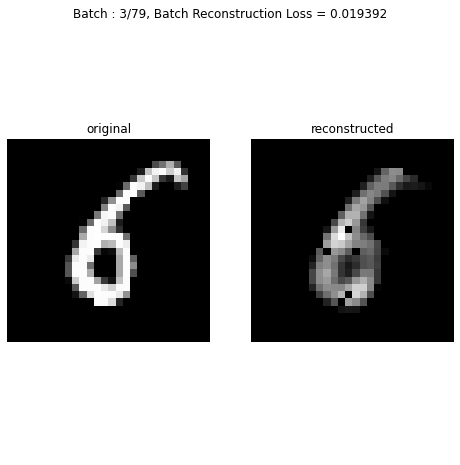

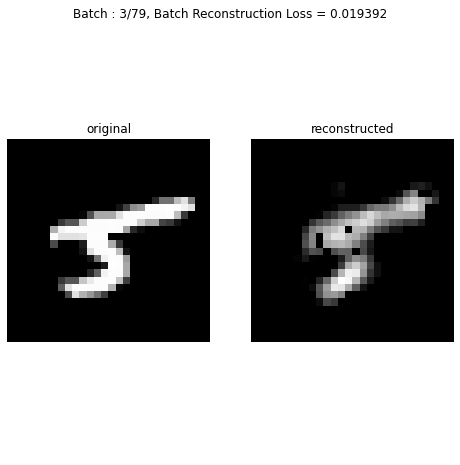

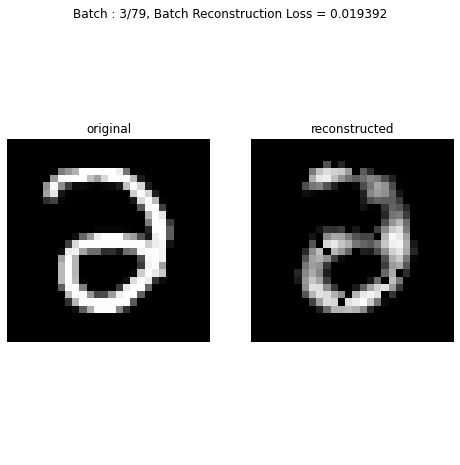

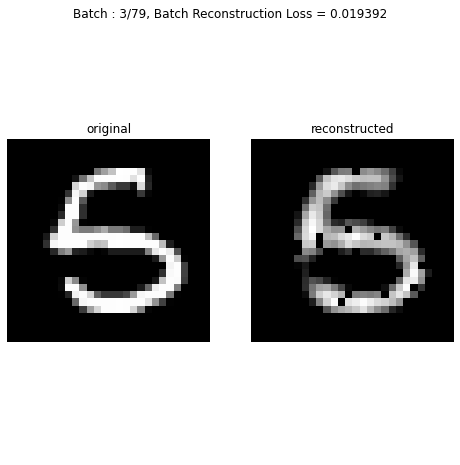

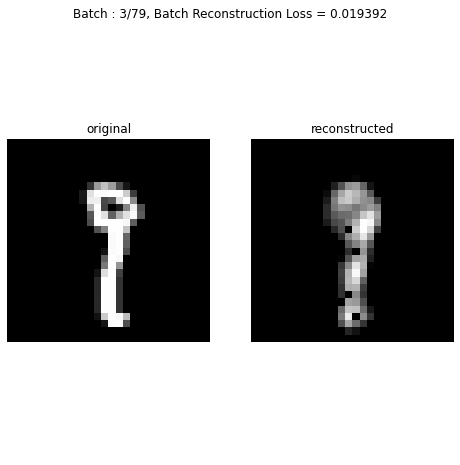

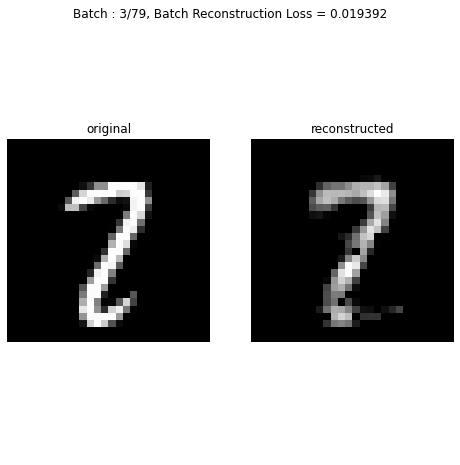

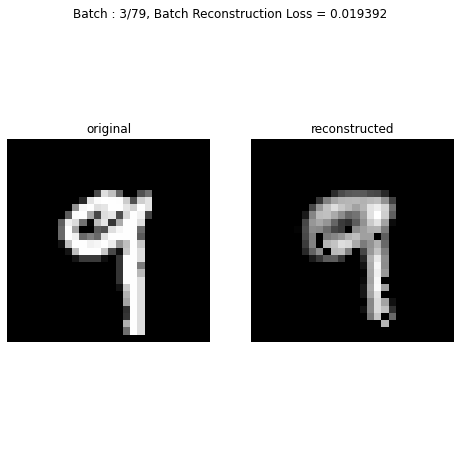

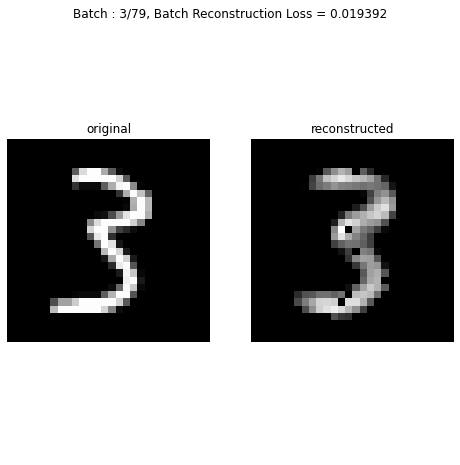

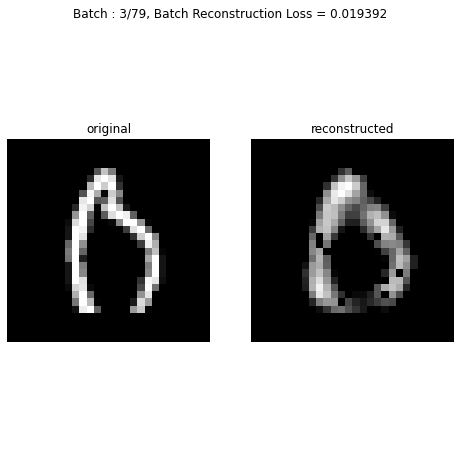

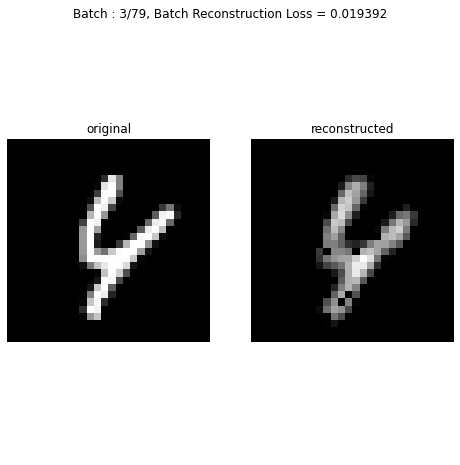

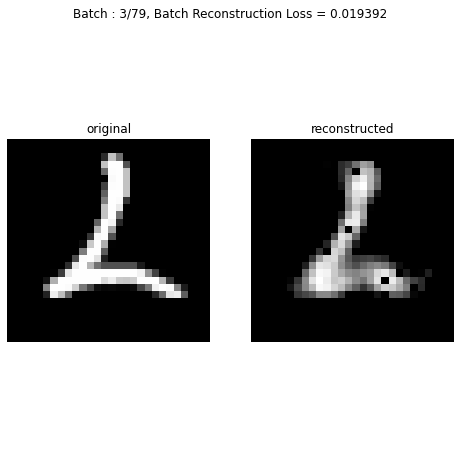

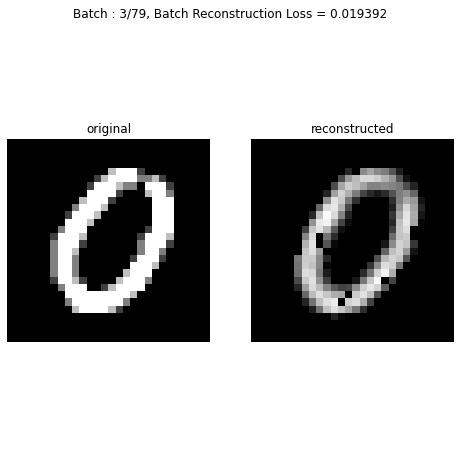

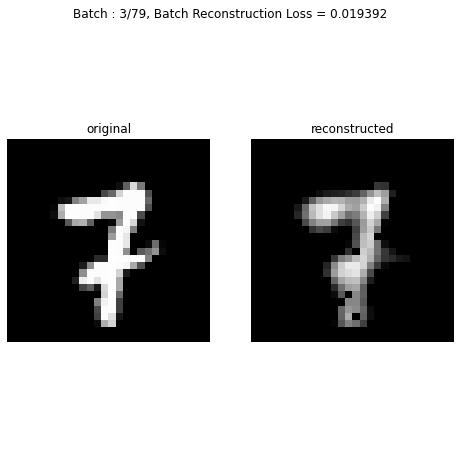

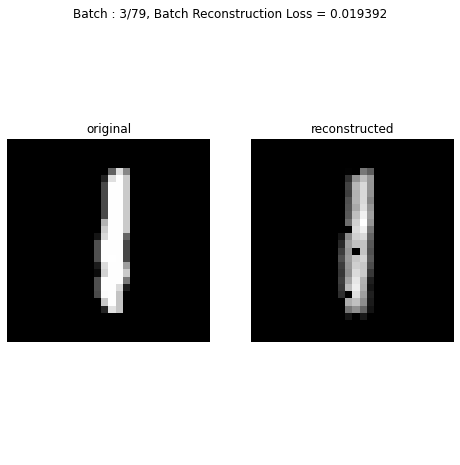

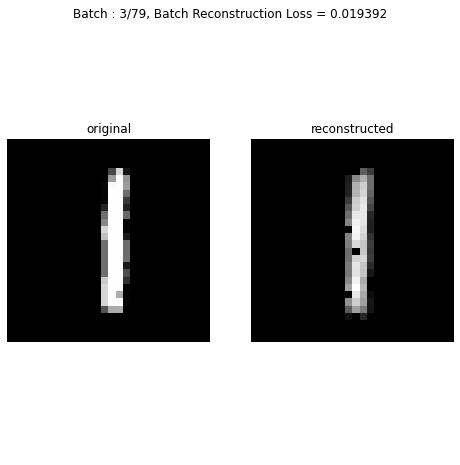

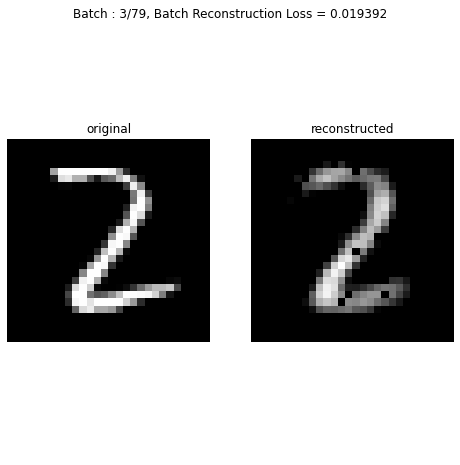

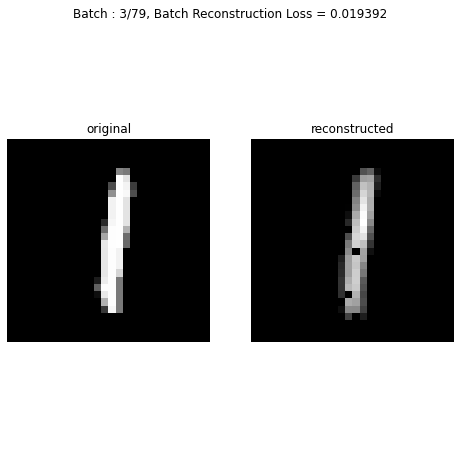

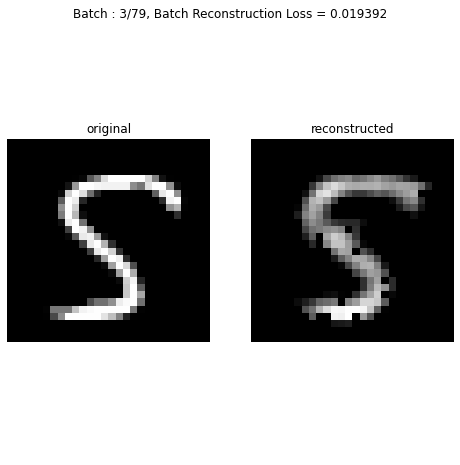

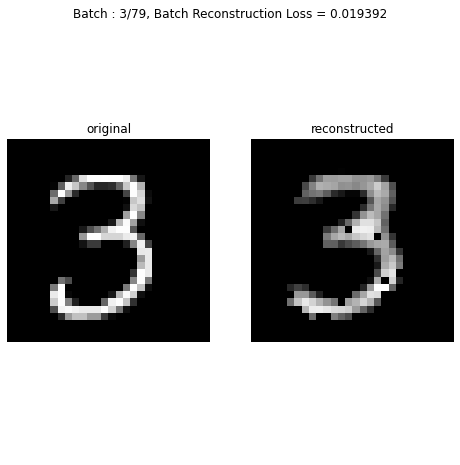

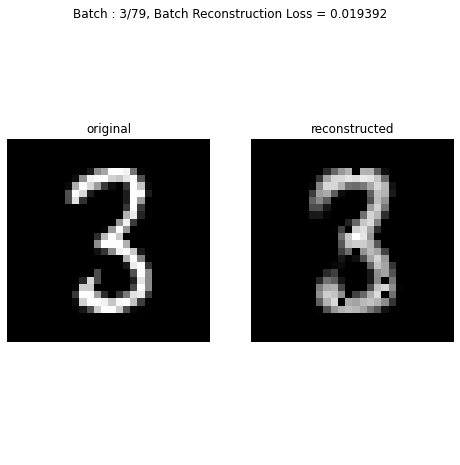

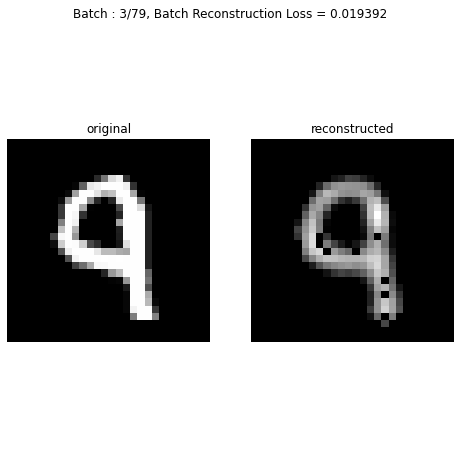

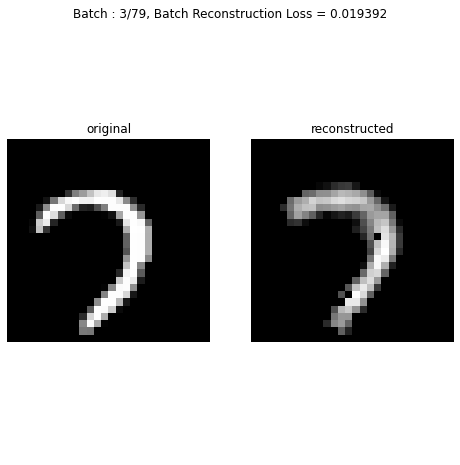

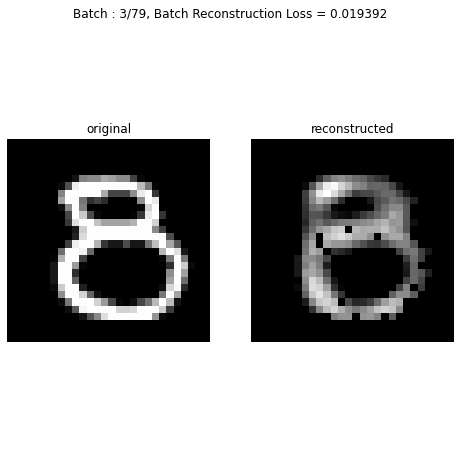

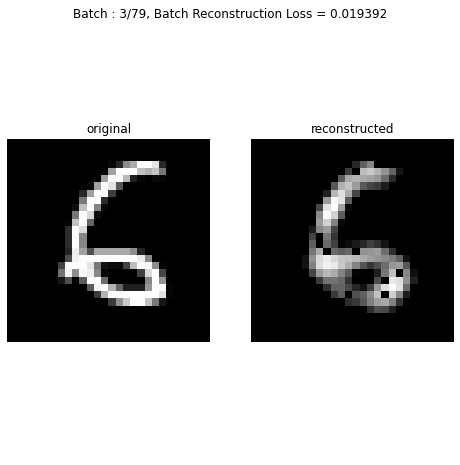

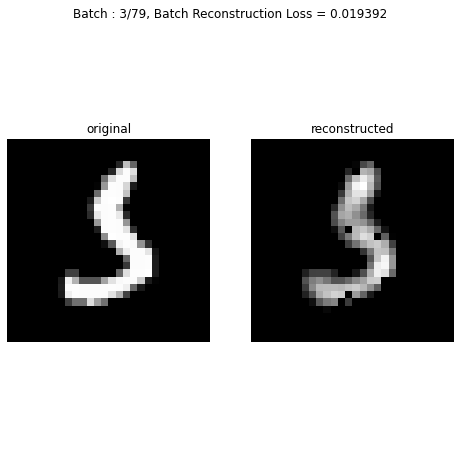

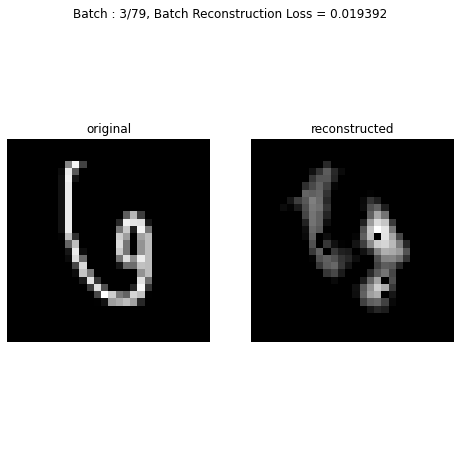

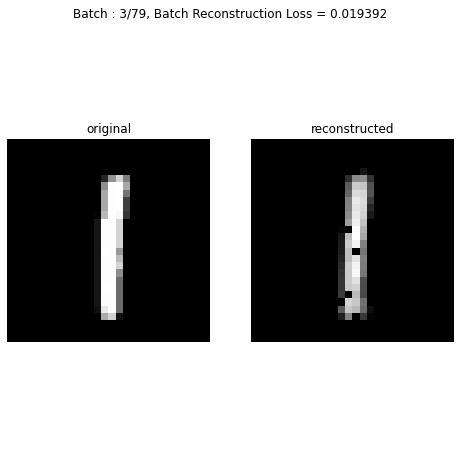

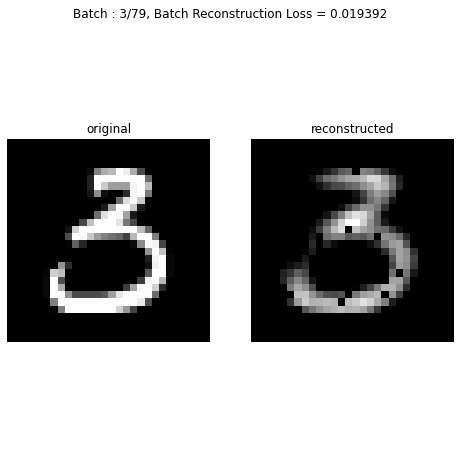

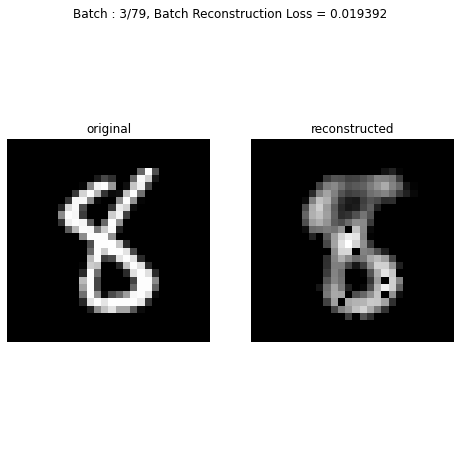

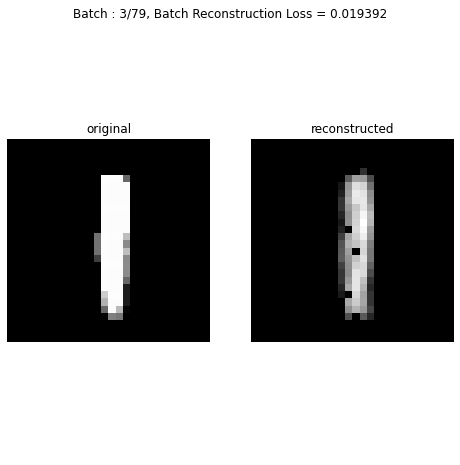

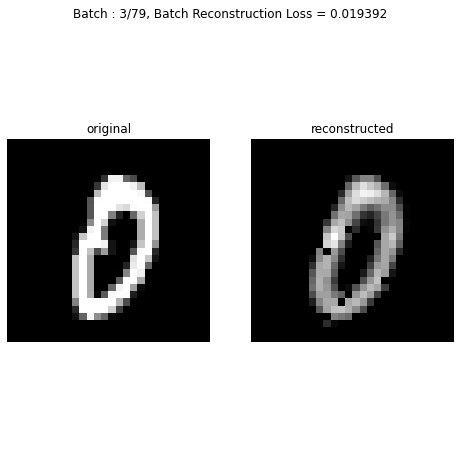

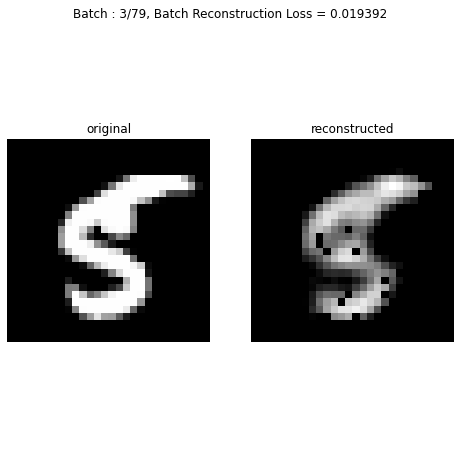

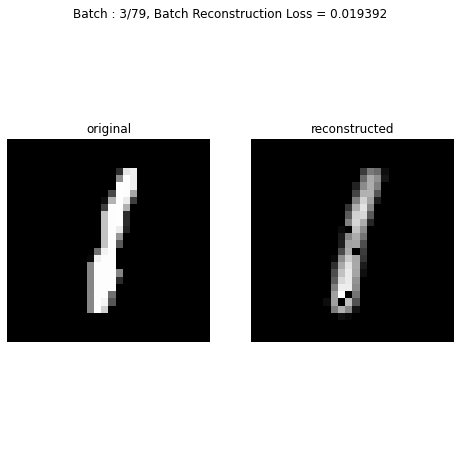

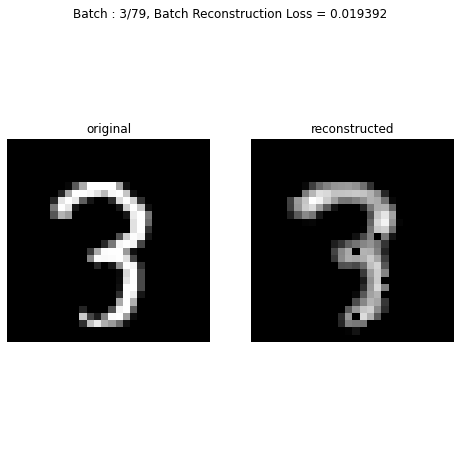

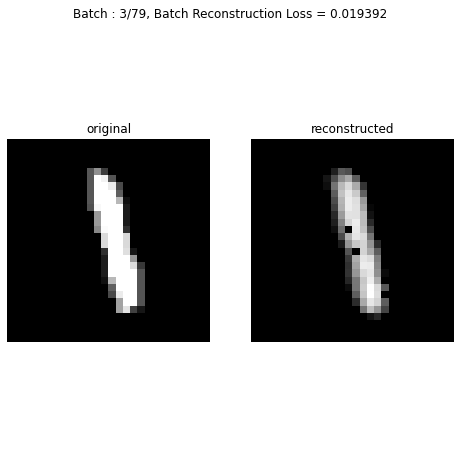

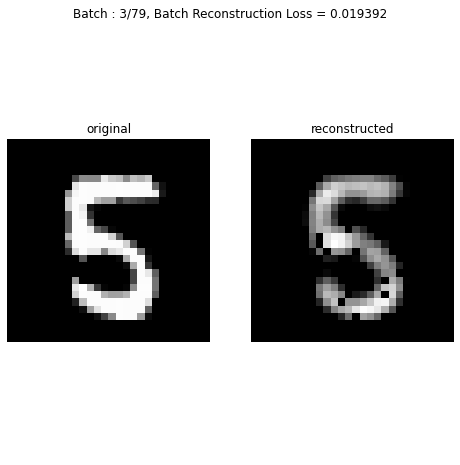

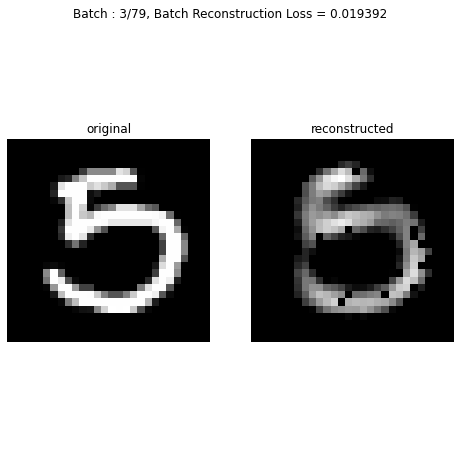

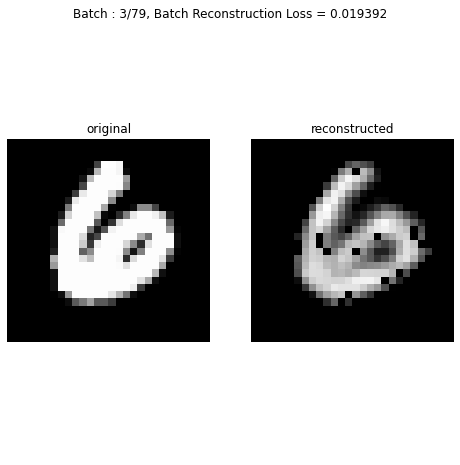

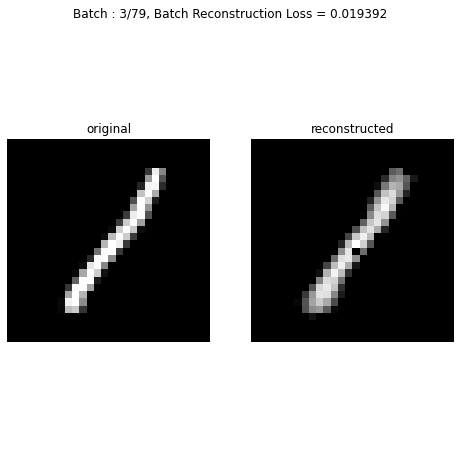

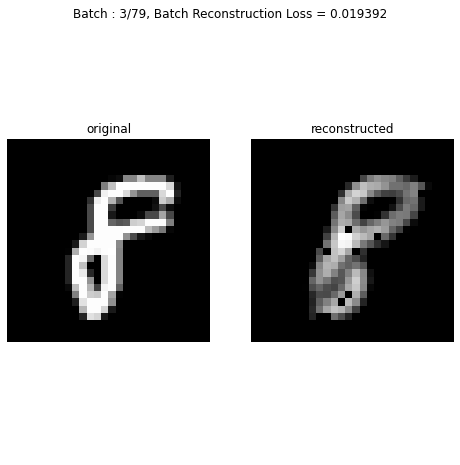

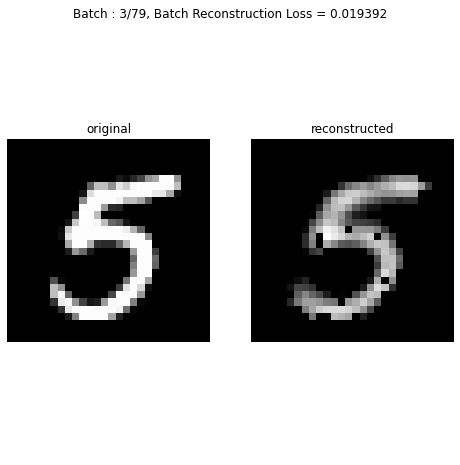

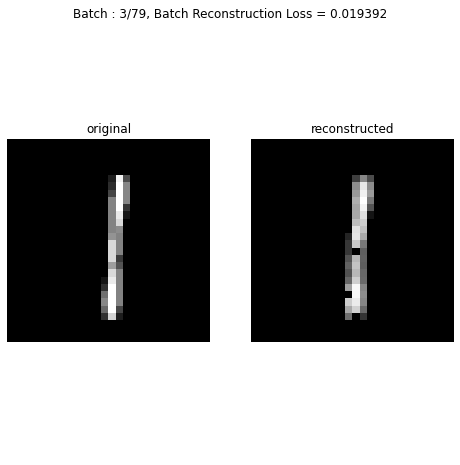

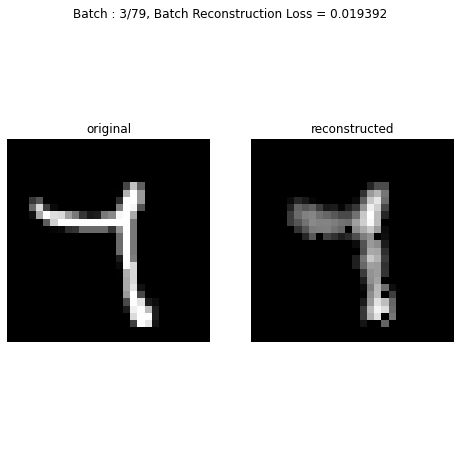

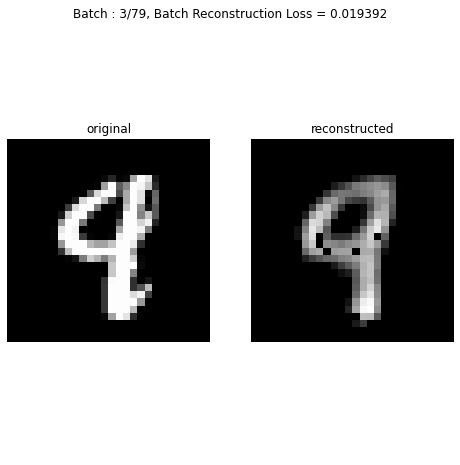

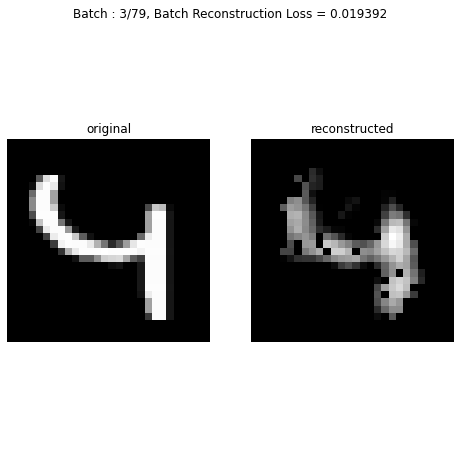

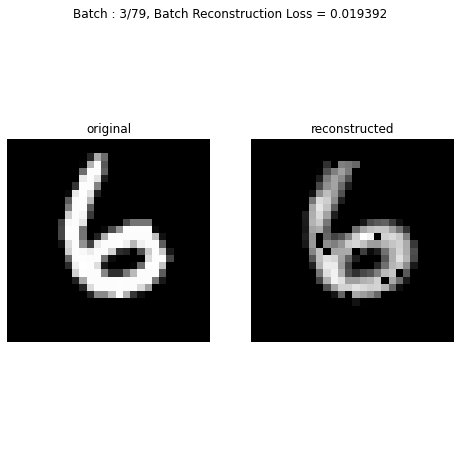

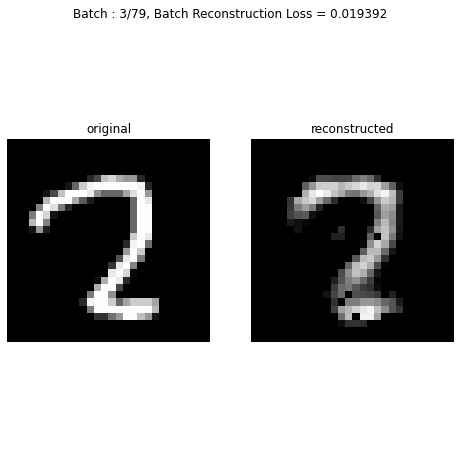

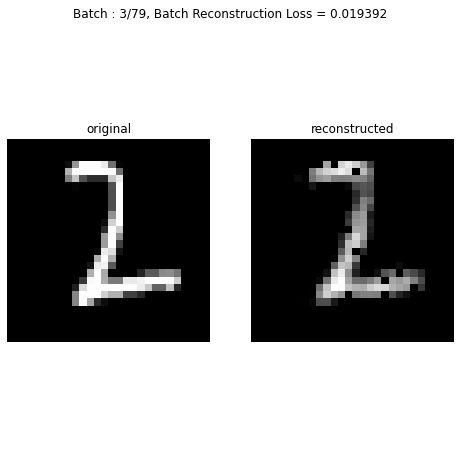

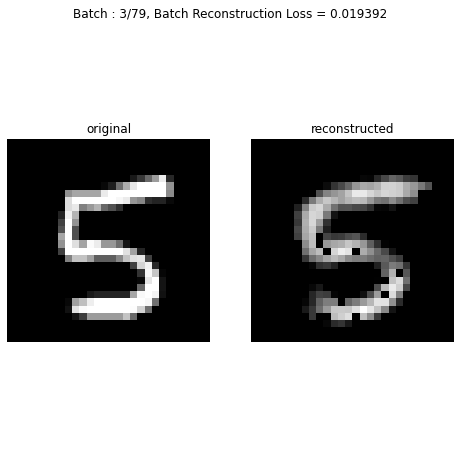

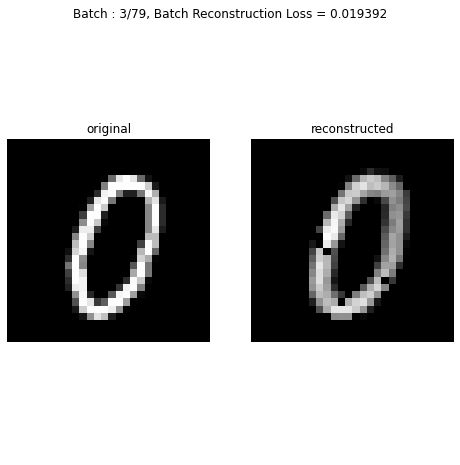

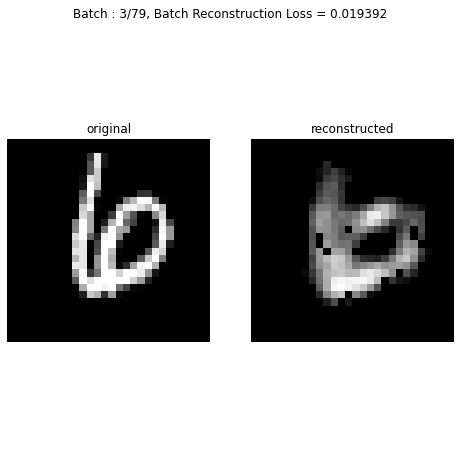

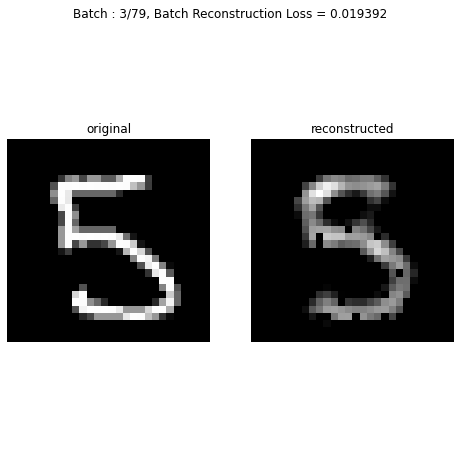

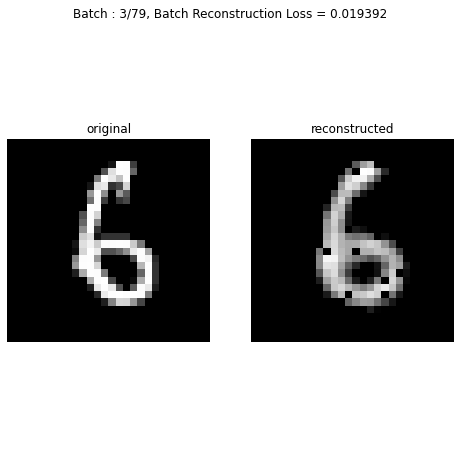

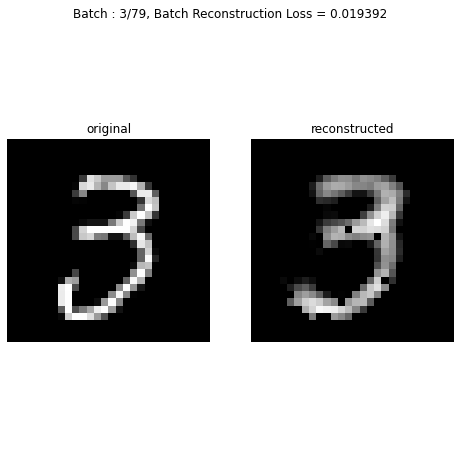

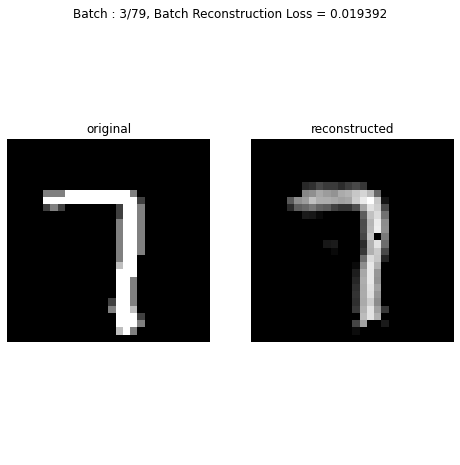

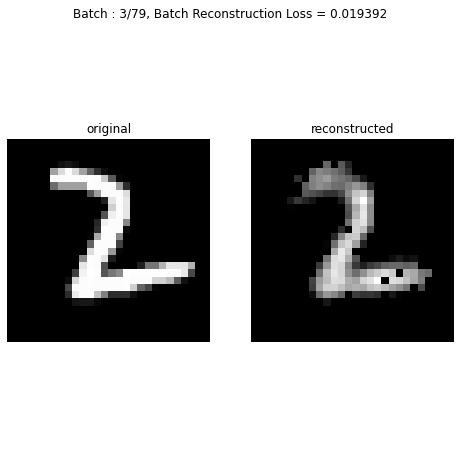

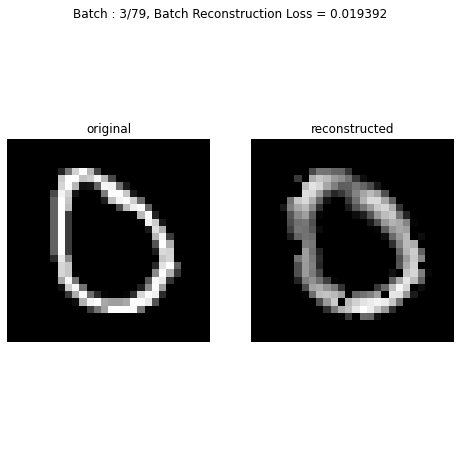

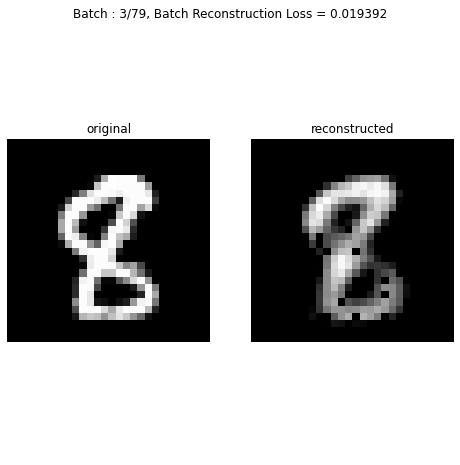

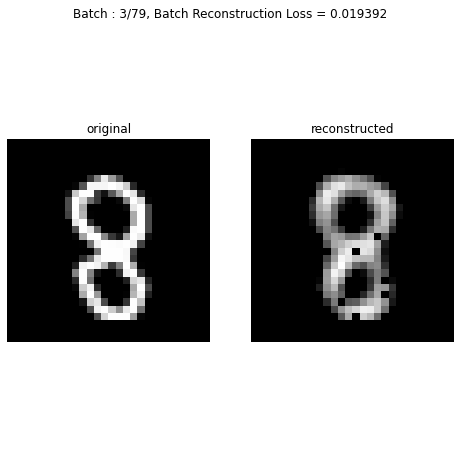

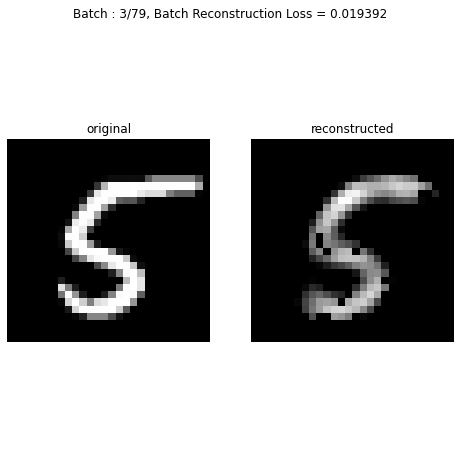

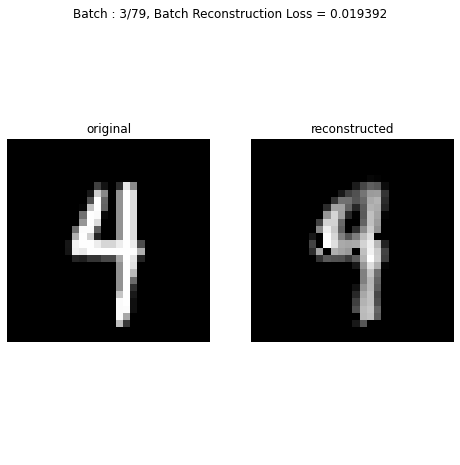

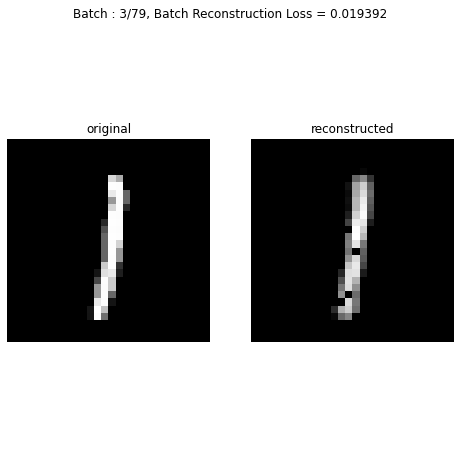

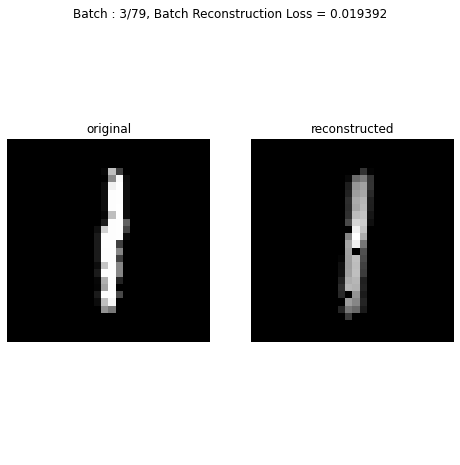

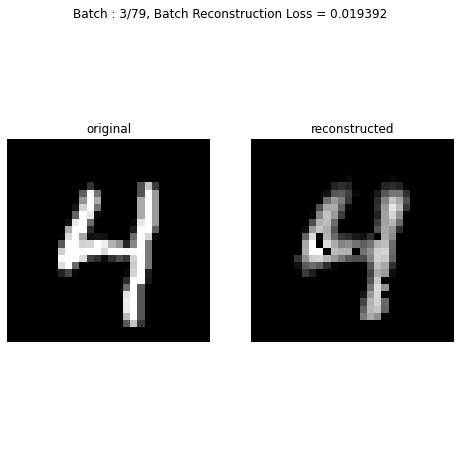

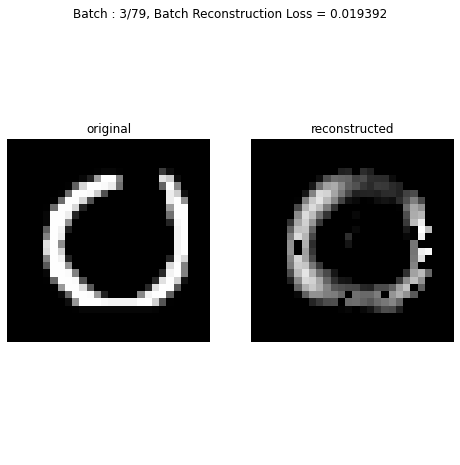

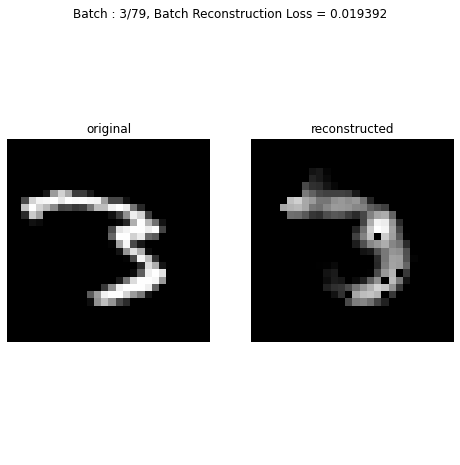

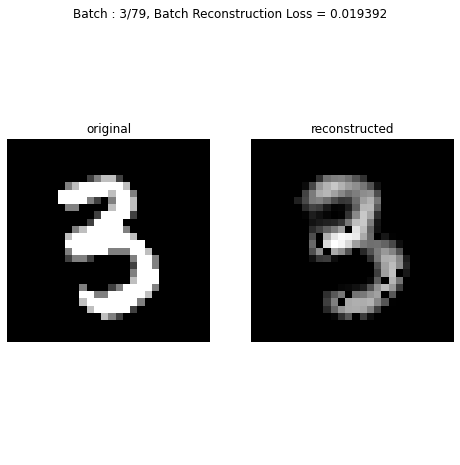

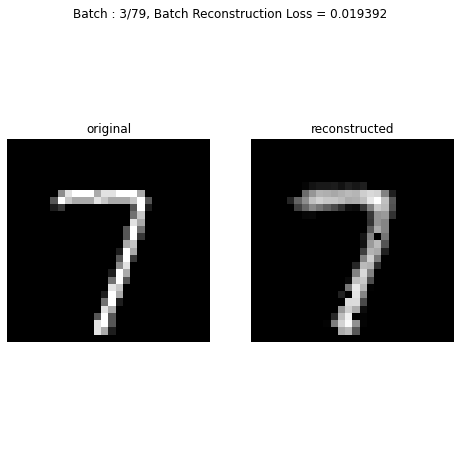

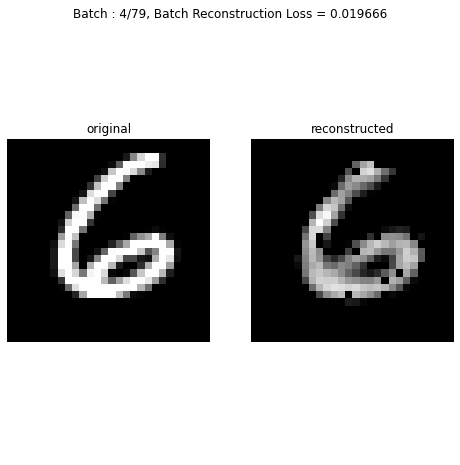

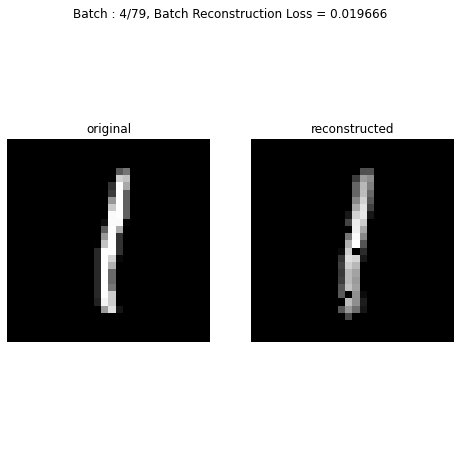

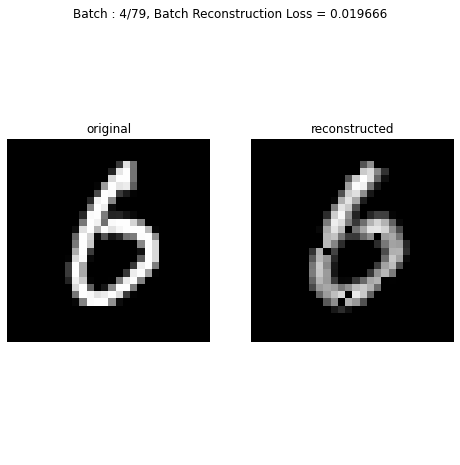

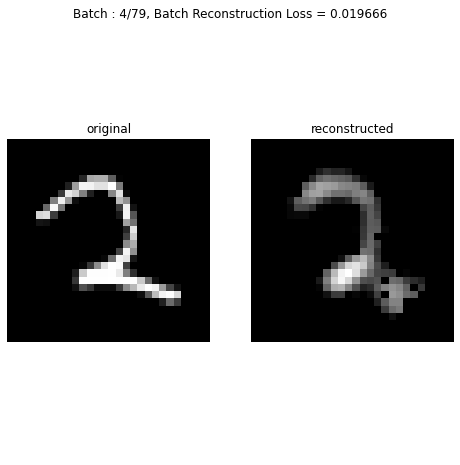

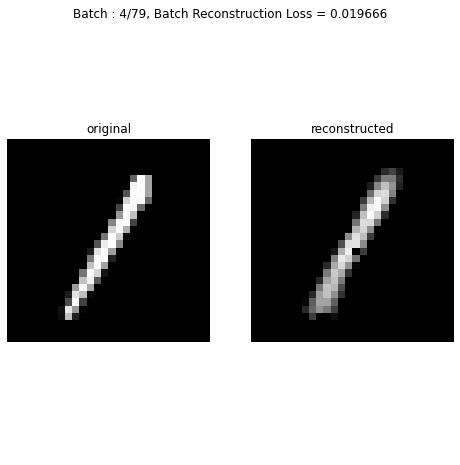

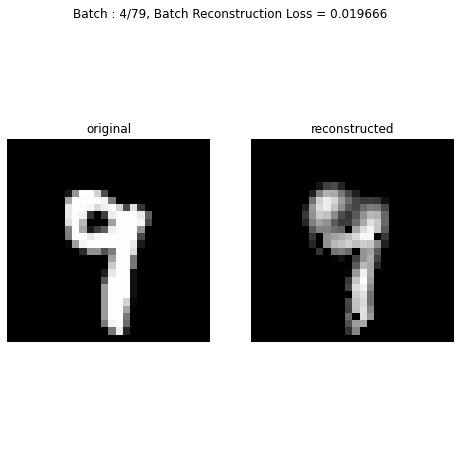

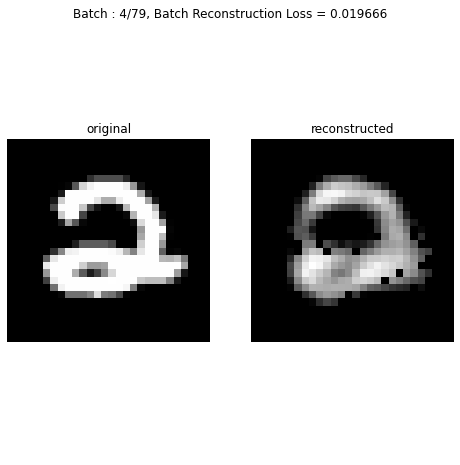

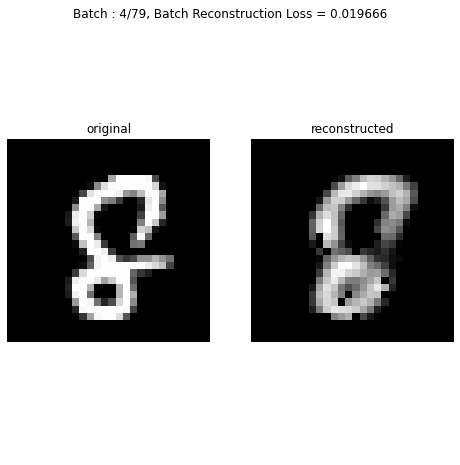

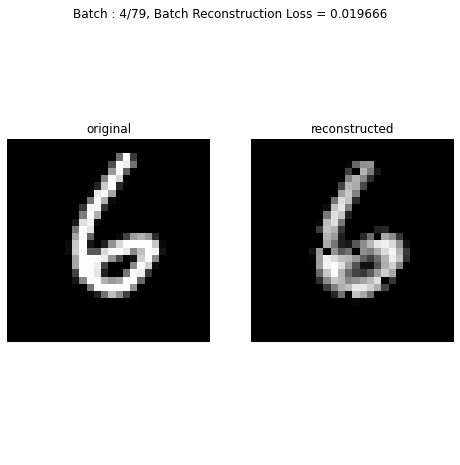

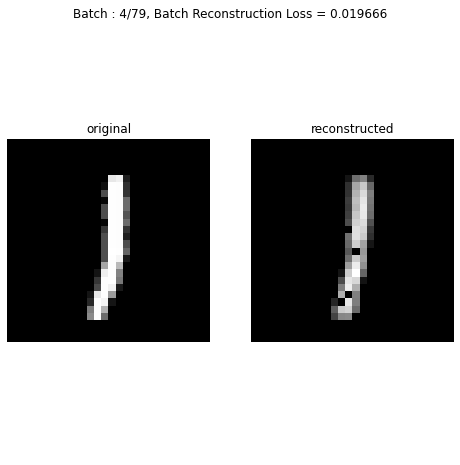

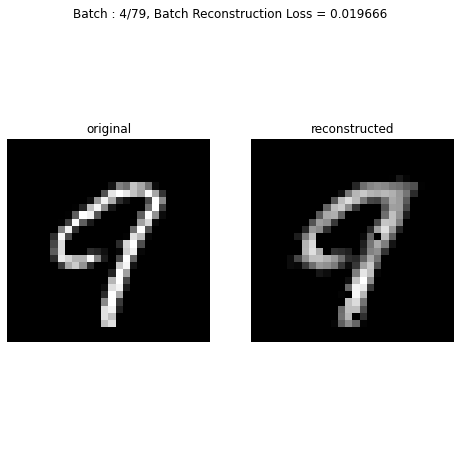

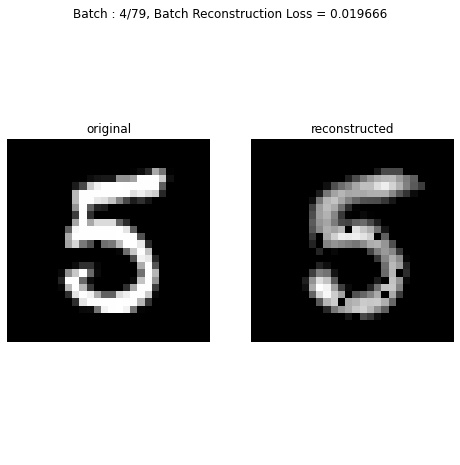

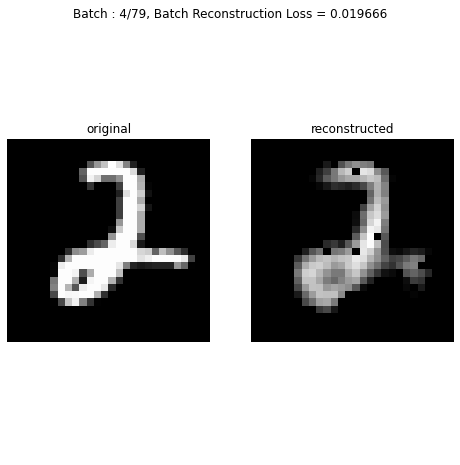

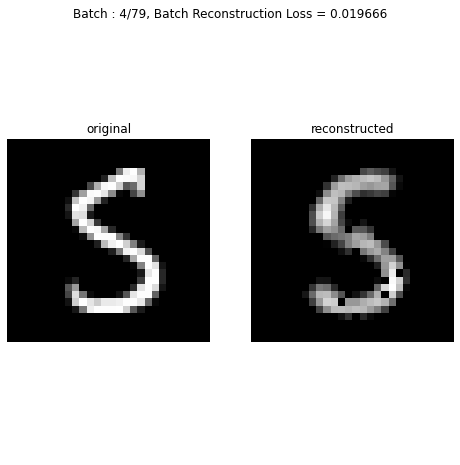

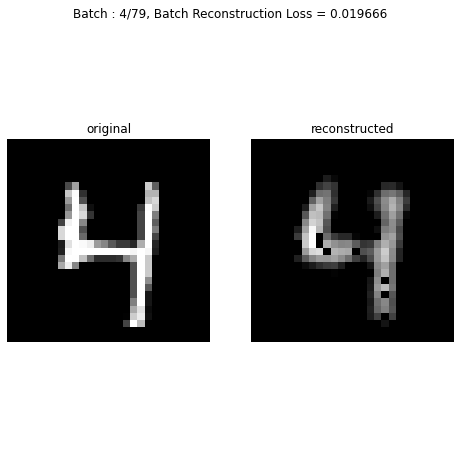

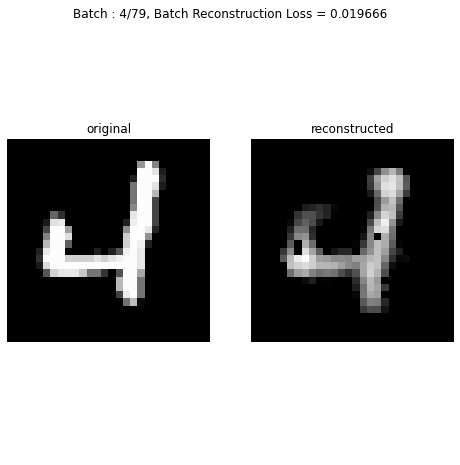

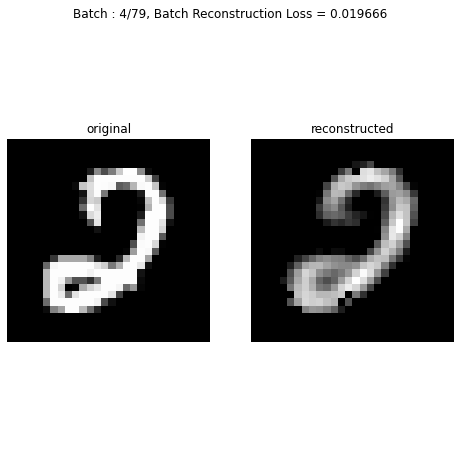

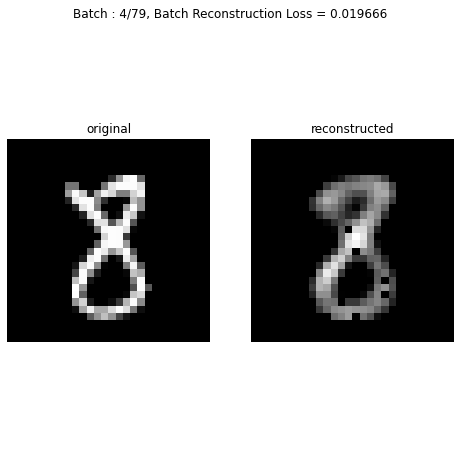

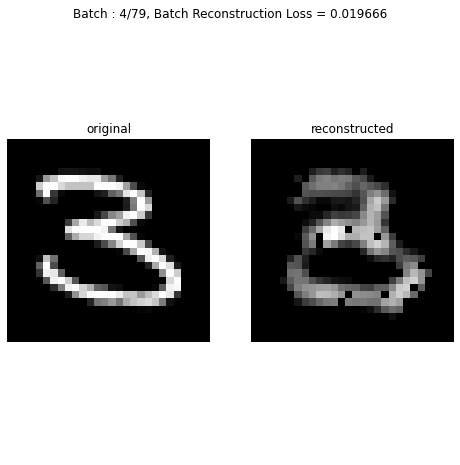

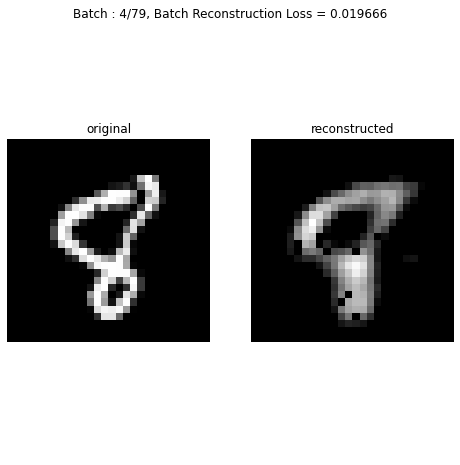

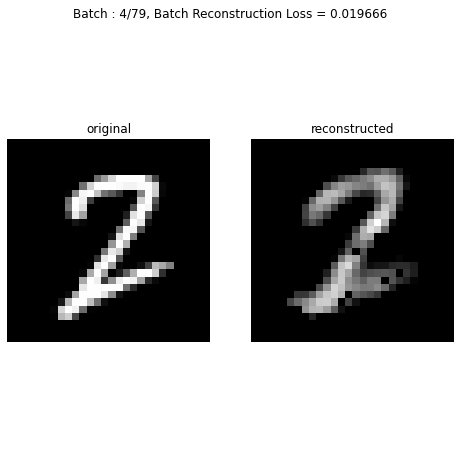

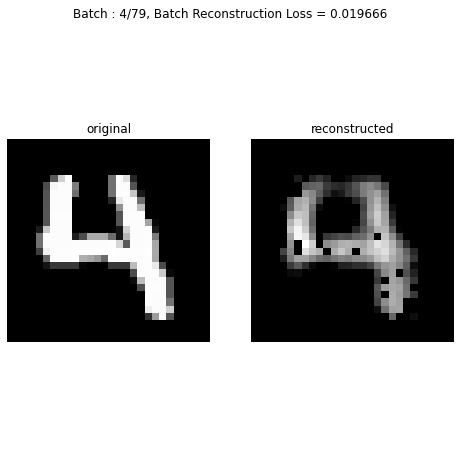

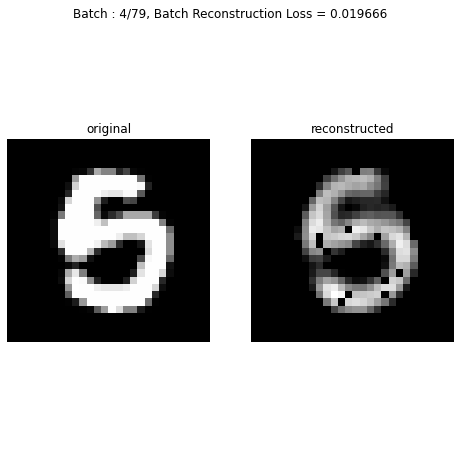

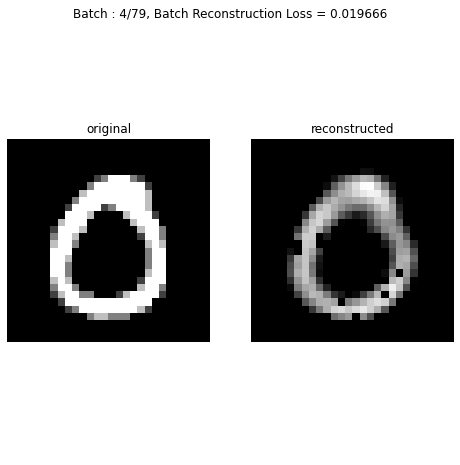

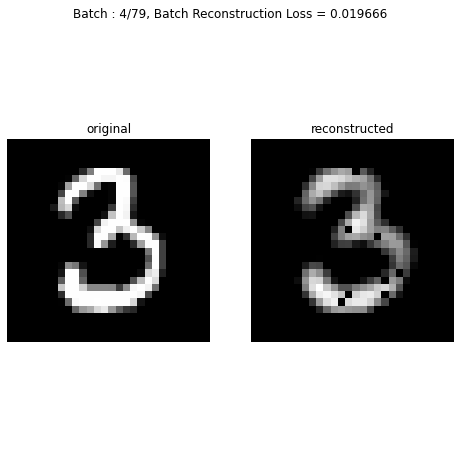

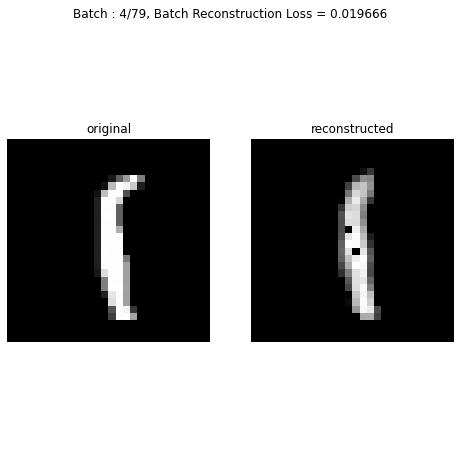

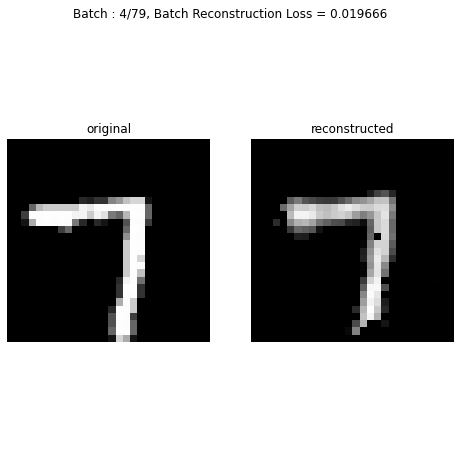

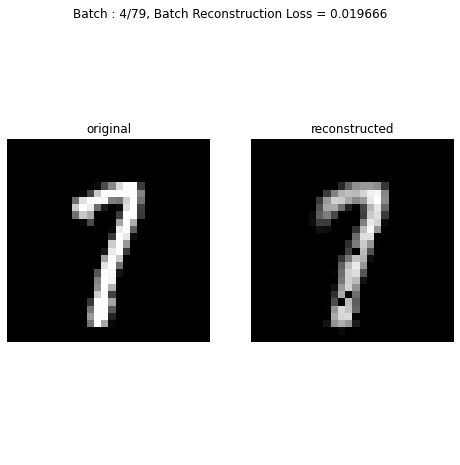

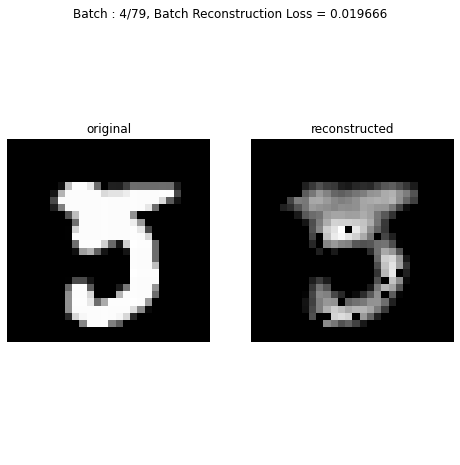

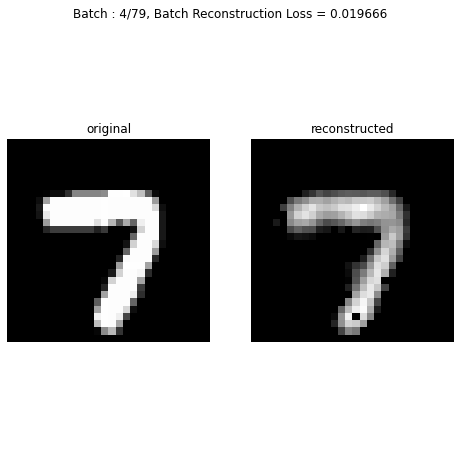

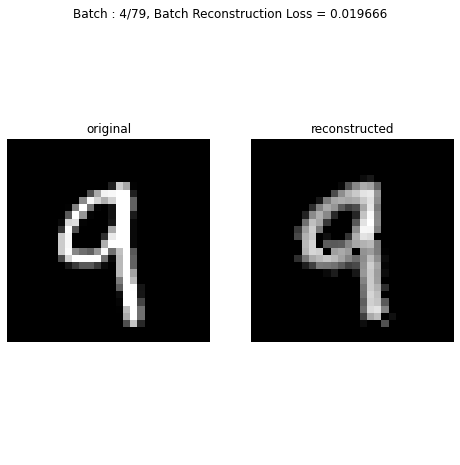

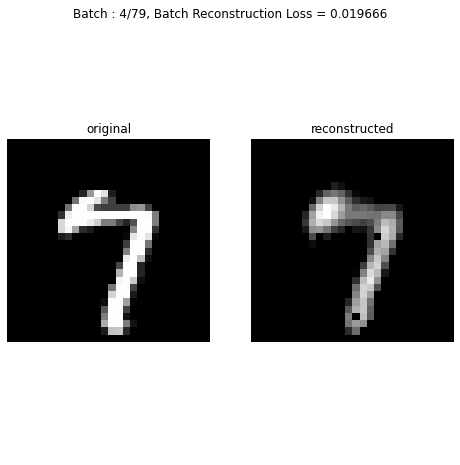

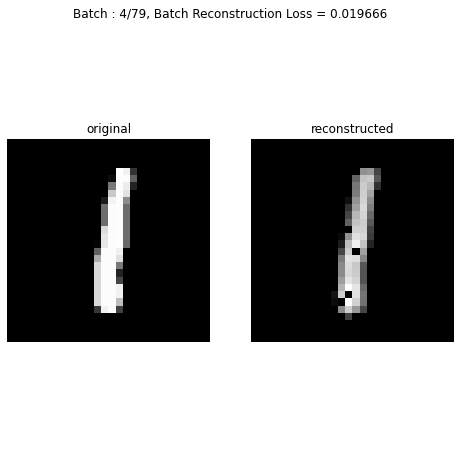

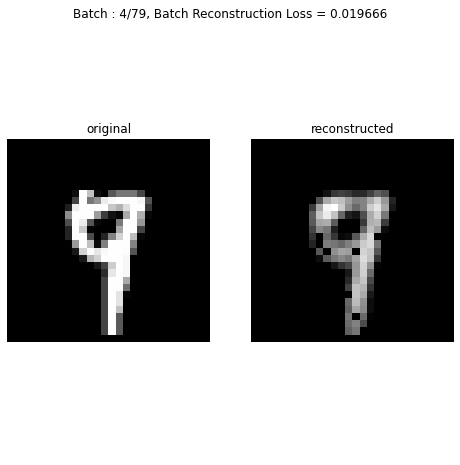

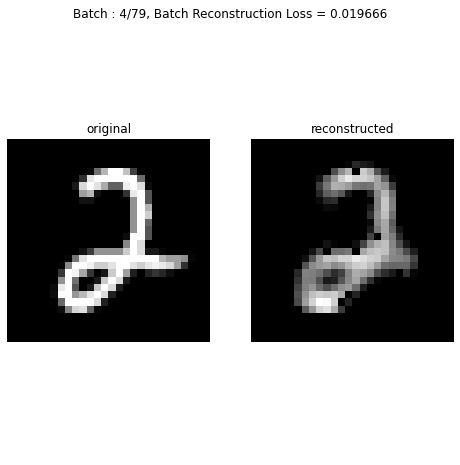

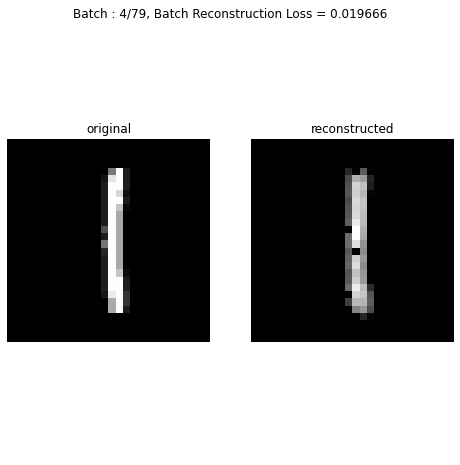

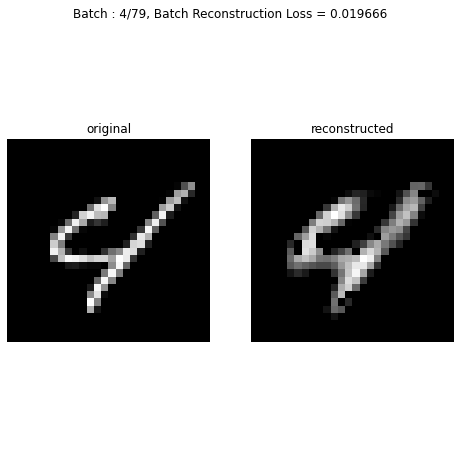

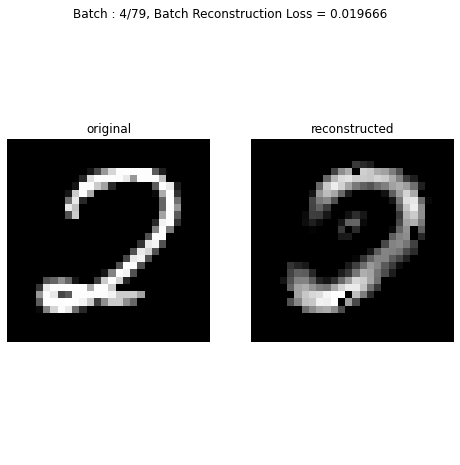

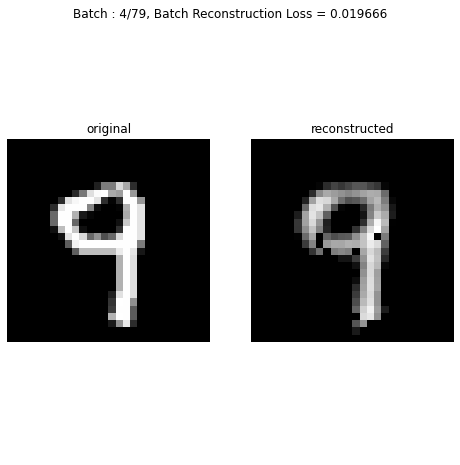

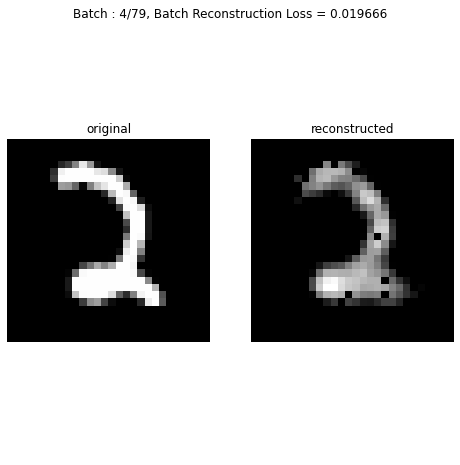

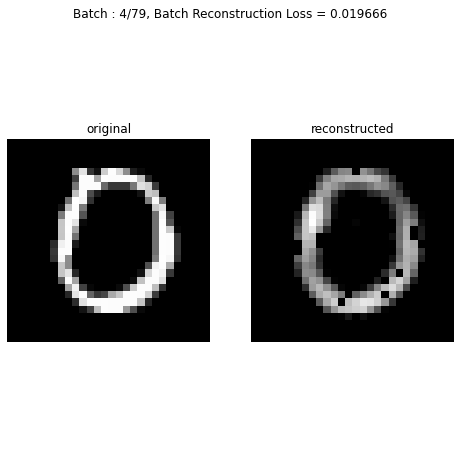

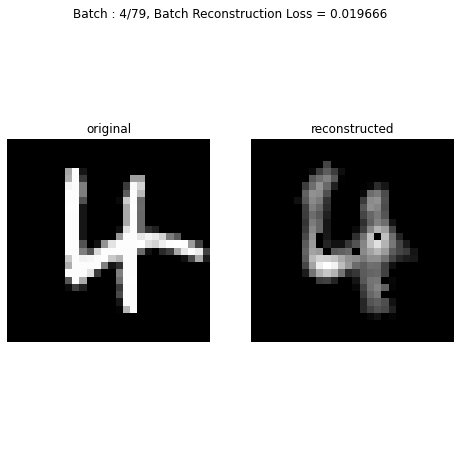

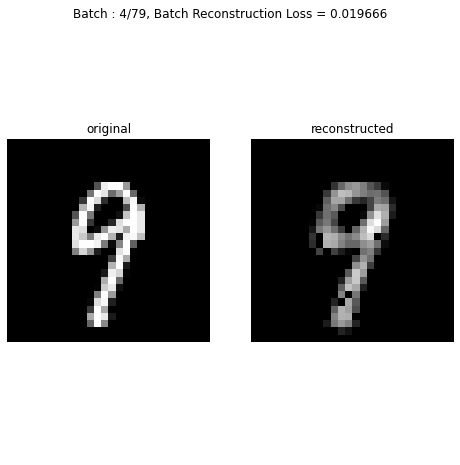

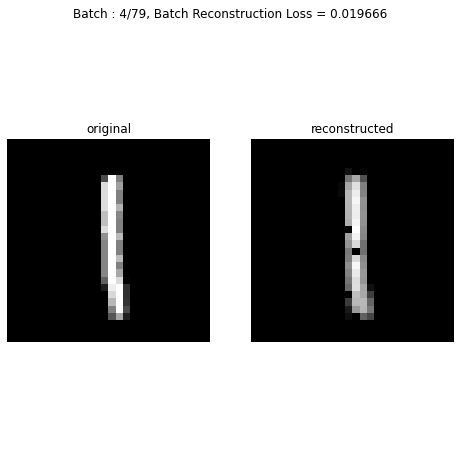

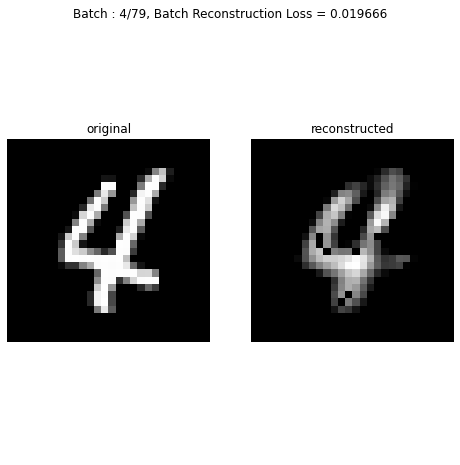

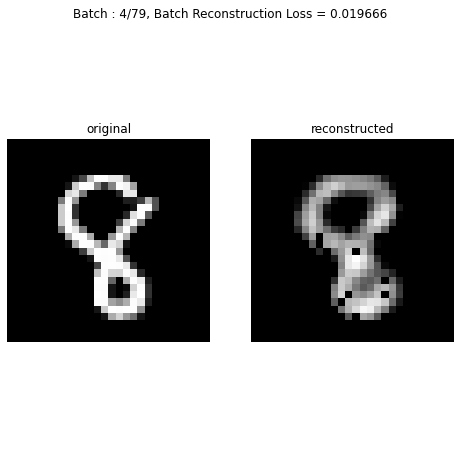

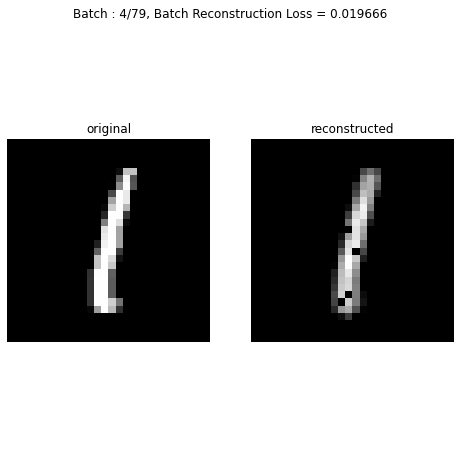

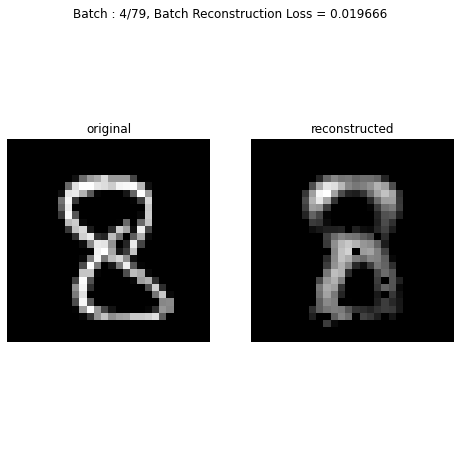

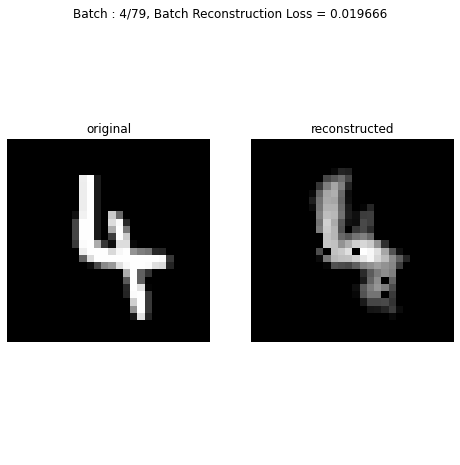

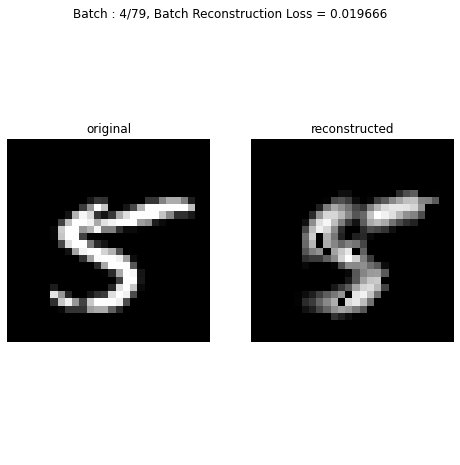

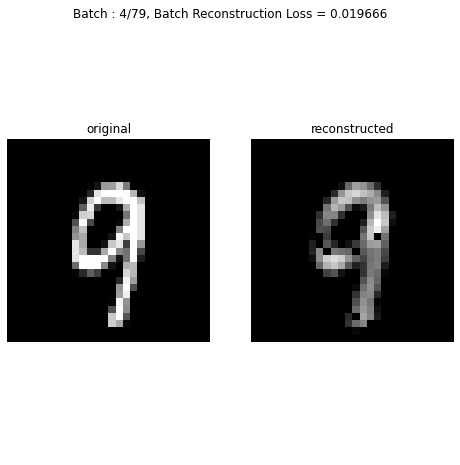

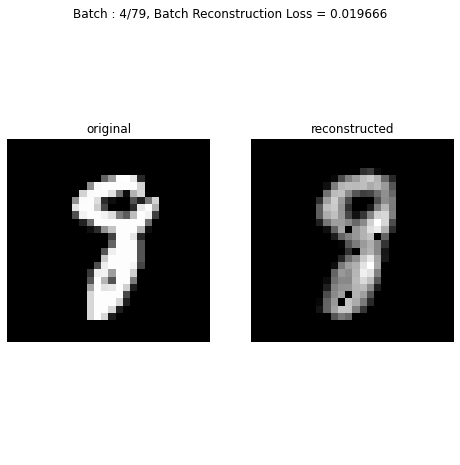

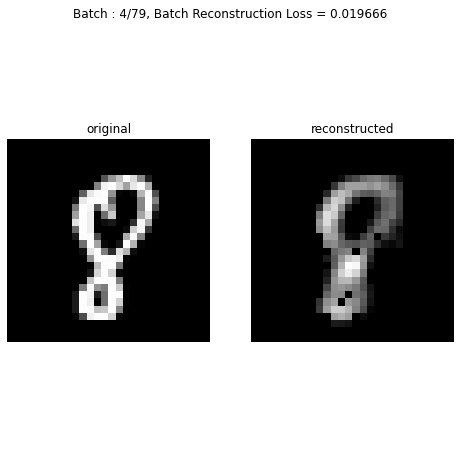

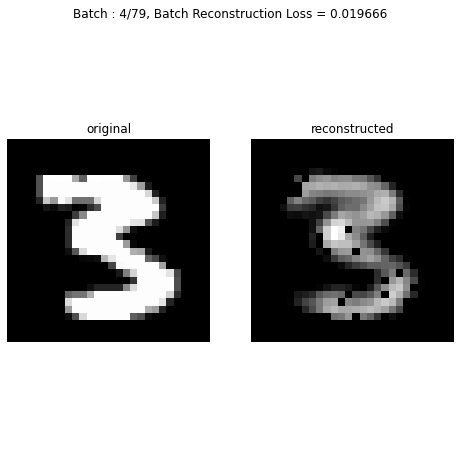

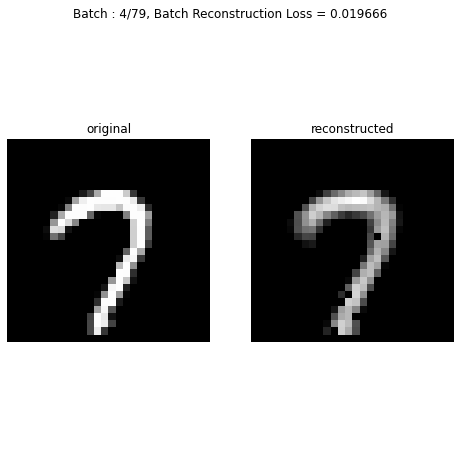

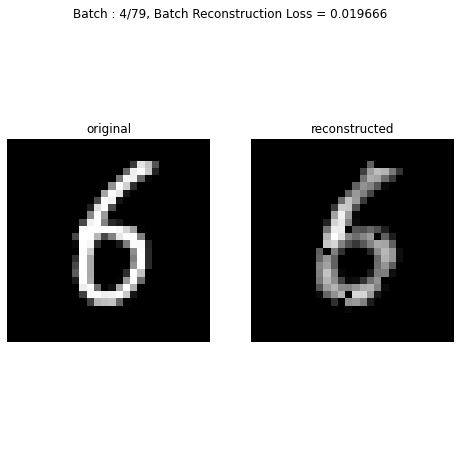

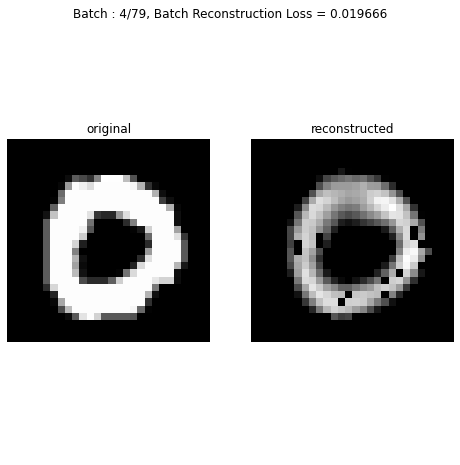

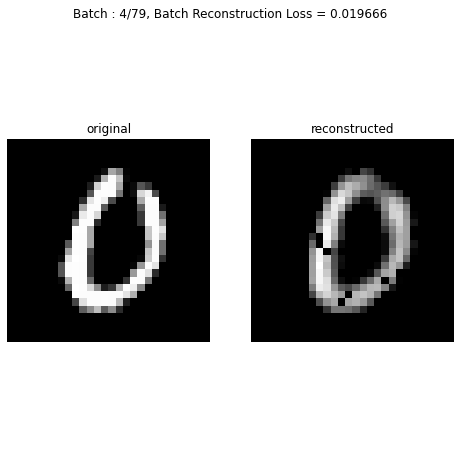

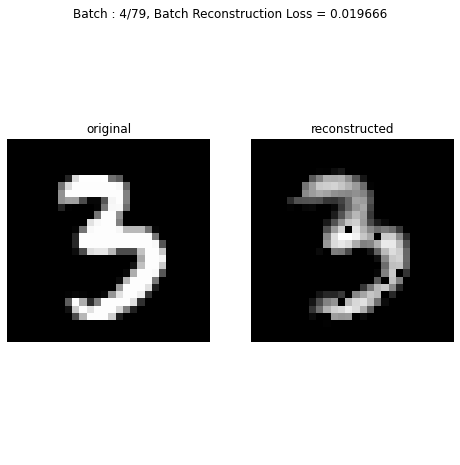

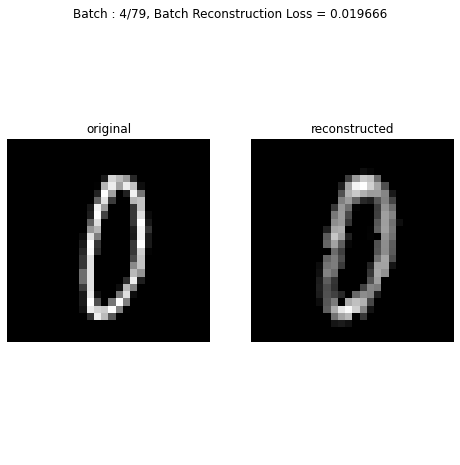

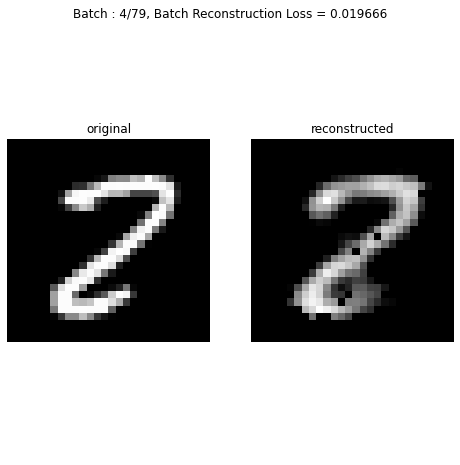

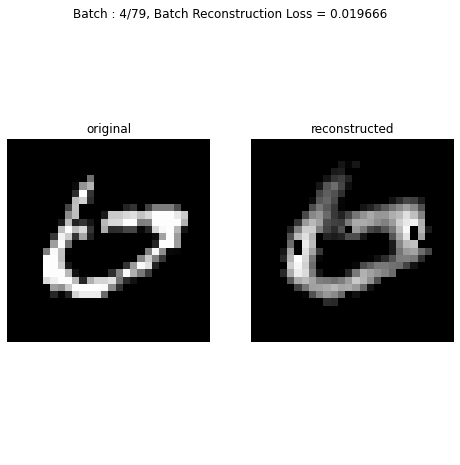

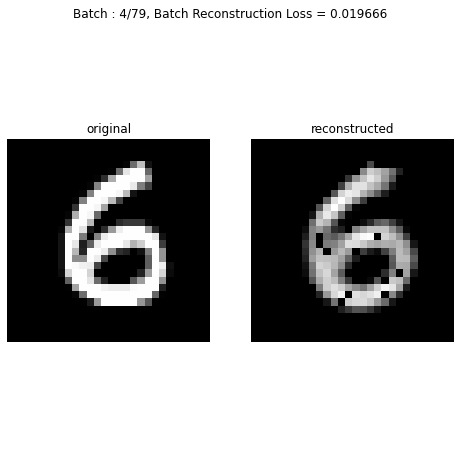

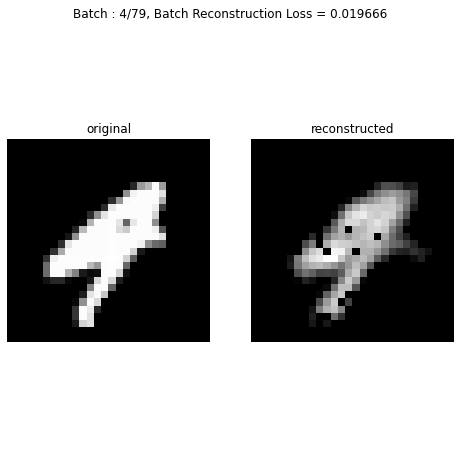

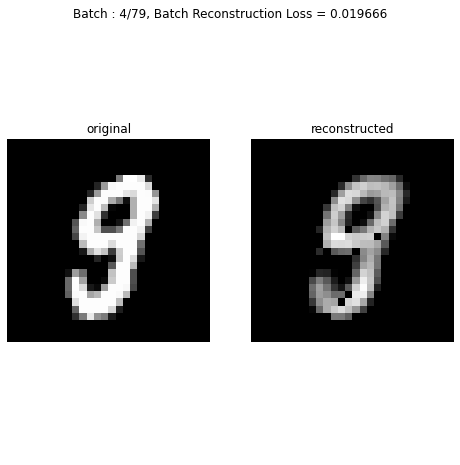

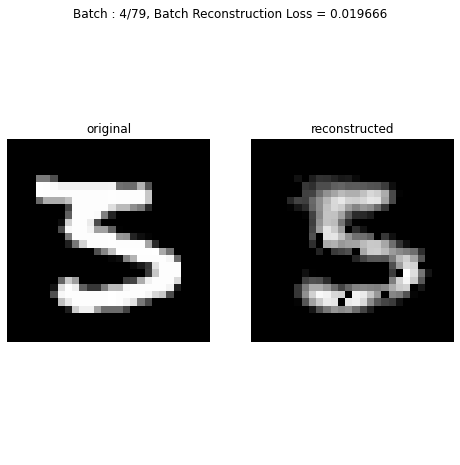

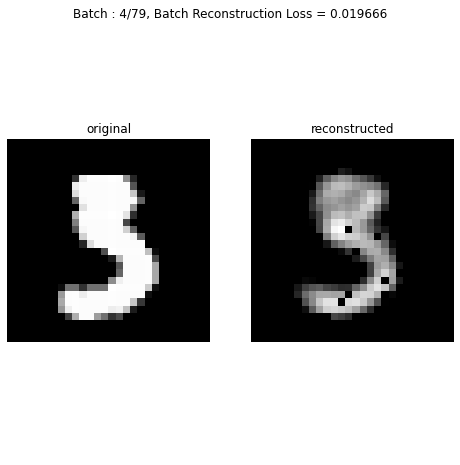

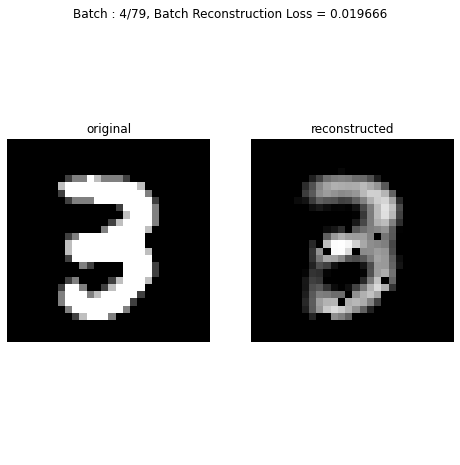

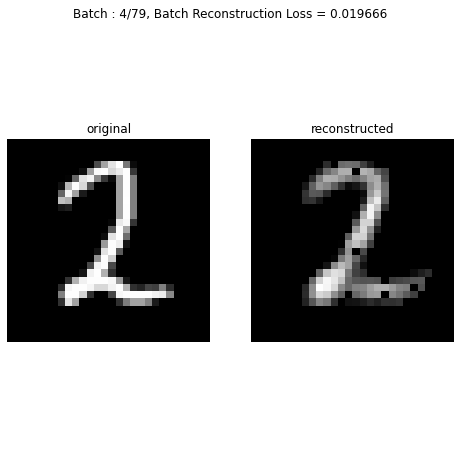

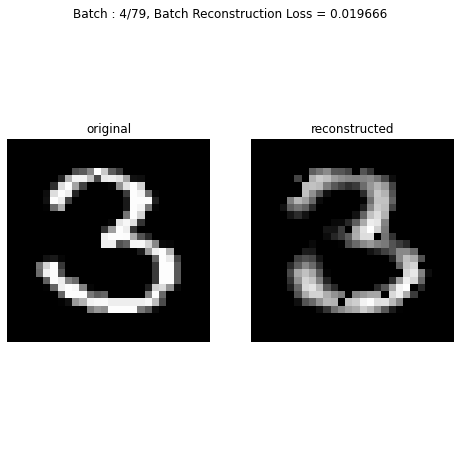

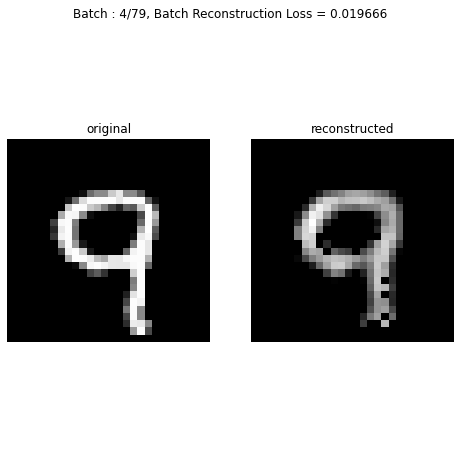

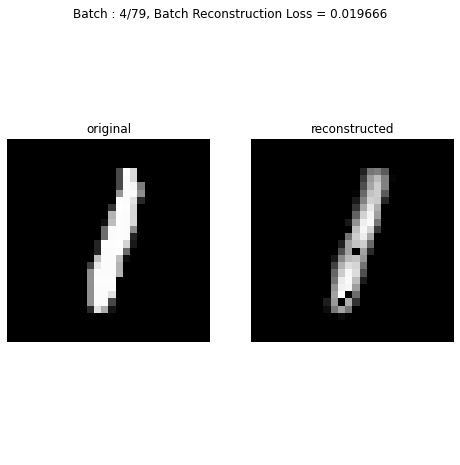

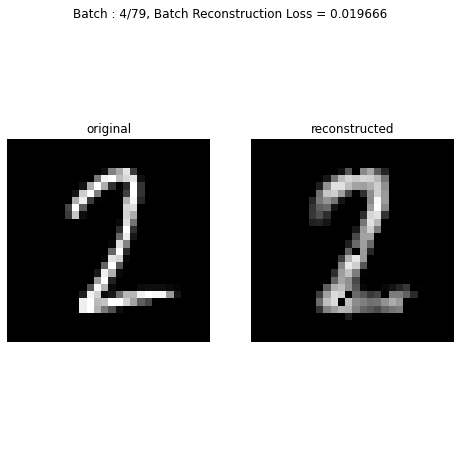

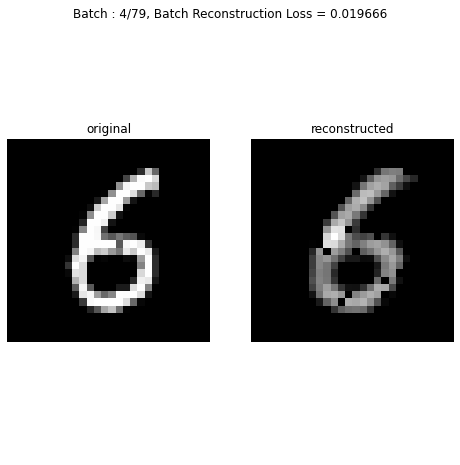

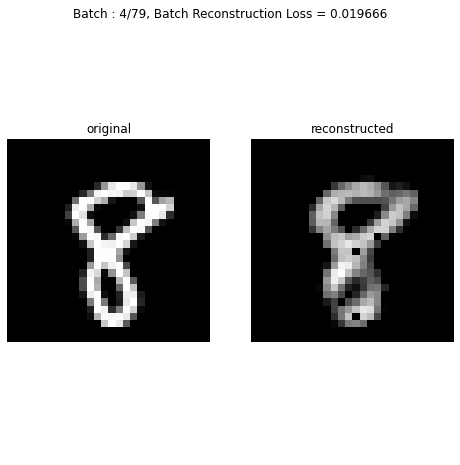

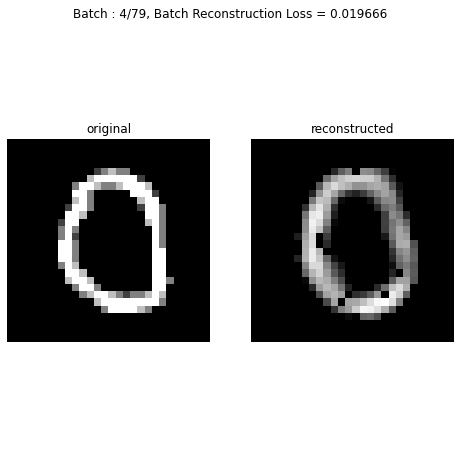

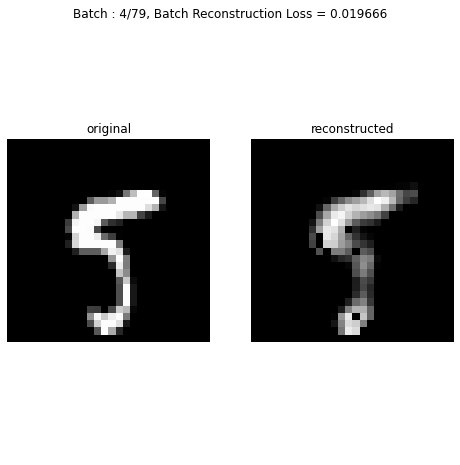

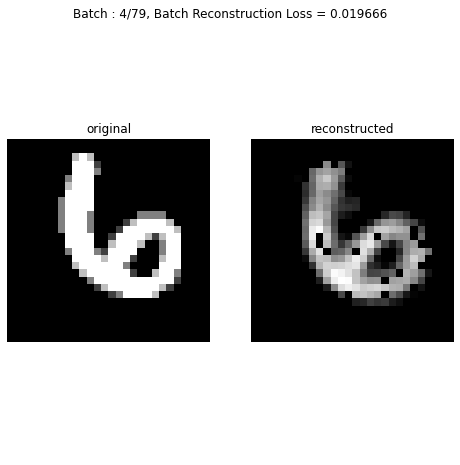

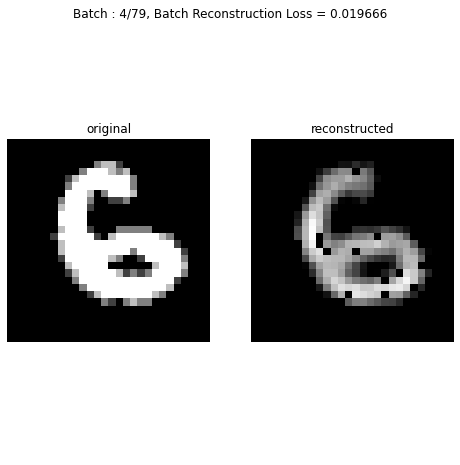

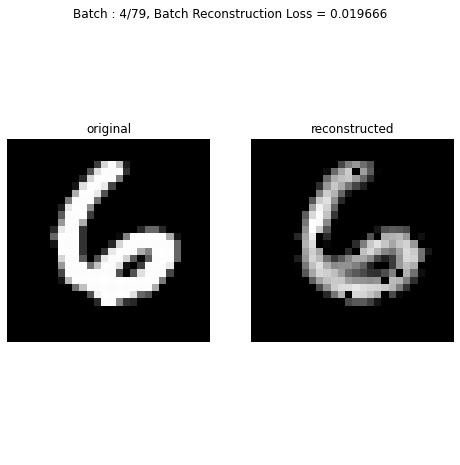

KeyboardInterrupt: 

In [16]:
# Testing

comparisons = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch in test_loader:
        batch_features = batch[0]
        batch_features = batch_features.view(-1, 784).to(device)

        reconstructions = model(batch_features)
        # Reconstruction loss
        test_loss = criterion(reconstructions, batch_features)
        comparisons.append([test_loss, batch_features, reconstructions])

print(len(comparisons))

for i, batch in enumerate(comparisons):
    loss = batch[0]
    batch_features = batch[1]
    reconstructions = batch[2]
    # Iterate through all examples in ith batch
    for j in range(len(batch_features)):
        # Reshape original example for plotting
        original = batch_features[j].reshape(28, 28)
        original = original.cpu()
        # Reshape reconstructed example for plotting
        reconstruction = reconstructions[j].reshape(28, 28)
        reconstruction = reconstruction.cpu()
        
        fig = plt.figure(figsize=(8, 8))
        plt.title("Batch : {}/{}, Batch Reconstruction Loss = {:.6f}".format(i+1, len(comparisons), loss))
        plt.axis('off')
        # display original
        fig.add_subplot(1, 2, 1)
        plt.imshow(original)
        plt.axis('off')
        plt.title("original")
        plt.gray()
        
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)

        # display reconstruction
        fig.add_subplot(1, 2, 2)
        plt.imshow(reconstruction)
        plt.axis('off')
        plt.title("reconstructed")
        plt.gray()
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)
        plt.show()
        
        # w = 10
        # h = 10
        # fig = plt.figure(figsize=(8, 8))
        # columns = 4
        # rows = 5
        # for i in range(1, columns*rows +1):
        #     img = np.random.randint(10, size=(h,w))
        #     fig.add_subplot(rows, columns, i)
        #     plt.imshow(img)
        # plt.show()